In [1]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [2]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_total_1st_search = 'data/output/Full_dataset/58K_200524.csv'
df_precursor_path ="data/output/Prescursor_data/precursor_data_new_clustering.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [3]:
# load and check the search space
from stk_search import Search_space
search_space = pd.read_pickle(search_space_loc)
print(' Search space condition list:', search_space.conditions_list)
print('shape of df_precursors:', search_space.df_precursors.shape)
print('search space syntax:', search_space.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (274, 49)
search space syntax: [0, 1, 2, 3, 4, 5]


In [4]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark , df_precursors= database_utils.load_data_from_file(df_total_path_bench, df_precursor_path,add_feature_frag=True)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
print('shape of df_Benchmark:', df_Benchmark.shape)
print('shape of df_precursors:', df_precursors.shape)
print('shape of df_precursor_Mordred:', df_precursor_Mordred.shape)
print(df_Benchmark[df_Benchmark['target']>0].shape[0]/df_Benchmark.shape[0])

shape of df_Benchmark: (30000, 231)
shape of df_precursors: (274, 48)
shape of df_precursor_Mordred: (312, 101)
0.0111


In [5]:
num_of_elem_in_SP = search_space.check_df_for_element_from_sp(df_Benchmark).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)

number of elements in the benchmark in the search space: (30000, 231)


In [6]:
# set the benchmark parameters  
exp_name = "2nd_test_58K_dataset_full"
num_elem_initialisation=300
num_iteration=500
target = 'target'
aim = 'maximise'
case_name_list = ["ea_surrogate_new", "BO_learned_new"] #'evolution_algorithm','random','BO_precursor', ['evolution_algorithm','random','BO_precursor']#,["ea_surrogate_new", "BO_learned_new"] # "ea_surrogate", "BO_learned"
config_dir_list_new = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240520//SchNet/Full_data/"]#f"/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240513/SchNet/splitrand-nummol{num_mol}" for num_mol in [10000,20000,30000,40000,50000]]

In [49]:
importlib.reload(run_hpc_utils)

def run_search_on_hpc(
    case_name="ea_surrogate",
    df_path_total=df_total_1st_search,
    df_precursors_path=df_precursor_path,
    frag_properties="selected",
    config_dir="",
    dataset_representation_path = None,
    test=False,
    lim_counter = 5,
    which_acquisition = "EI",

):
    string_to_run_notebook, script_qsub = run_hpc_utils.generate_string_run(
        case=case_name,
        target=target,
        aim=aim,
        num_elem_initialisation=num_elem_initialisation,
        num_iteration=num_iteration,
        df_path=df_path_total,
        benchmark=False,
        test_name=exp_name,
        df_precursors_path=df_precursors_path,
        frag_properties=frag_properties,
        config_dir=config_dir,
        dataset_representation_path=dataset_representation_path,
        lim_counter = lim_counter,
        which_acquisition = which_acquisition,
        search_space_loc = search_space_loc,
    )
    if test:
        %run {string_to_run_notebook}
        return string_to_run_notebook
    run_hpc_utils.submit_job(script_qsub, case_name)




In [50]:
for case_name in case_name_list:
    if case_name == 'ea_surrogate' or case_name == "BO_learned":
        for config_dir in config_dir_list:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    elif case_name == 'ea_surrogate_new' or case_name == "BO_learned_new":
        for config_dir in config_dir_list_new:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    else:
        run_search_on_hpc(
            case_name=case_name,
            df_precursors_path=df_precursor_path,
            frag_properties="selected",
        )
        if case_name =='BO_precursor':
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_Mordred_path,
                frag_properties="all",
        )

src/dev_scripts/run_search_new.py  --case ea_surrogate_new --test_name 2nd_test_58K_dataset_full --target target --aim maximise --num_iteration 500 --num_elem_initialisation 300 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/58K_200524.csv --df_precursors_path data/output/Prescursor_data/precursor_data_new_clustering.pkl --config_dir /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240520//SchNet/Full_data/ --search_space_loc data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl --frag_properties selected --lim_counter 5
9455130[].pbs
src/dev_scripts/run_search_new.py  --case BO_learned_new --test_name 2nd_test_58K_dataset_full --target target --aim maximise --num_iteration 500 --num_elem_initialisation 300 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/58K_200524.csv --df_precursors_path data/output/Prescursor_data/

## analyse results

In [7]:
## load data from the database
from stk_search import Searched_space
from stk_search.utils import database_utils

df_total_new , df_precursors= database_utils.load_data_database(df_precursor_path,num_fragm=6)
#df_total_new.drop(columns=['BB','aI','bI']).to_csv('data/output/Full_dataset/58K_200524.csv')

/rds/general/user/ma11115/home/STK_Search/STK_search/src/stk_search/utils/database_utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"InChIKey_{i}"] = df_test["BB"].apply(


In [8]:
num_of_elem_in_SP = search_space.check_df_for_element_from_sp(df_total_new).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)
print('number of elements in new datafrage:', df_total_new.shape)


number of elements in the benchmark in the search space: (66227, 28)
number of elements in new datafrage: (66227, 28)


In [9]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
df = df[~df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(1096, 22)


num_iteration  num_elem_initialisation                   test_name  \
0             500                      300   2nd_test_58K_dataset_full   
9            1000                      300                  new_target   
13            500                      300  Benchmark_30K_dataset_full   
15           1000                      300                  new_target   
16           1000                      300                  new_target   

            case target_name  \
0         random      target   
9     BO_learned      target   
13  BO_precursor      target   
15  ea_surrogate      target   
16  BO_precursor      target   

                                           config_dir       aim  \
0                                                      maximise   
9   /rds/general/user/ma11115/home/STK_Search/STK_...      None   
13                                                     maximise   
15  /rds/general/user/ma11115/home/STK_Search/STK_...      None   
16  /rds/general/user/ma11115/home/Geom3D/Geom3D/t...      None   

   which_acquisition  lim_counter  \
0                 EI            5   
9                 EI            3   
13                EI            5   
15                EI           10   
16                EI           10   

                                     search_space_loc  ...  \
0   data/input/EXP_search_space/6_mers_filtered_BB...  ...   
9   /rds/general/user/ma11115/home/STK_Search/STK_...  ...   
13  data/input/EXP_search_space/6_mers_filtered_BB...  ...   
15  /rds/general/user/ma11115/home/STK_Search/STK_...  ...   
16  /rds/general/user/ma11115/home/STK_Search/STK_...  ...   

                                   df_precursors_path benchmark  \
0   data/output/Prescursor_data/precursor_data_new...     False   
9   data/output/Prescursor_data/calculation_data_p...     False   
13  data/output/Prescursor_data/df_PCA_mordred_des...     False   
15  data/output/Prescursor_data/calculation_data_p...     False   
16  /rds/general/user/ma11115/home/STK_Search/STK_...     False   

                          dataset_representation_path  frag_properties  \
0                                                None         selected   
9   /rds/general/user/ma11115/home/STK_Search/STK_...              all   
13                                               None              all   
15  /rds/general/ephemeral/user/ma11115/ephemeral/...              all   
16                                                            selected   

                     run_search_name  \
0   51ec348d9d444dffbbf1bc1037078e64   
9   03a6fc5b7f1e487c99616de87a3cc903   
13  c17d23d355bd4e26b1f52c33b29a93f8   
15  7adfde07233e439db430bf085ef2065c   
16  968543ae1dfd44deb66b5e9ab6a95b61   

                                 search_output_folder      date  \
0   data/output/search_experiment/6_frag/2nd_test_...  20240520   
9     data/output/search_experiment/6_frag/new_target  20240403   
13  data/output/search_experiment/6_frag/Benchmark...  20240519   
15    data/output/search_experiment/6_frag/new_target  20240327   
16    data/output/search_experiment/6_frag/new_target  20240325   

                                 git_version budget  \
0   e5c60ca4e136ee47e25bbaa7e455f565895b70c3    NaN   
9   e5c60ca4e136ee47e25bbaa7e455f565895b70c3    NaN   
13  e5c60ca4e136ee47e25bbaa7e455f565895b70c3    NaN   
15  e5c60ca4e136ee47e25bbaa7e455f565895b70c3    NaN   
16  e5c60ca4e136ee47e25bbaa7e455f565895b70c3    NaN   

                                      search_exp_file  
0   data/output/search_experiment/6_frag/2nd_test_...  
9   data/output/search_experiment/6_frag/new_targe...  
13  data/output/search_experiment/6_frag/Benchmark...  
15  data/output/search_experiment/6_frag/new_targe...  
16  data/output/search_experiment/6_frag/new_targe...  

[5 rows x 22 columns]

In [10]:

oligomer_size = 6 
test_names = ['Benchmark_30K_dataset_full','2nd_test_58K_dataset_full']

df_filtered = df_all[df_all['oligomer_size']==oligomer_size]
df_filtered = df_filtered[df_filtered['test_name'].isin(test_names)]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir','df_path','df_precursors_path','test_name'])
print(len(df_list))
df_list.describe()

(443, 22)
(443, 22)
12


num_iteration  \
                                                                                                                                                                                                                                                 count   
case                frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                 test_name                                  
BO_learned_new      selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          50.0   
                                                      /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/precursor_data_new_... 2nd_test_58K_dataset_full           24.0   
BO_precursor        all             EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/df_PCA_mordred_desc... Benchmark_30K_dataset_full          50.0   
                                                                                                         data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/df_PCA_mordred_desc... 2nd_test_58K_dataset_full           20.0   
                    selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          50.0   
                                                                                                         data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/precursor_data_new_... 2nd_test_58K_dataset_full           22.0   
ea_surrogate_new    selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          50.0   
                                                      /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/precursor_data_new_... 2nd_test_58K_dataset_full           29.0   
evolution_algorithm selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          50.0   
                                                                                                         data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/precursor_data_new_... 2nd_test_58K_dataset_full           24.0   
random              selected        EI                                                                   data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          50.0   
                                                                                                         data/output/Full_dataset/58K_200524.csv           data/output/Prescursor_data/precursor_data_new_... 2nd_test_58K_dataset_full           24.0   

                                                                                                                                                                                                                                                 \
                                                                                                                                                                                                                                           mean

In [11]:
import pandas as pd
def join_name(x):
    return '*'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 300
max_num_iteration = 500
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('*')[0])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])

df_summary_1['which_acquisition'] = df_summary_1['key'].apply(lambda x: x.split('*')[2])
df_summary_1['test_name'] = df_summary_1['key'].apply(lambda x: x.split('*')[-1])
df_summary_1.reset_index(inplace=True)
df_summary_1

index  \
0   BO_learned_new*selected*EI*/rds/general/user/m...   
1   BO_learned_new*selected*EI*/rds/general/user/m...   
2   BO_precursor*all*EI**data/output/Full_dataset/...   
3   BO_precursor*all*EI**data/output/Full_dataset/...   
4   BO_precursor*selected*EI**data/output/Full_dat...   
5   BO_precursor*selected*EI**data/output/Full_dat...   
6   ea_surrogate_new*selected*EI*/rds/general/user...   
7   ea_surrogate_new*selected*EI*/rds/general/user...   
8   evolution_algorithm*selected*EI**data/output/F...   
9   evolution_algorithm*selected*EI**data/output/F...   
10  random*selected*EI**data/output/Full_dataset/3...   
11  random*selected*EI**data/output/Full_dataset/5...   

    number of explorations with min iterations  \
0                                           50   
1                                           24   
2                                           50   
3                                           20   
4                                           50   
5                                           22   
6                                           50   
7                                           27   
8                                           50   
9                                           24   
10                                          50   
11                                          24   

                                              df_path  \
0   data/output/Full_dataset/30K_benchmark_150524.csv   
1             data/output/Full_dataset/58K_200524.csv   
2   data/output/Full_dataset/30K_benchmark_150524.csv   
3             data/output/Full_dataset/58K_200524.csv   
4   data/output/Full_dataset/30K_benchmark_150524.csv   
5             data/output/Full_dataset/58K_200524.csv   
6   data/output/Full_dataset/30K_benchmark_150524.csv   
7             data/output/Full_dataset/58K_200524.csv   
8   data/output/Full_dataset/30K_benchmark_150524.csv   
9             data/output/Full_dataset/58K_200524.csv   
10  data/output/Full_dataset/30K_benchmark_150524.csv   
11            data/output/Full_dataset/58K_200524.csv   

                                                  key                 case  \
0   BO_learned_new*selected*EI*/rds/general/user/m...       BO_learned_new   
1   BO_learned_new*selected*EI*/rds/general/user/m...       BO_learned_new   
2   BO_precursor*all*EI**data/output/Full_dataset/...         BO_precursor   
3   BO_precursor*all*EI**data/output/Full_dataset/...         BO_precursor   
4   BO_precursor*selected*EI**data/output/Full_dat...         BO_precursor   
5   BO_precursor*selected*EI**data/output/Full_dat...         BO_precursor   
6   ea_surrogate_new*selected*EI*/rds/general/user...     ea_surrogate_new   
7   ea_surrogate_new*selected*EI*/rds/general/user...     ea_surrogate_new   
8   evolution_algorithm*selected*EI**data/output/F...  evolution_algorithm   
9   evolution_algorithm*selected*EI**data/output/F...  evolution_algorithm   
10  random*selected*EI**data/output/Full_dataset/3...               random   
11  random*selected*EI**data/output/Full_dataset/5...               random   

                                     num_mol_training which_acquisition  \
0   20000/*data/output/Full_dataset/30K_benchmark_...                EI   
1   BO_learned_new*selected*EI*/rds/general/user/m...                EI   
2   BO_precursor*all*EI**data/output/Full_dataset/...                EI   
3   BO_precursor*all*EI**data/output/Full_dataset/...                EI   
4   BO_precursor*selected*EI**data/output/Full_dat...                EI   
5   BO_precursor*selected*EI**data/output/Full_dat...                EI   
6   20000/*data/output/Full_dataset/30K_benchmark_...                EI   
7   ea_surrogate_new*selected*EI*/rds/general/user...                EI   
8   evolution_algorithm*selected*EI**data/output/F...                EI   
9   evolution_algorithm*selected*EI**data/output/F...                EI   
10  random*selected*EI**data/output/Full_dataset/3...                EI  

In [12]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_all_y_max,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

In [13]:
df_Benchmark[target].sort_values(ascending=False).iloc[int(df_Benchmark.shape[0]*0.01)]



0.029463187822300174

 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
2     BO_precursor*all*EI**data/output/Full_dataset/...
4     BO_precursor*selected*EI**data/output/Full_dat...
6     ea_surrogate_new*selected*EI*/rds/general/user...
8     evolution_algorithm*selected*EI**data/output/F...
10    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object
 number of new calculations 2096  number of new oligomers in top  1439  for key  BO_learned_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/*data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl*Benchmark_30K_dataset_full
rate of discovery 0.6855645545497856
max target found 0.797750860920192
 number of new calculations 2675  number of new oligomers in top  535  for key  BO_precursor*all*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/df_PCA_

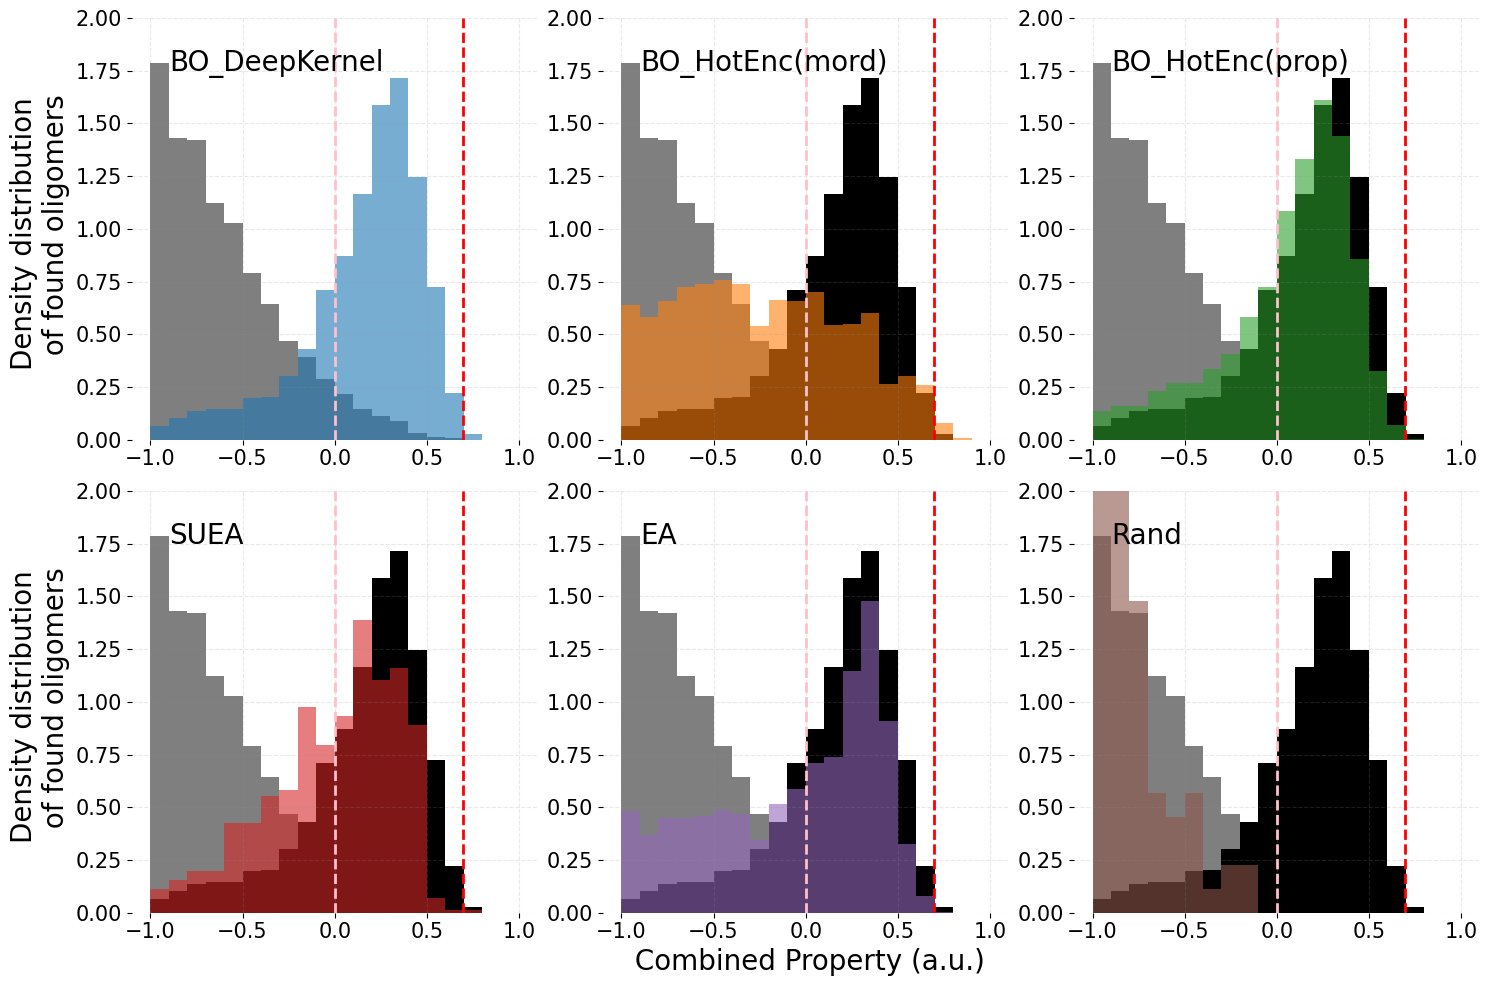

In [14]:
#df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_plot = df_summary_1.copy()
#df_plot = df_plot.iloc[[0,2,3,4,6,7]]
#legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_plot = df_plot
legend_list = ['BO_DeepKernel', 'BO_HotEnc(mord)','BO_HotEnc(prop)','SUEA','EA','Rand']#'BO_DK','BO_DK new','SU EA','SU_EA New'
fig,ax = plt.subplots(2,3,figsize=(15,10))
numb_of_new_calc, numb_of_new_top_calc, rate_of_discovery, numb_of_mol_better = {}, {}, {}, {}
ax= ax.flatten()

min_target = 0#df_Benchmark[target].sort_values(ascending=False).iloc[int(df_Benchmark.shape[0]*0.01)]
range_res = (-1,1)
alpha = 0.5
for test_name in test_names[:1]:
    df_plot = df_summary_1[df_summary_1['test_name']==test_name].copy()
    color_list = sns.color_palette("tab10", len(df_plot))
    df_plot["color"] = color_list
    df_max_found_dict = {}
    df_results_dict = {}
    keys = df_plot["key"]
    print(" keys :", keys)
    alpha =alpha + 0.1
    for i,key in enumerate(keys.values):
        res = results_dict[key]
        color = df_plot[df_plot["key"] == key]["color"].iloc[0]


        metric_dict = {}


        df_results, df_max_found = Search_results_plot.get_df_max_target_found(
            res,
            max_iteration=500,
            df_total=df_total_new,
            num_initialisation=300,
            target_name=target,

            min_target=min_target,
        )

        df_results_new = df_results[~df_results['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_total_new_new = df_total_new[~df_total_new['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_Benchmark.hist(target,bins=20,ax=ax[i],color='black',alpha=0.5,range=range_res,density= True)
        if i >0:
            df_results_dict[key_org].hist(target,bins=20,ax=ax[i],color='black',alpha=1,range=range_res,density= True)
        else:
            key_org = key
            #df_results_new.hist(target,bins=20,ax=ax[i],label=key,color='black',alpha=1,range=range_res,density= True)
        df_results_new.hist(target,bins=20,ax=ax[i],label=key,color=color,alpha=alpha,range=range_res,density= True)
        df_max_found_dict[key] = df_max_found
        df_results_dict[key] = df_results_new
        print(' number of new calculations',df_results_new.shape[0],' number of new oligomers in top ',df_max_found.shape[0],' for key ',key)
        print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])
        print('max target found',df_max_found[target].max())
        ax[i].set_ylabel("",fontsize=20)
        ax[i].set_xlabel('',fontsize=20)
        ax[i].tick_params(axis='x', labelsize=15)
        ax[i].tick_params(axis='y', labelsize=15)

        numb_of_new_calc[key] = df_results_new.shape[0]
        numb_of_new_top_calc[key] = df_max_found.shape[0]
        numb_of_mol_better[key] = df_max_found[df_max_found[target]>df_Benchmark[target].max()].shape[0]
        rate_of_discovery[key] = df_max_found.shape[0]/df_results.shape[0]
        ax[i].vlines(df_Benchmark[target].max(),0,2,linestyles='dashed',colors='red',label='max target found in benchmark')
        ax[i].vlines(min_target,0,2,linestyles='dashed',colors='pink',label='1% of benchmark')
        ax[i].set_title('')
        ax[i].tick_params(axis='x', labelsize=15,color='black',labelcolor='black')
        ax[i].tick_params(axis='y', labelsize=15,color='black',labelcolor='black')
        #ax[i].set_ylim(0,1100)
        
    ax[0].set_ylabel("Density distribution \n of found oligomers",fontsize=20,color='black')
    ax[3].set_ylabel("Density distribution \n of found oligomers",fontsize=20,color='black')

    ax[4].set_xlabel(' Combined Property (a.u.)',fontsize=20,color='black')
    
    fig.tight_layout()
    for i in range(len(legend_list)):
        #ax[i].set_xlim(-1,1)
        ax[i].set_ylim(0,2)
        ax[i].text(-0.9,1.75,legend_list[i],fontsize=20,color='black')


In [16]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
color_list = sns.color_palette("tab10", len(df_plot))
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax=ax.flatten()
counter = 0
for key,df in df_results_dict.items():
    _ax = ax[counter]
    sns.histplot(data=df, x=f'ids_acquired',color=color_list[counter],ax=_ax,bins=20,binrange=(300,500))    
    #_ax.set_ylim(-3,1)
    _ax.set_title( key.split('*')[:2])
    _ax.set_xlabel(f'Building block cluster')
    _ax.set_ylabel(f'Target property (a.u.)')
    fig.tight_layout()
    counter +=1


NameError: name 'df_plot' is not defined

In [17]:
df_result_search = pd.DataFrame.from_records([numb_of_new_calc,numb_of_new_top_calc,rate_of_discovery,numb_of_mol_better]).T
df_result_search.columns = ['numb_of_new_calc','numb_of_new_top_calc','rate_of_discovery','num_mol_better']
df_result_search['key'] = df_result_search.index
df_result_search['case'] = df_result_search['key'].apply(lambda x: x.split('*')[0])
df_result_search['num_mol_training'] = df_result_search['key'].apply(lambda x: x.split('nummol')[-1])
df_result_search['which_acquisition'] = df_result_search['key'].apply(lambda x: x.split('*')[2])
df_result_search.to_csv('data/output/search_experiment/df_result_search_6_mers_240520.csv')

NameError: name 'numb_of_new_calc' is not defined

 keys : 1     BO_learned_new*selected*EI*/rds/general/user/m...
3     BO_precursor*all*EI**data/output/Full_dataset/...
5     BO_precursor*selected*EI**data/output/Full_dat...
7     ea_surrogate_new*selected*EI*/rds/general/user...
9     evolution_algorithm*selected*EI**data/output/F...
11    random*selected*EI**data/output/Full_dataset/5...
Name: key, dtype: object
 number of new calculations 841  number of new oligomers in top  458  for key  BO_learned_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240520//SchNet/Full_data/*data/output/Full_dataset/58K_200524.csv*data/output/Prescursor_data/precursor_data_new_clustering.pkl*2nd_test_58K_dataset_full
rate of discovery 0.5407319952774499
max target found 0.9030242671071979


NameError: name 'numb_of_new_calc' is not defined

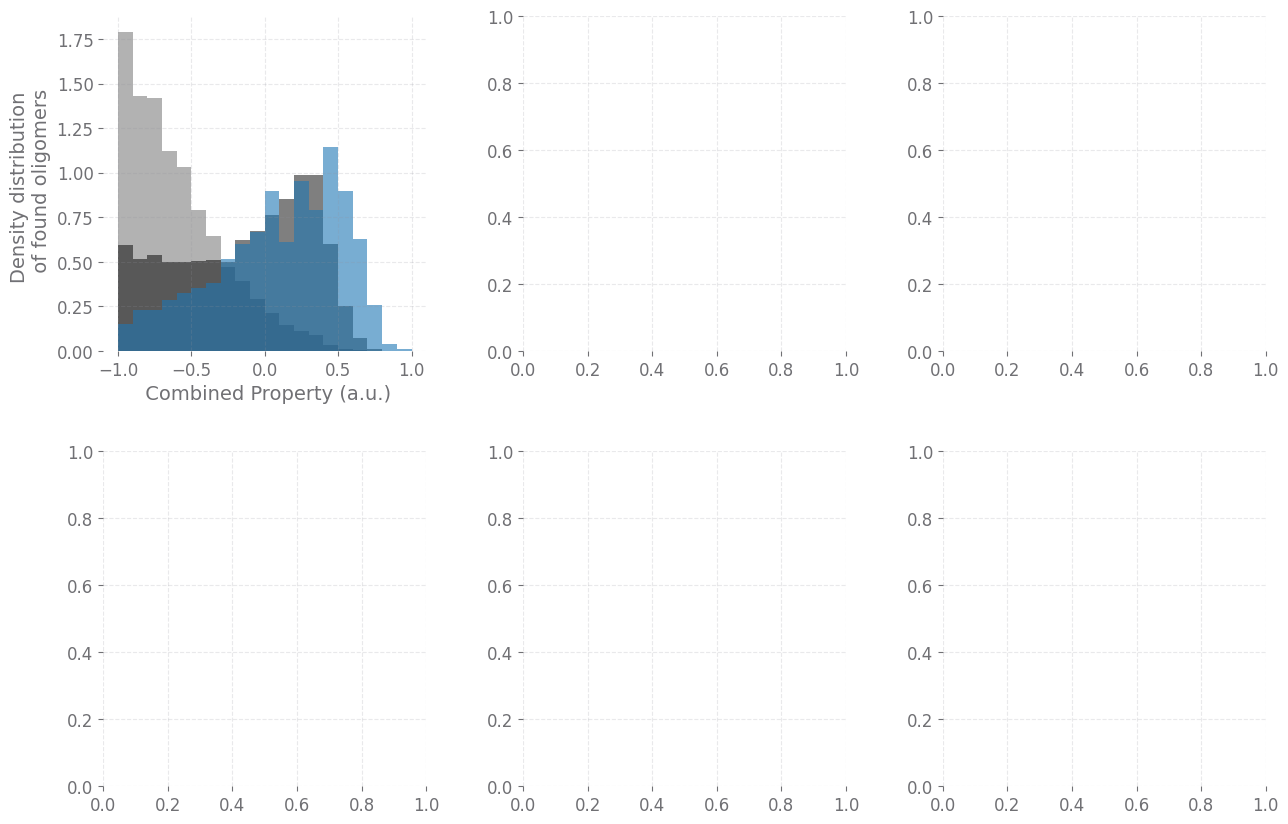

In [18]:
#df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_plot = df_summary_1.copy()
#df_plot = df_plot.iloc[[0,2,3,4,6,7]]
#legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_total_1st , df_precursors= database_utils.load_data_from_file(df_total_1st_search, df_precursor_path,add_feature_frag=True)

df_plot = df_plot
legend_list = ['BO_DeepKernel', 'BO_HotEnc(mord)','BO_HotEnc(prop)','SUEA','EA','Rand']#'BO_DK','BO_DK new','SU EA','SU_EA New'
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax= ax.flatten()

min_target = 0#df_total_1st[target].sort_values(ascending=False).iloc[int(df_total_1st.shape[0]*0.01)]
range_res = (-1,1)
alpha = 0.5
for test_name in test_names[1:]:
    df_plot = df_summary_1[df_summary_1['test_name']==test_name].copy()
    color_list = sns.color_palette("tab10", len(df_plot))
    df_plot["color"] = color_list
    df_max_found_dict = {}
    df_results_dict = {}
    keys = df_plot["key"]
    print(" keys :", keys)
    alpha =alpha + 0.1
    for i,key in enumerate(keys.values):
        res = results_dict[key]
        color = df_plot[df_plot["key"] == key]["color"].iloc[0]


        metric_dict = {}


        df_results, df_max_found = Search_results_plot.get_df_max_target_found(
            res,
            max_iteration=500,
            df_total=df_total_new,
            num_initialisation=300,
            target_name=target,

            min_target=min_target,
        )

        df_results_new = df_results[~df_results['InChIKey'].isin(df_total_1st['InChIKey'])]
        df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_total_1st['InChIKey'])]
        df_total_new_new = df_total_new[~df_total_new['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_total_1st.hist(target,bins=20,ax=ax[i],color='black',alpha=0.5,range=range_res,density= True)
        df_Benchmark.hist(target,bins=20,ax=ax[i],color='black',alpha=0.3,range=range_res,density= True)

        if i >0:
            df_results_dict[key_org].hist(target,bins=20,ax=ax[i],color='black',alpha=1,range=range_res,density= True)
        else:
            key_org = key
            #df_results_new.hist(target,bins=20,ax=ax[i],label=key,color='black',alpha=1,range=range_res,density= True)
        df_results_new.hist(target,bins=20,ax=ax[i],label=key,color=color,alpha=alpha,range=range_res,density= True)
        df_max_found_dict[key] = df_max_found
        df_results_dict[key] = df_results_new
        print(' number of new calculations',df_results_new.shape[0],' number of new oligomers in top ',df_max_found.shape[0],' for key ',key)
        print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])
        print('max target found',df_max_found[target].max())
        ax[i].set_ylabel("Density distribution \n of found oligomers")
        ax[i].set_xlabel(' Combined Property (a.u.)')

        ax[i].set_title('')
        numb_of_new_calc[key] = df_results_new.shape[0]
        numb_of_new_top_calc[key] = df_max_found.shape[0]
        numb_of_mol_better[key] = df_max_found[df_max_found[target]>df_total_1st[target].max()].shape[0]
        rate_of_discovery[key] = df_max_found.shape[0]/df_results.shape[0]
        #ax[i].set_ylim(0,1100)
        ax[i].set_ylabel("",fontsize=20)
        ax[i].set_xlabel('',fontsize=20)
        ax[i].vlines(df_total_1st[target].max(),0,2,linestyles='dashed',colors='red',label='max target found in benchmark')
        ax[i].vlines(min_target,0,2,linestyles='dashed',colors='pink',label='1% of benchmark')
        ax[i].tick_params(axis='x', labelsize=15,color='black',labelcolor='black')
        ax[i].tick_params(axis='y', labelsize=15,color='black',labelcolor='black')
        #ax[i].set_ylim(0,1100)
        
    ax[0].set_ylabel("Density distribution \n of found oligomers",fontsize=20,color='black')
    ax[3].set_ylabel("Density distribution \n of found oligomers",fontsize=20,color='black')

    ax[4].set_xlabel(' Combined Property (a.u.)',fontsize=20,color='black')
    
    fig.tight_layout()
    for i in range(len(legend_list)):
        #ax[i].set_xlim(-1,1)
        ax[i].set_ylim(0,2)
        ax[i].text(-0.9,1.75,legend_list[i],fontsize=20,color='black')




In [ ]:
df_result_search = pd.DataFrame.from_records([numb_of_new_calc,numb_of_new_top_calc,rate_of_discovery,numb_of_mol_better]).T
df_result_search.columns = ['numb_of_new_calc','numb_of_new_top_calc','rate_of_discovery','num_mol_better']
df_result_search['key'] = df_result_search.index
df_result_search['case'] = df_result_search['key'].apply(lambda x: x.split('*')[0])
df_result_search['num_mol_training'] = df_result_search['key'].apply(lambda x: x.split('nummol')[-1])
df_result_search['which_acquisition'] = df_result_search['key'].apply(lambda x: x.split('*')[2])
df_result_search.to_csv('data/output/search_experiment/df_result_search_6_mers_240520_2nd_trial.csv')
df_result_search

numb_of_new_calc  \
BO_learned_new*selected*EI*/rds/general/user/ma...            2096.0   
BO_precursor*all*EI**data/output/Full_dataset/3...            2675.0   
BO_precursor*selected*EI**data/output/Full_data...            3868.0   
ea_surrogate_new*selected*EI*/rds/general/user/...             722.0   
evolution_algorithm*selected*EI**data/output/Fu...            3614.0   
random*selected*EI**data/output/Full_dataset/30...            2887.0   
BO_learned_new*selected*EI*/rds/general/user/ma...             841.0   
BO_precursor*all*EI**data/output/Full_dataset/5...            1273.0   
BO_precursor*selected*EI**data/output/Full_data...            1799.0   
ea_surrogate_new*selected*EI*/rds/general/user/...            1037.0   
evolution_algorithm*selected*EI**data/output/Fu...            1637.0   
random*selected*EI**data/output/Full_dataset/58...            1236.0   

                                                    numb_of_new_top_calc  \
BO_learned_new*selected*EI*/rds/general/user/ma...                1439.0   
BO_precursor*all*EI**data/output/Full_dataset/3...                 535.0   
BO_precursor*selected*EI**data/output/Full_data...                2336.0   
ea_surrogate_new*selected*EI*/rds/general/user/...                 394.0   
evolution_algorithm*selected*EI**data/output/Fu...                1146.0   
random*selected*EI**data/output/Full_dataset/30...                   0.0   
BO_learned_new*selected*EI*/rds/general/user/ma...                 458.0   
BO_precursor*all*EI**data/output/Full_dataset/5...                 406.0   
BO_precursor*selected*EI**data/output/Full_data...                 893.0   
ea_surrogate_new*selected*EI*/rds/general/user/...                1004.0   
evolution_algorithm*selected*EI**data/output/Fu...                 544.0   
random*selected*EI**data/output/Full_dataset/58...                   0.0   

                                                    rate_of_discovery  \
BO_learned_new*selected*EI*/rds/general/user/ma...           0.685565   
BO_precursor*all*EI**data/output/Full_dataset/3...           0.199925   
BO_precursor*selected*EI**data/output/Full_data...           0.603774   
ea_surrogate_new*selected*EI*/rds/general/user/...           0.543448   
evolution_algorithm*selected*EI**data/output/Fu...           0.316400   
random*selected*EI**data/output/Full_dataset/30...           0.000000   
BO_learned_new*selected*EI*/rds/general/user/ma...           0.540732   
BO_precursor*all*EI**data/output/Full_dataset/5...           0.307576   
BO_precursor*selected*EI**data/output/Full_data...           0.495286   
ea_surrogate_new*selected*EI*/rds/general/user/...           0.861063   
evolution_algorithm*selected*EI**data/output/Fu...           0.323810   
random*selected*EI**data/output/Full_dataset/58...           0.000000   

                                                    num_mol_better  \
BO_learned_new*selected*EI*/rds/general/user/ma...             8.0   
BO_precursor*all*EI**data/output/Full_dataset/3...            16.0   
BO_precursor*selected*EI**data/output/Full_data...             1.0   
ea_surrogate_new*selected*EI*/rds/general/user/...             1.0   
evolution_algorithm*selected*EI**data/output/Fu...             1.0   
random*selected*EI**data/output/Full_dataset/30...             0.0   
BO_learned_new*selected*EI*/rds/general/user/ma...             4.0   
BO_precursor*all*EI**data/output/Full_dataset/5...             5.0   
BO_precursor*selected*EI**data/output/Full_data...             2.0   
ea_surrogate_new*selected*EI*/rds/general/user/...             1.0   
evolution_algorithm*selected*EI**data/output/Fu...             7.0   
random*selected*EI**data/output/Full_dataset/58...             0.0   

                                                                                                  key  \
BO_learned_new*selected*EI*/rds/general/user/ma...  BO_learned_new*selected*EI*/rds/general/user/m...   
BO_precursor*all*EI**data/output/Full_dataset/3...  BO_

In [19]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
color_list = sns.color_palette("tab10", len(df_plot))
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax=ax.flatten()
counter = 0
for key,df in df_results_dict.items():
    _ax = ax[counter]
    sns.histplot(data=df, x=f'ids_acquired',color=color_list[counter],ax=_ax,bins=20,binrange=(300,500))    
    #_ax.set_ylim(-3,1)
    #_ax.set_title( key.split('*')[:2])
    _ax.set_xlabel(f'Number of iterations')
    _ax.set_ylabel(f'Number of oligomers found')
    fig.tight_layout()
    counter +=1
for i in range(len(legend_list)):
    ax[i].set_ylim(0,400)
    ax[i].text(350,200,legend_list[i],fontsize=20,color='black')


ValueError: Image size of 317817x978 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2000x1000 with 6 Axes>

/var/tmp/pbs.9556003.pbs/ipykernel_860179/134389767.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_calc_min'] = df['time_calc'].apply(lambda x: x.to_numpy()/ np.timedelta64(1, 's')/60)


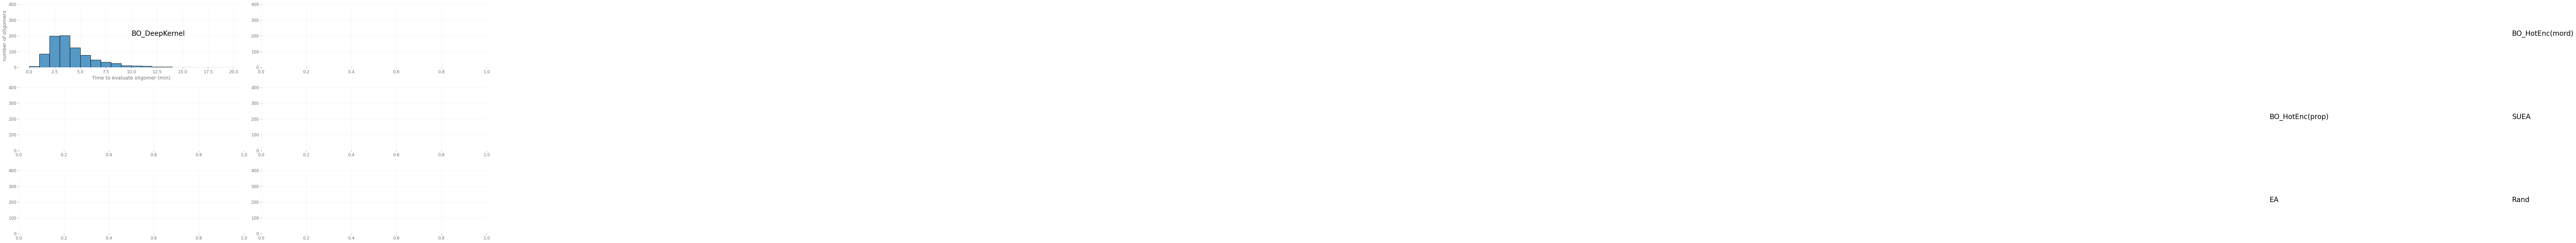

In [20]:

df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
color_list = sns.color_palette("tab10", len(df_plot))
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax=ax.flatten()
counter = 0
for key,df in df_results_dict.items():
    _ax = ax[counter]
    df['time_calc_min'] = df['time_calc'].apply(lambda x: x.to_numpy()/ np.timedelta64(1, 's')/60)
    sns.histplot(data=df, x=f'time_calc_min',color=color_list[counter],ax=_ax,bins=20,binrange=(0,20))    
    #_ax.set_ylim(-3,1)
    #_ax.set_title( key.split('*')[:2])
    _ax.set_xlabel(f'Time to evaluate oligomer (min)')
    _ax.set_ylabel(f'number of oligomers')
    fig.tight_layout()
    counter +=1
fig.tight_layout()
for i in range(len(legend_list)):
    ax[i].set_ylim(0,400)
    ax[i].text(10,200,legend_list[i],fontsize=20,color='black')


/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['time_calc_xtb'] = df_results['time_calc'].apply(lambda x: x.to_numpy()/ np.timedelta64(1, 's')/60)
/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['time_calc_min'] = df_results['overall_time'].apply(lambda x: (x.to_numpy()-inti_point)/ np.timedelta64(1, 's')/3600)
/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:43: 

 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
2     BO_precursor*all*EI**data/output/Full_dataset/...
4     BO_precursor*selected*EI**data/output/Full_dat...
6     ea_surrogate_new*selected*EI*/rds/general/user...
8     evolution_algorithm*selected*EI**data/output/F...
10    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object


/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['time_calc_xtb'] = df_results['time_calc'].apply(lambda x: x.to_numpy()/ np.timedelta64(1, 's')/60)
/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['time_calc_min'] = df_results['overall_time'].apply(lambda x: (x.to_numpy()-inti_point)/ np.timedelta64(1, 's')/3600)
/var/tmp/pbs.9496941.pbs/ipykernel_362330/2615093845.py:43: 

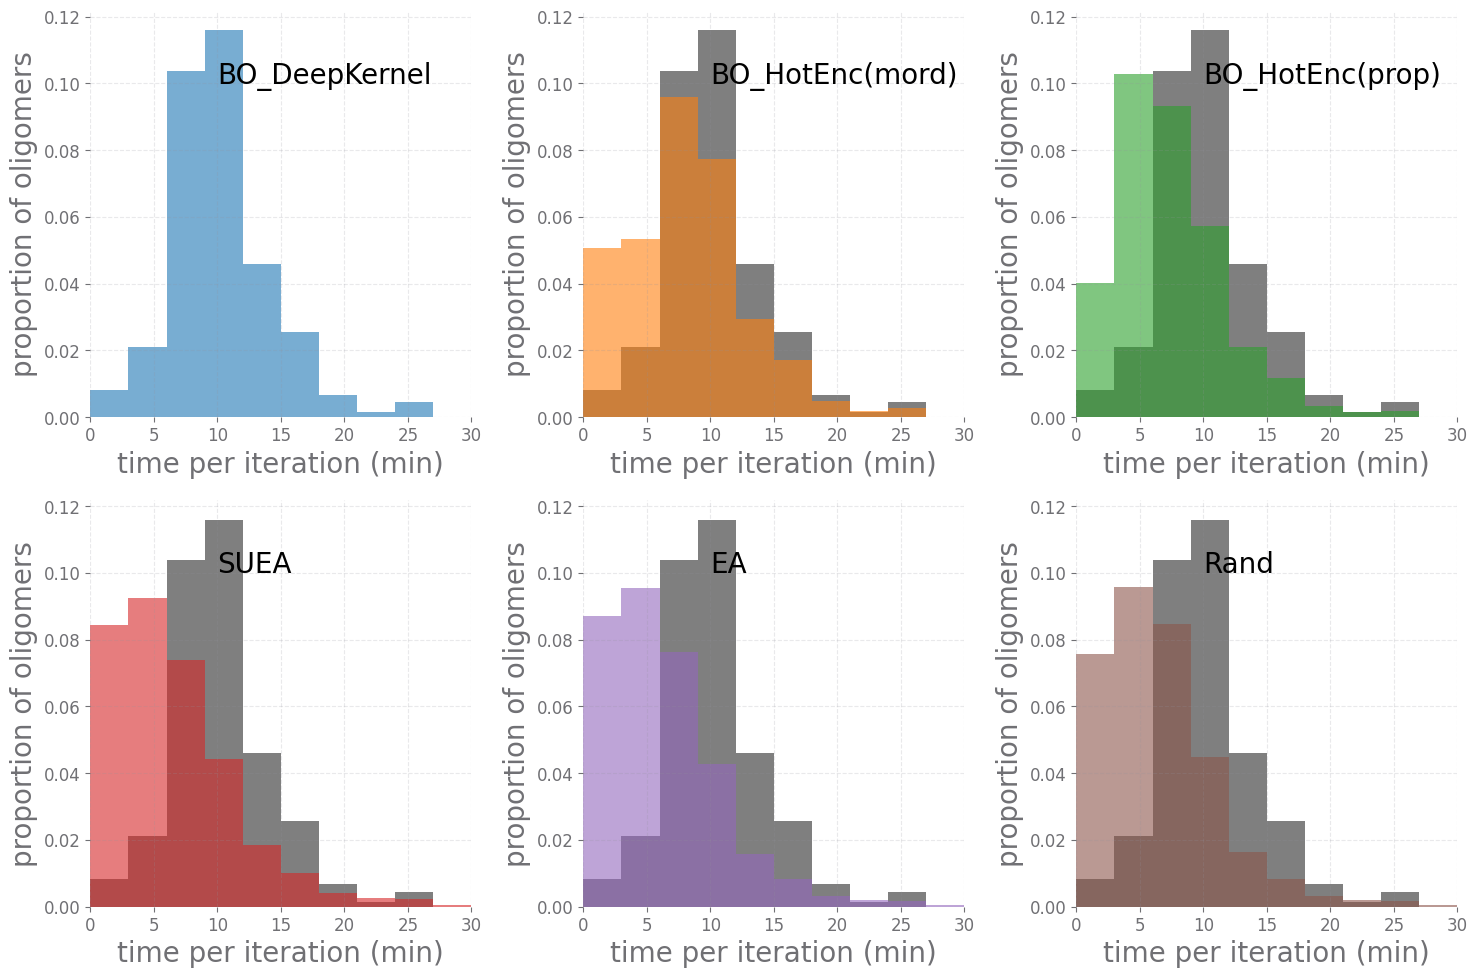

In [37]:
#df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_plot = df_summary_1.copy()
#df_plot = df_plot.iloc[[0,2,3,4,6,7]]
#legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_total_1st , df_precursors= database_utils.load_data_from_file(df_total_1st_search, df_precursor_path,add_feature_frag=True)

df_plot = df_plot
legend_list = ['BO_DeepKernel', 'BO_HotEnc(mord)','BO_HotEnc(prop)','SUEA','EA','Rand']#'BO_DK','BO_DK new','SU EA','SU_EA New'
fig,ax = plt.subplots(2,3,figsize=(15,10))
df_results_list = []
ax= ax.flatten()

alpha = 0.5
for test_name in test_names[:1]:
    df_plot = df_summary_1[df_summary_1['test_name']==test_name].copy()
    color_list = sns.color_palette("tab10", len(df_plot))
    df_plot["color"] = color_list
    keys = df_plot["key"]
    print(" keys :", keys)
    alpha =alpha + 0.1
    for i,key in enumerate(keys.values):
        res = results_dict[key]
        for _res in res[:10]:
            color = df_plot[df_plot["key"] == key]["color"].iloc[0]


            metric_dict = {}


            dict = _res.copy()

            dict.pop("searched_space_df")
            df = pd.DataFrame.from_records(dict)
            df = df[df["ids_acquired"] < 500]
            df_results = df[df["ids_acquired"] >= 300]

            inti_point = df_results.loc[300,'overall_time'].to_numpy()
            df_results['time_calc_xtb'] = df_results['time_calc'].apply(lambda x: x.to_numpy()/ np.timedelta64(1, 's')/60)
            df_results['time_calc_min'] = df_results['overall_time'].apply(lambda x: (x.to_numpy()-inti_point)/ np.timedelta64(1, 's')/3600)
            df_results.sort_values('ids_acquired',ascending=True,inplace=True)
            df_results.reset_index(inplace=True)
            df_results['time_calc_uni'] = df_results['time_calc_min'].values-np.roll(df_results['time_calc_min'].values,1)
            df_results['time_calc_uni'] = df_results['time_calc_uni'].apply(lambda x: x*60 if x>0 else 0)
            #df_results['time_calc_search'] =df_results['time_calc_uni']-df_results['time_calc_xtb']
            #df_results['time_calc_search'] = df_results['time_calc_search'].apply(lambda x: x if x>0 else 0)
            df_results_list.append(df_results)
        df_results = pd.concat(df_results_list)
        if i!=0:

            df_DK['time_calc_uni'].hist(ax=ax[i],color='black',alpha=0.5,range=(0,30),density=True)
        else:
            df_DK = df_results.copy()
        df_results['time_calc_uni'].hist(ax=ax[i],color=color,alpha=alpha,range=(0,30),density=True)

        ax[i].set_title('')
        ax[i].legend().set_visible(False) 
    fig.tight_layout()
    for i in range(len(legend_list)):
        ax[i].set_ylabel('proportion of oligomers',fontsize=20)
        ax[i].set_xlabel('time per iteration (min)',fontsize=20)
        ax[i].set_xlim(0,30)
        ax[i].text(10,0.1,legend_list[i],fontsize=20,color='black')
fig.tight_layout()


 keys : 0     BO_learned_new*selected*EI*/rds/general/user/m...
2     BO_precursor*all*EI**data/output/Full_dataset/...
4     BO_precursor*selected*EI**data/output/Full_dat...
6     ea_surrogate_new*selected*EI*/rds/general/user...
8     evolution_algorithm*selected*EI**data/output/F...
10    random*selected*EI**data/output/Full_dataset/3...
Name: key, dtype: object


 number of new calculations 2096  number of new oligomers in top  1930  for key  BO_learned_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/*data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl*Benchmark_30K_dataset_full
rate of discovery 0.9194854692710814
max target found 0.797750860920192
 number of new calculations 2675  number of new oligomers in top  1796  for key  BO_precursor*all*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl*Benchmark_30K_dataset_full
rate of discovery 0.6711509715994021
max target found 0.8017653000419239
 number of new calculations 3868  number of new oligomers in top  3526  for key  BO_precursor*selected*EI**data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl*Benchmark_30K_dataset_full


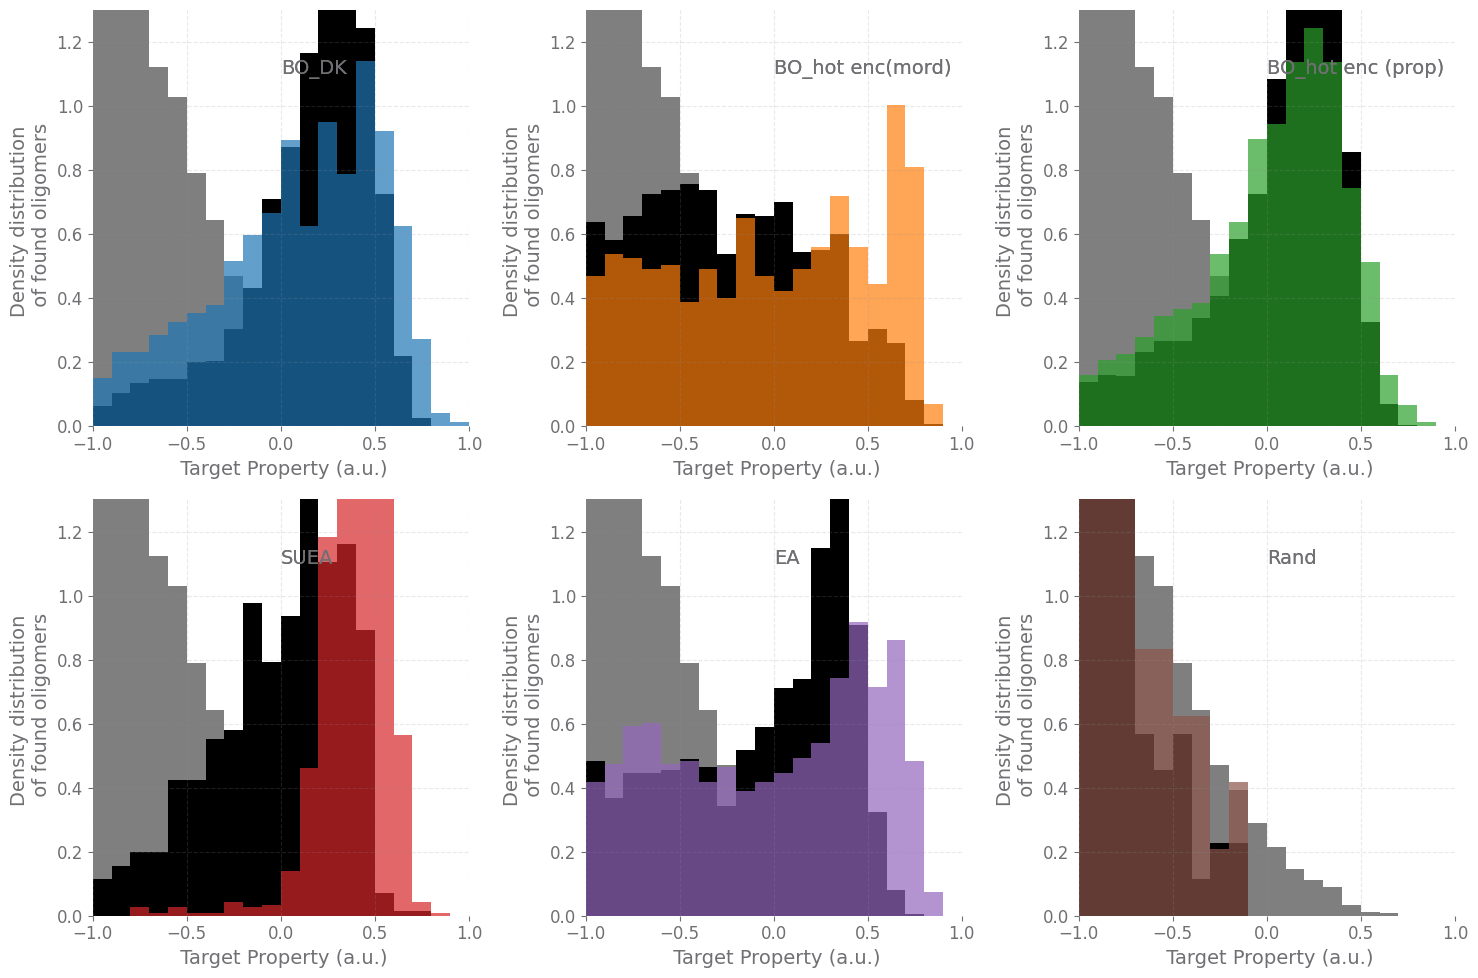

In [23]:
#df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_plot = df_summary_1.copy()
#df_plot = df_plot.iloc[[0,2,3,4,6,7]]
#legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_plot = df_plot
legend_list = [ 'BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SUEA','EA','Rand']
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax= ax.flatten()

min_target = df_Benchmark[target].iloc[int(df_Benchmark.shape[0]*0.01)]
range_res = (-1,1)
alpha = 0.5
for test_name in test_names:
    df_plot = df_summary_1[df_summary_1['test_name']==test_name].copy()
    color_list = sns.color_palette("tab10", len(df_plot))
    df_plot["color"] = color_list
    df_max_found_dict = {}
    df_results_dict = {}
    keys = df_plot["key"]
    print(" keys :", keys)
    alpha =alpha + 0.1
    for i,key in enumerate(keys.values):
        res = results_dict[key]
        color = df_plot[df_plot["key"] == key]["color"].iloc[0]


        metric_dict = {}


        df_results, df_max_found = Search_results_plot.get_df_max_target_found(
            res,
            max_iteration=500,
            df_total=df_total_new,
            num_initialisation=300,
            target_name=target,

            min_target=min_target,
        )

        df_results_new = df_results[~df_results['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_Benchmark['InChIKey'])]
        df_total_new_new = df_total_new[~df_total_new['InChIKey'].isin(df_Benchmark['InChIKey'])]
        if alpha ==0.6:
            df_Benchmark.hist(target,bins=20,ax=ax[i],color='black',alpha=0.5,range=range_res,density= True)
            #df_total_new_new.hist(target,bins=20,ax=ax[i],color='black',alpha=1,range=range_res,density= True)
            df_results_new.hist(target,bins=20,ax=ax[i],label=key,color='black',alpha=1,range=range_res,density= True)
        else:
            df_results_new.hist(target,bins=20,ax=ax[i],label=key,color=color,alpha=alpha,range=range_res,density= True)
        df_max_found_dict[key] = df_max_found
        df_results_dict[key] = df_results_new
        print(' number of new calculations',df_results_new.shape[0],' number of new oligomers in top ',df_max_found.shape[0],' for key ',key)
        print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])
        print('max target found',df_max_found[target].max())
        ax[i].set_ylabel("Density distribution \n of found oligomers")
        ax[i].set_xlabel(' Target Property (a.u.)')

        ax[i].set_title('')
        #ax[i].set_ylim(0,1100)
        

    fig.tight_layout()
    for i in range(len(legend_list)):
        ax[i].set_xlim(-1,1)
        ax[i].set_ylim(0,1.3)
        ax[i].text(-0,1.1,legend_list[i])



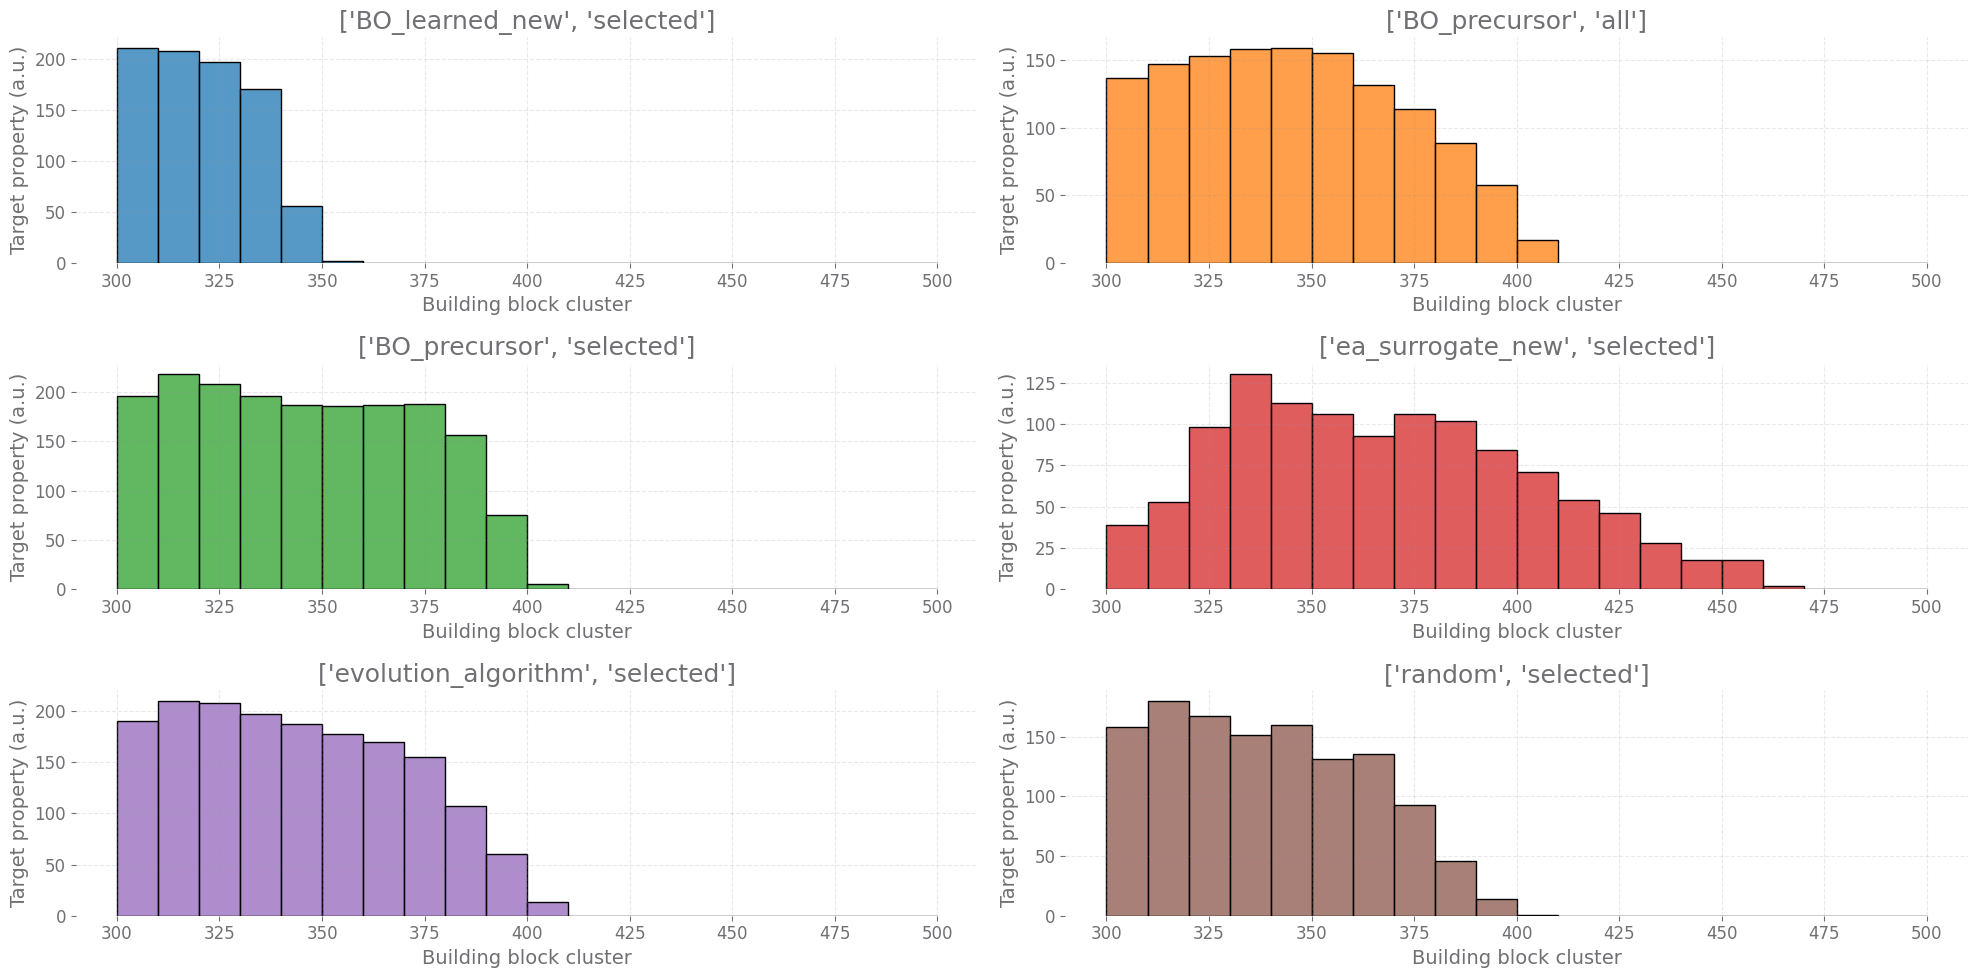

In [24]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
color_list = sns.color_palette("tab10", len(df_plot))
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax=ax.flatten()
counter = 0
for key,df in df_results_dict.items():
    _ax = ax[counter]
    sns.histplot(data=df, x=f'ids_acquired',color=color_list[counter],ax=_ax,bins=20,binrange=(300,500))    
    #_ax.set_ylim(-3,1)
    _ax.set_title( key.split('*')[:2])
    _ax.set_xlabel(f'Building block cluster')
    _ax.set_ylabel(f'Target property (a.u.)')
    fig.tight_layout()
    counter +=1


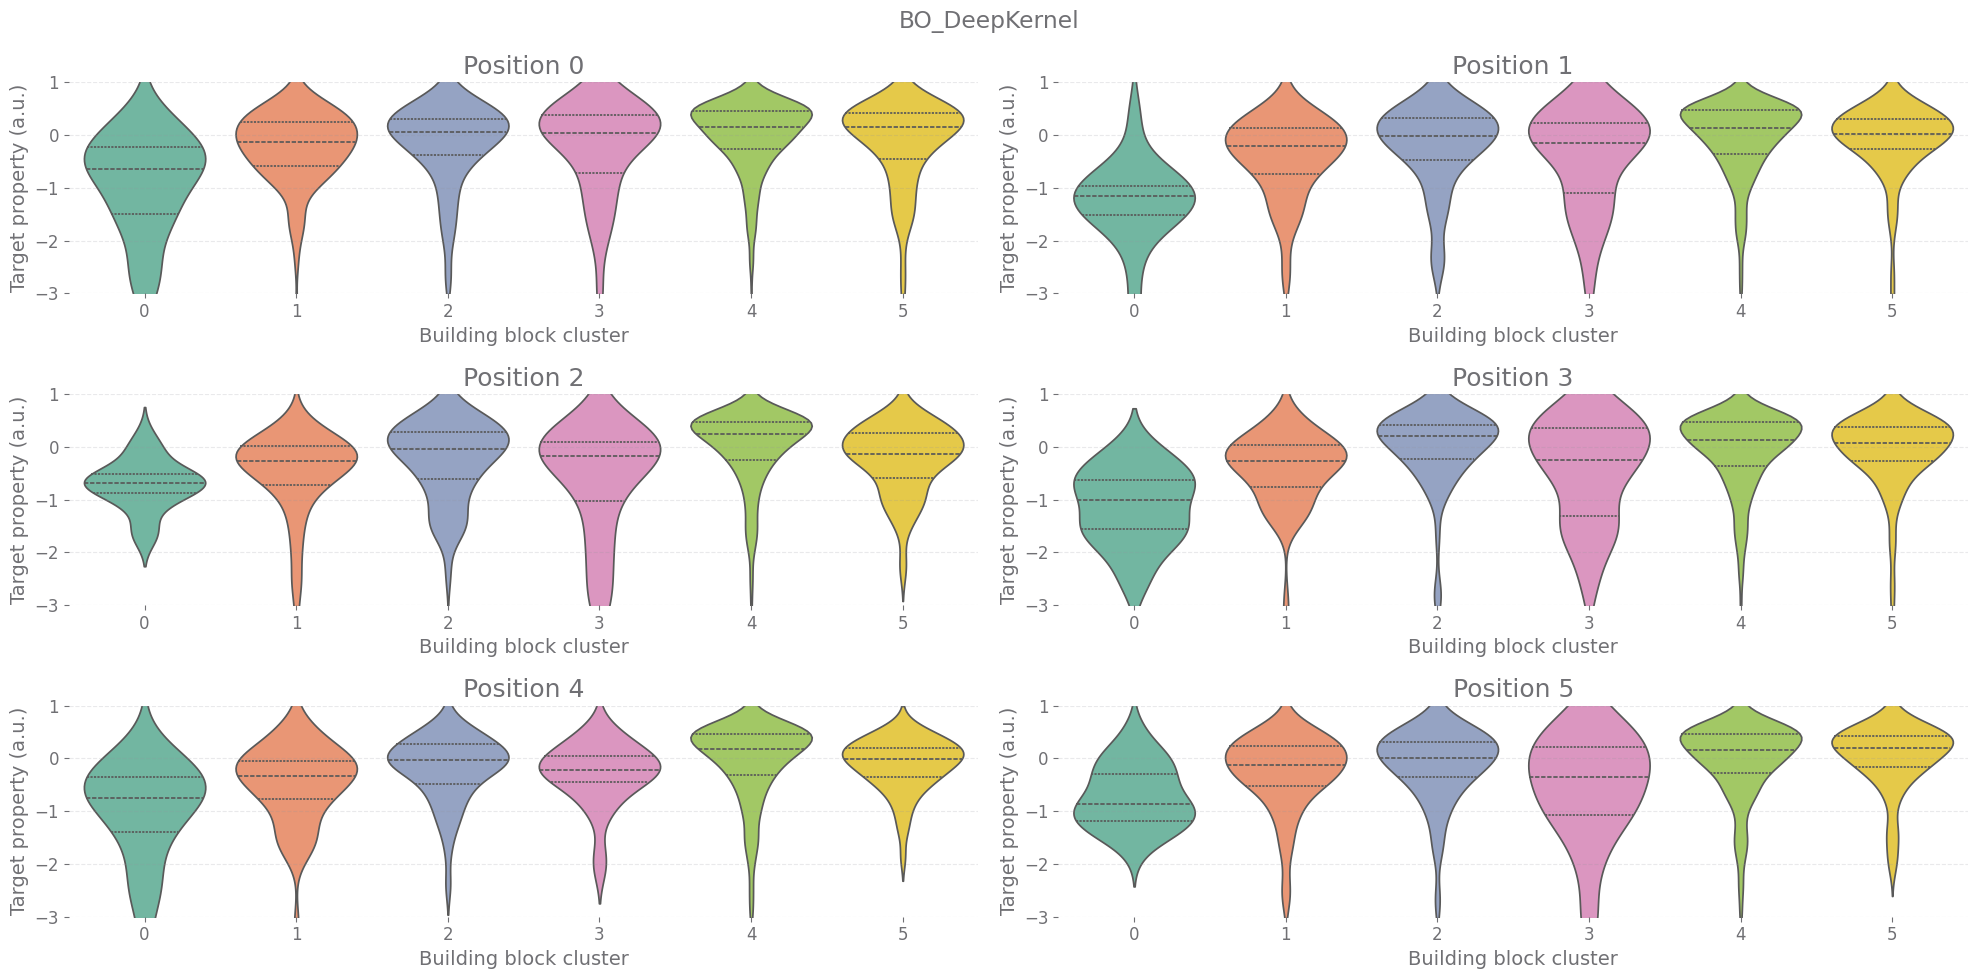

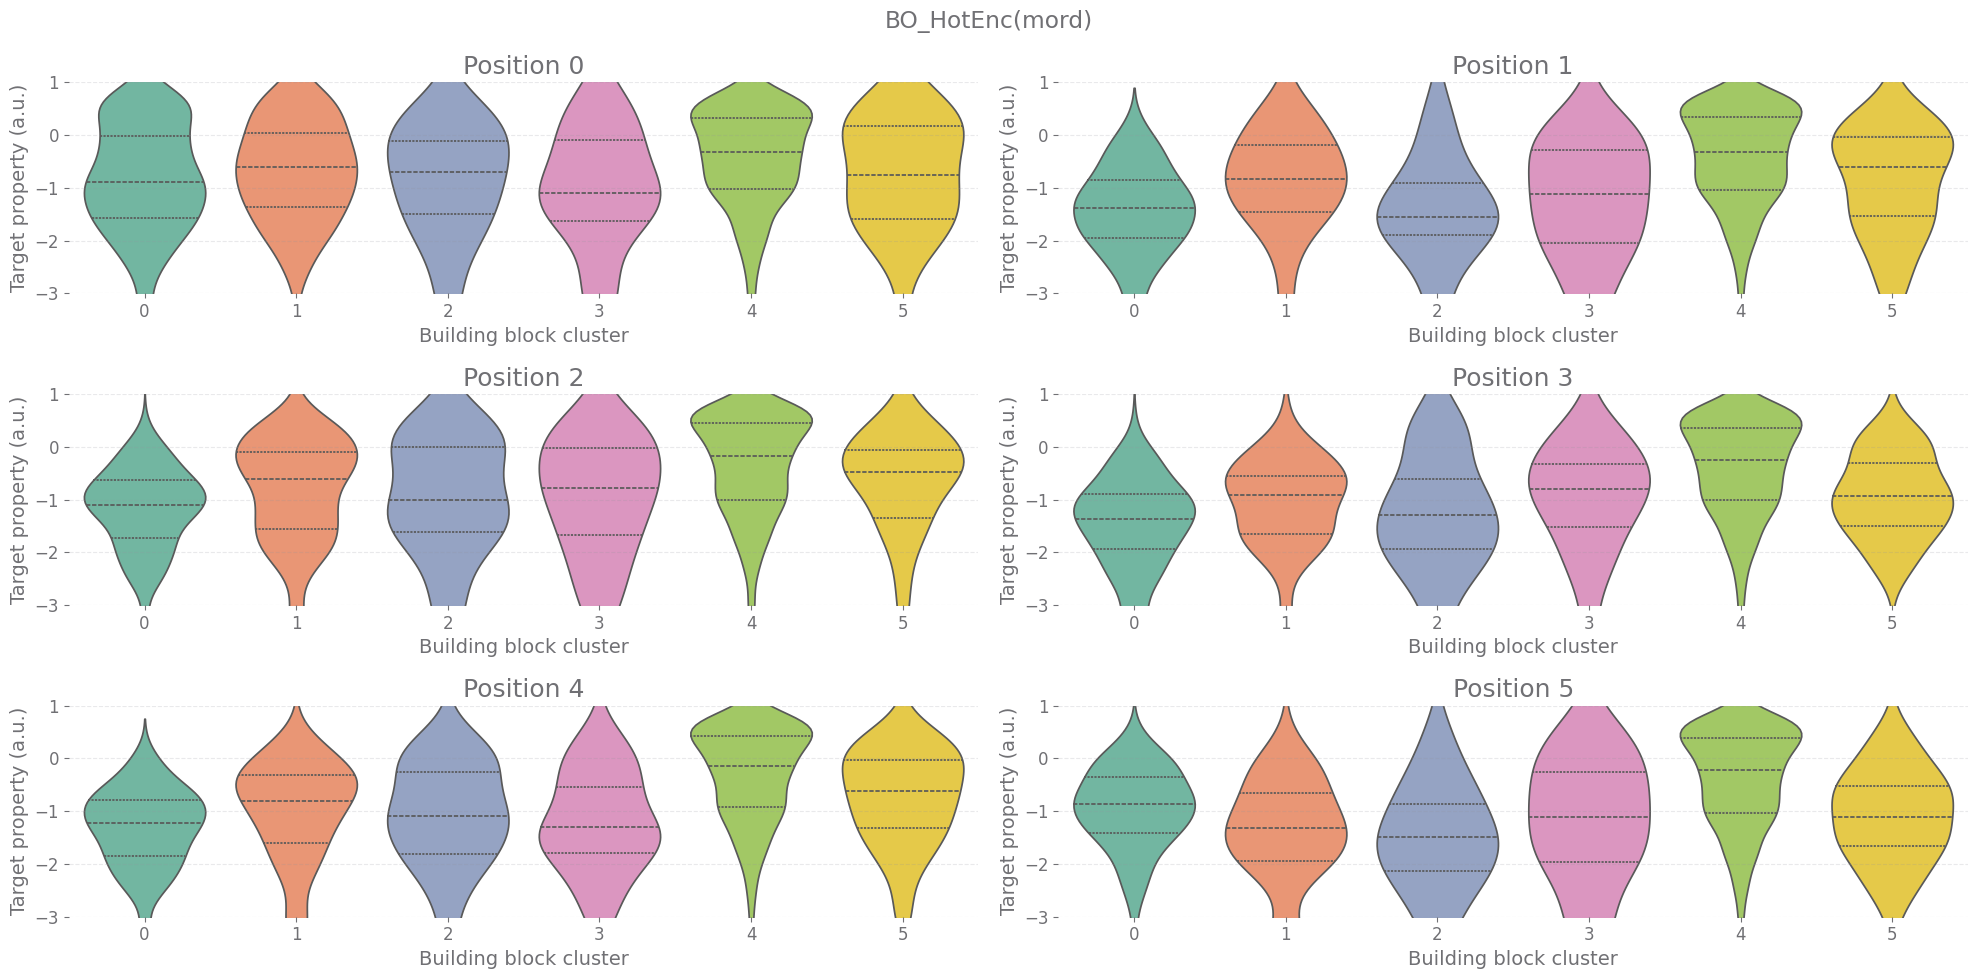

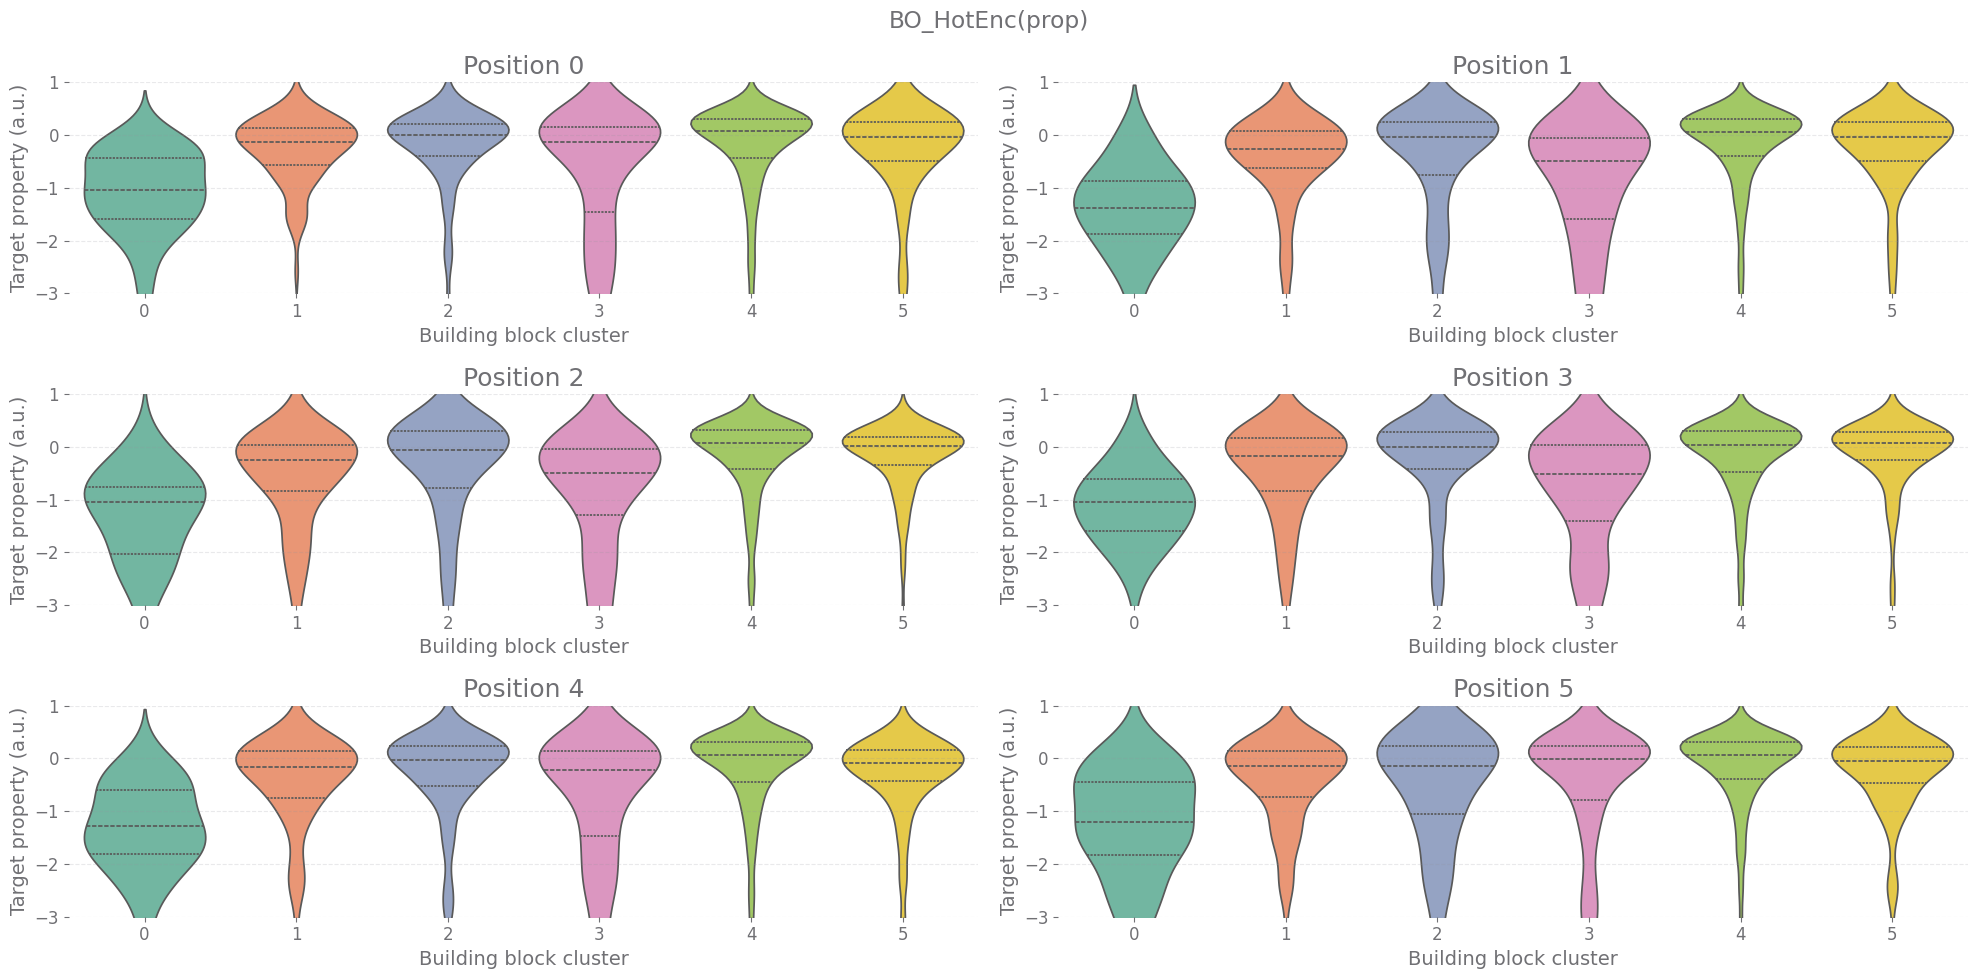

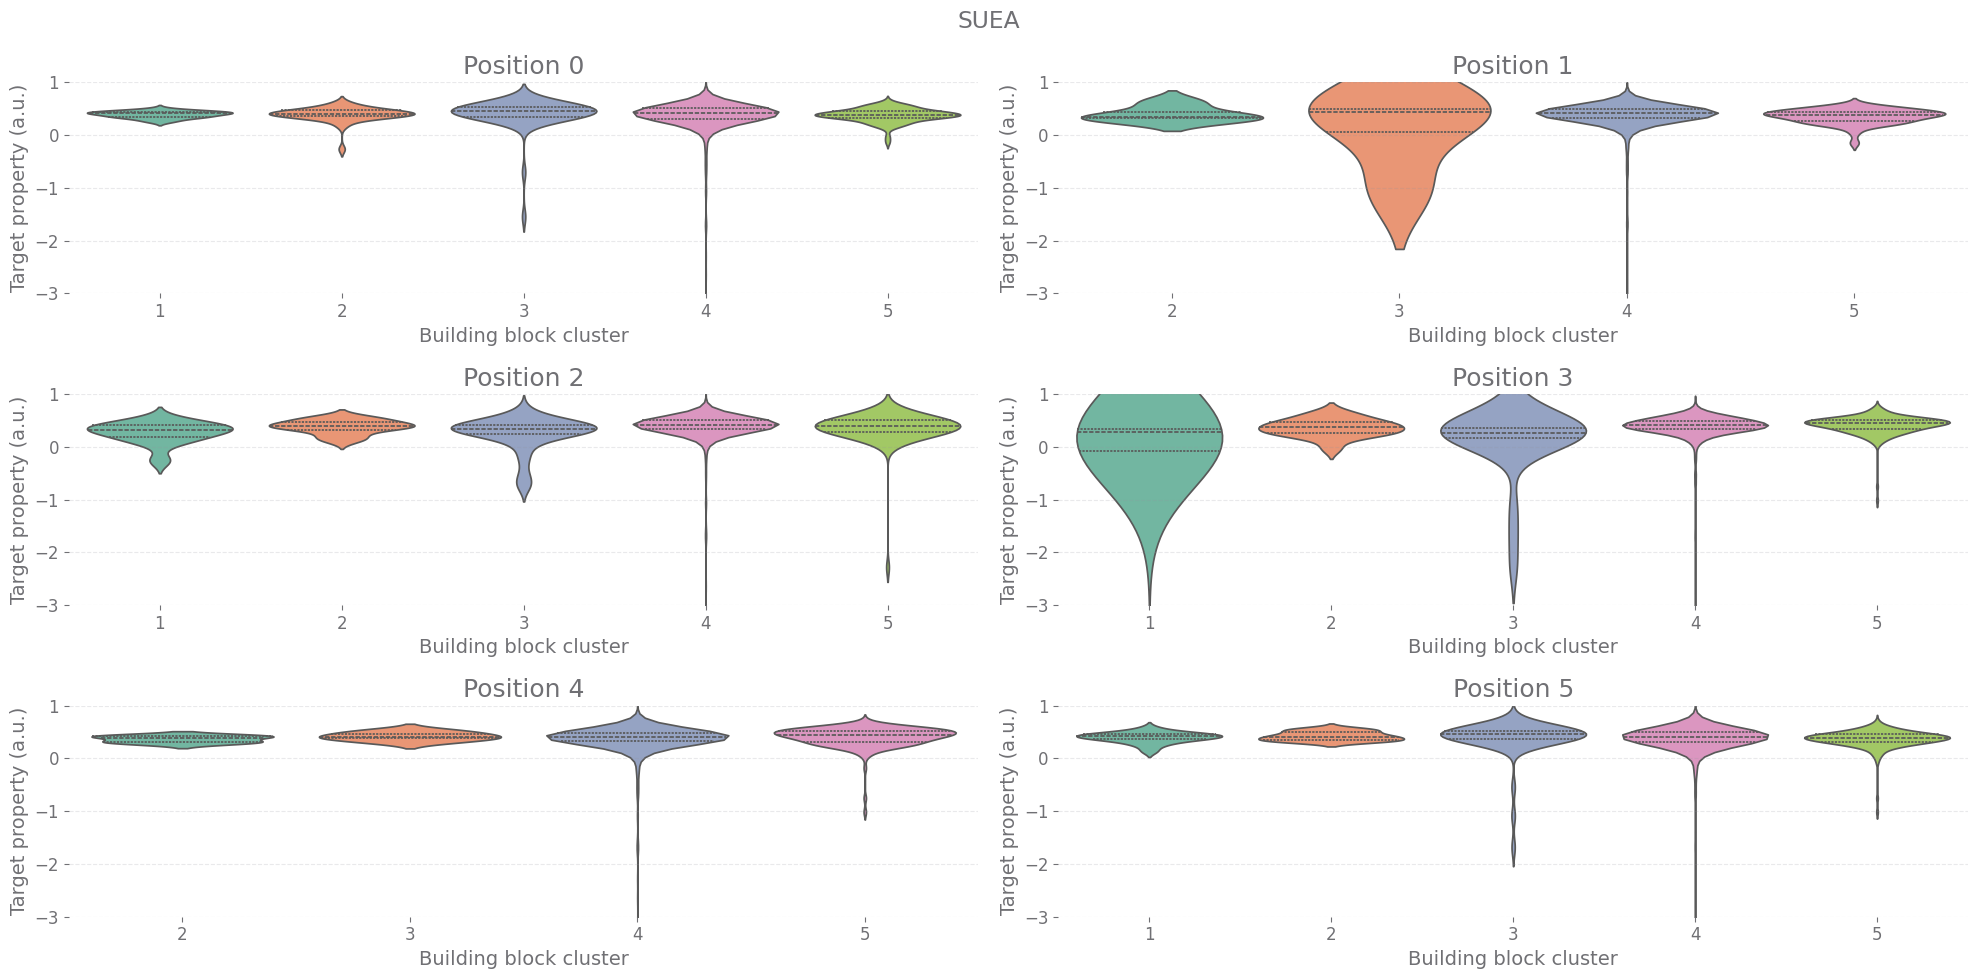

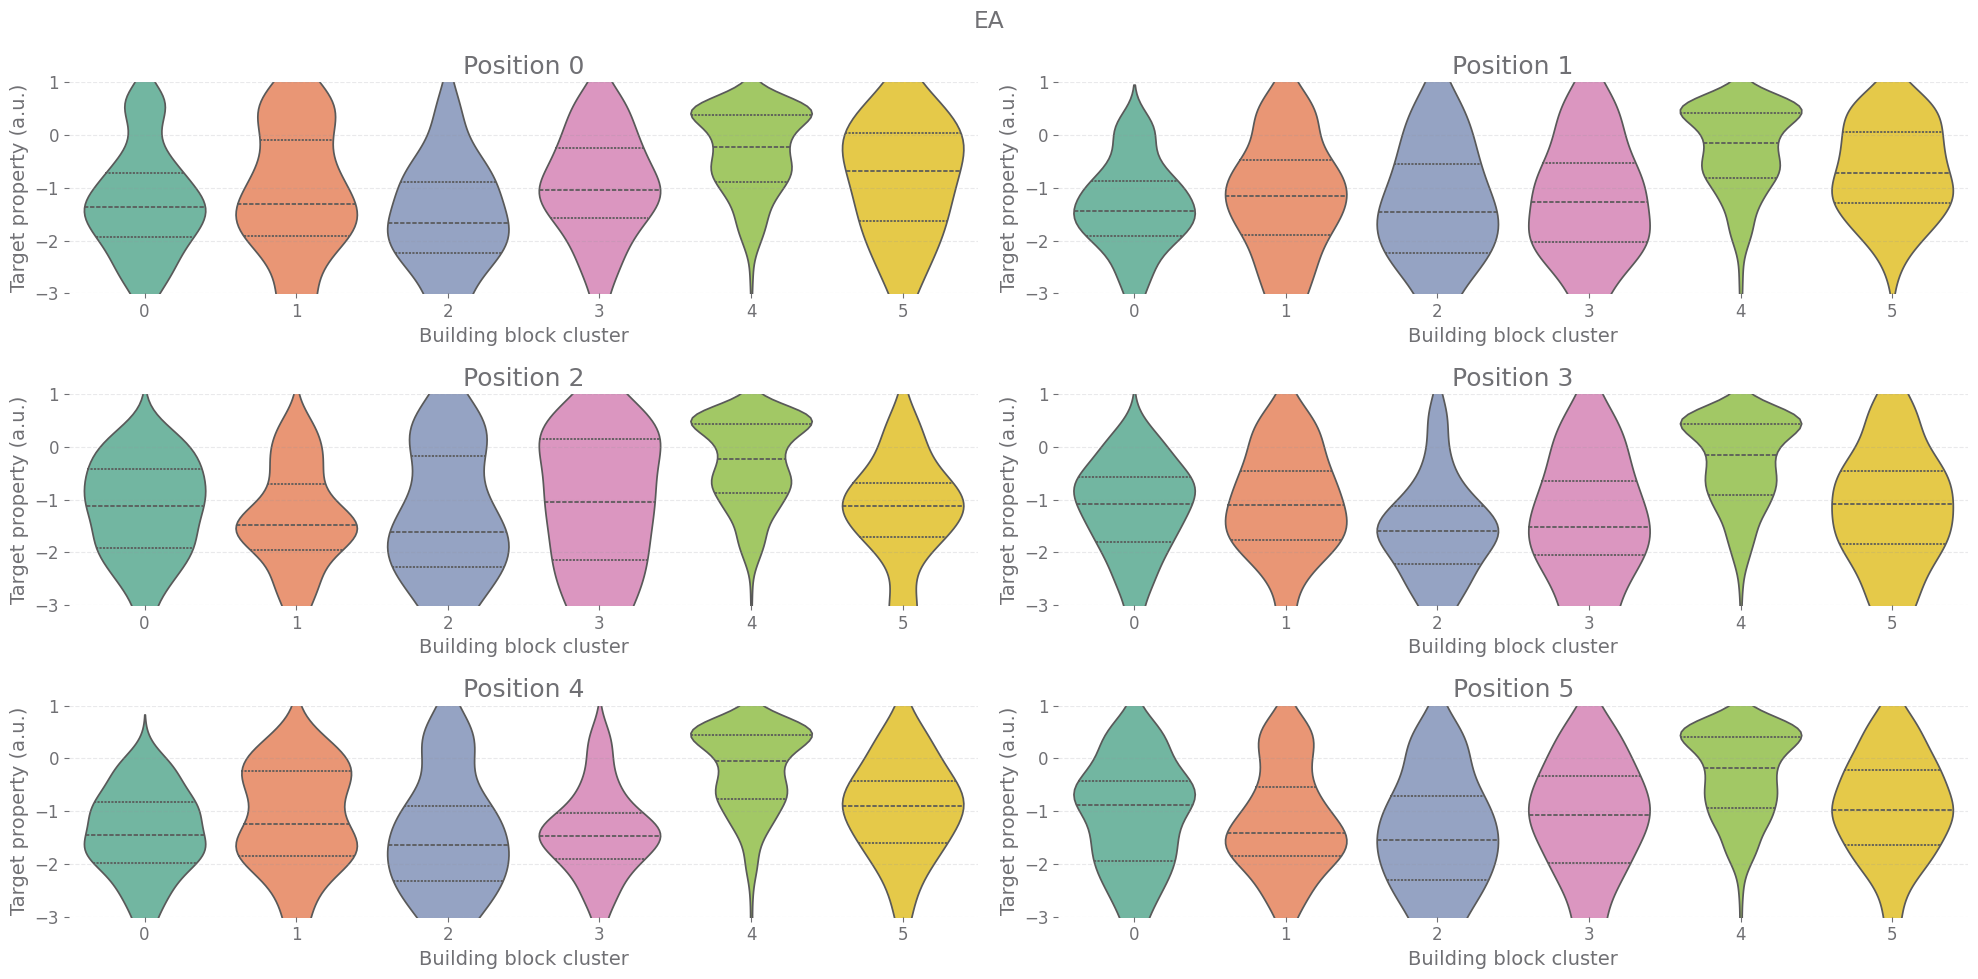

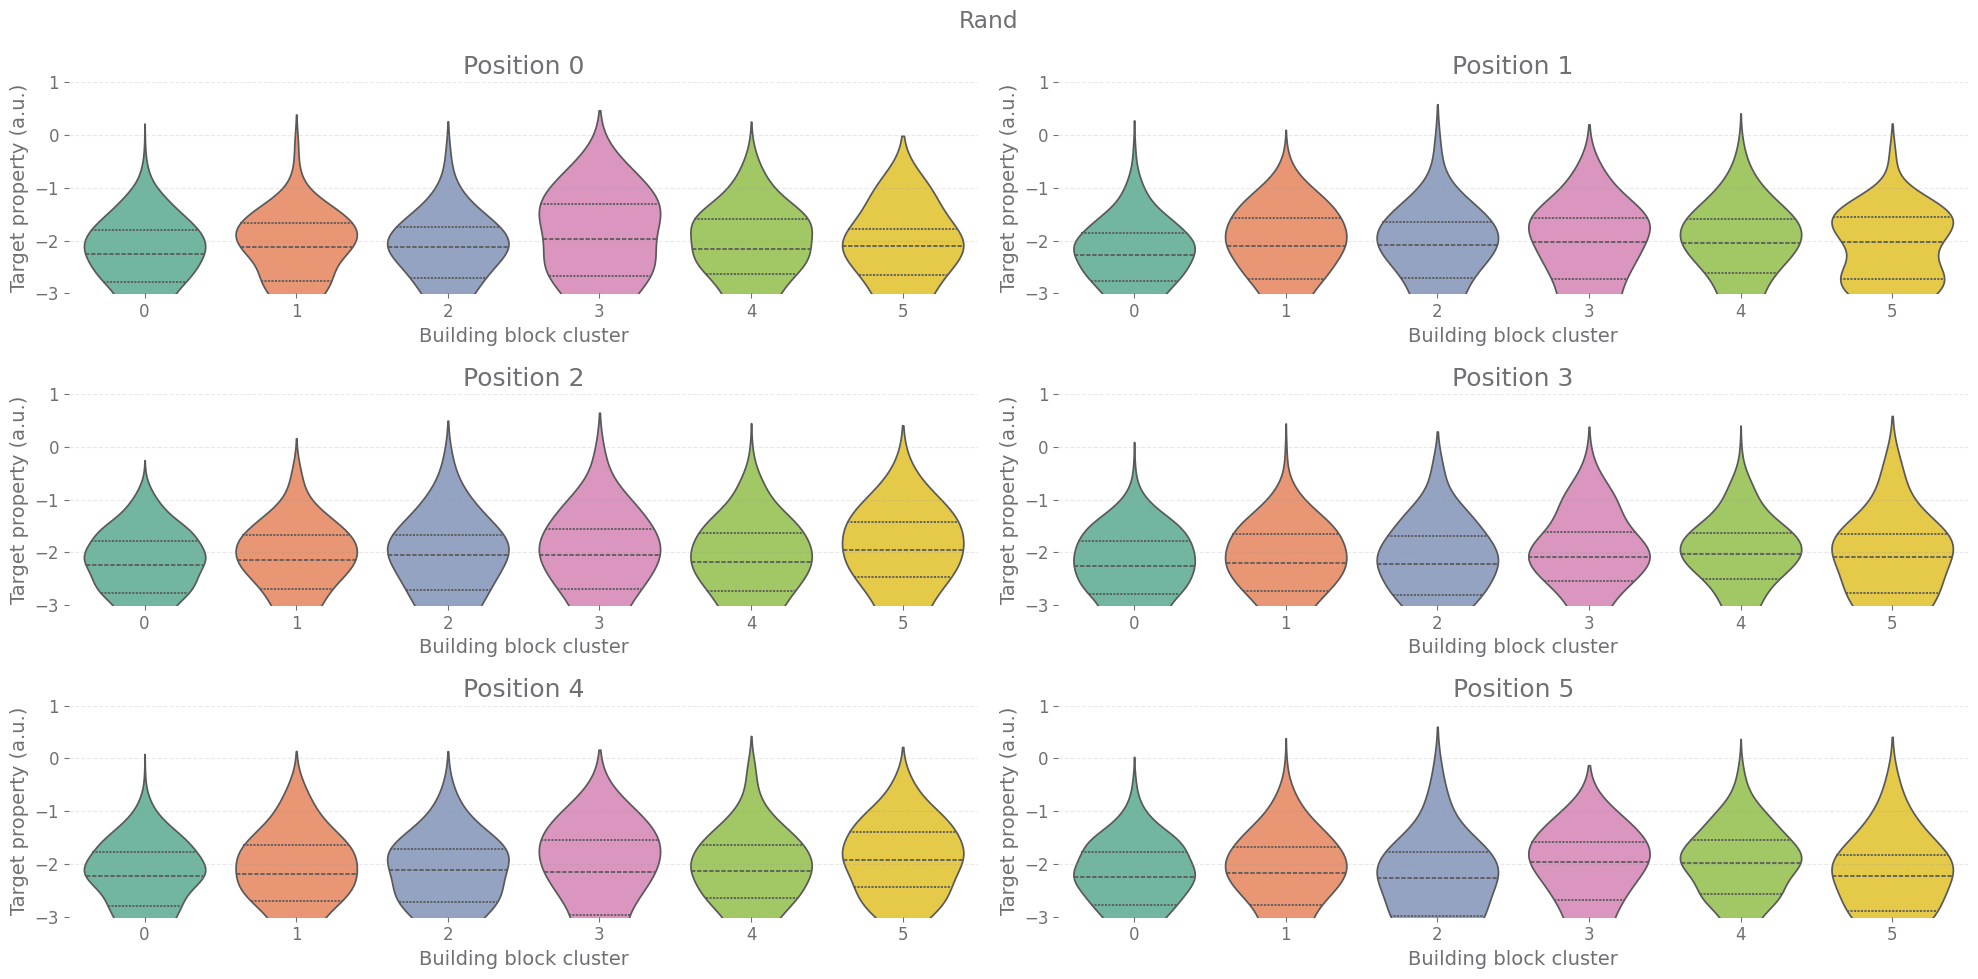

In [44]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
def plot_violin_cluster (df,title):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    import seaborn as sns
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.violinplot(data=df_plot, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        _ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Target property (a.u.)')
    fig.suptitle(title)
    fig.tight_layout()
counter = 0
for key,df in df_results_dict.items():
    plot_violin_cluster(df,title =legend_list[counter])
    counter +=1

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  d

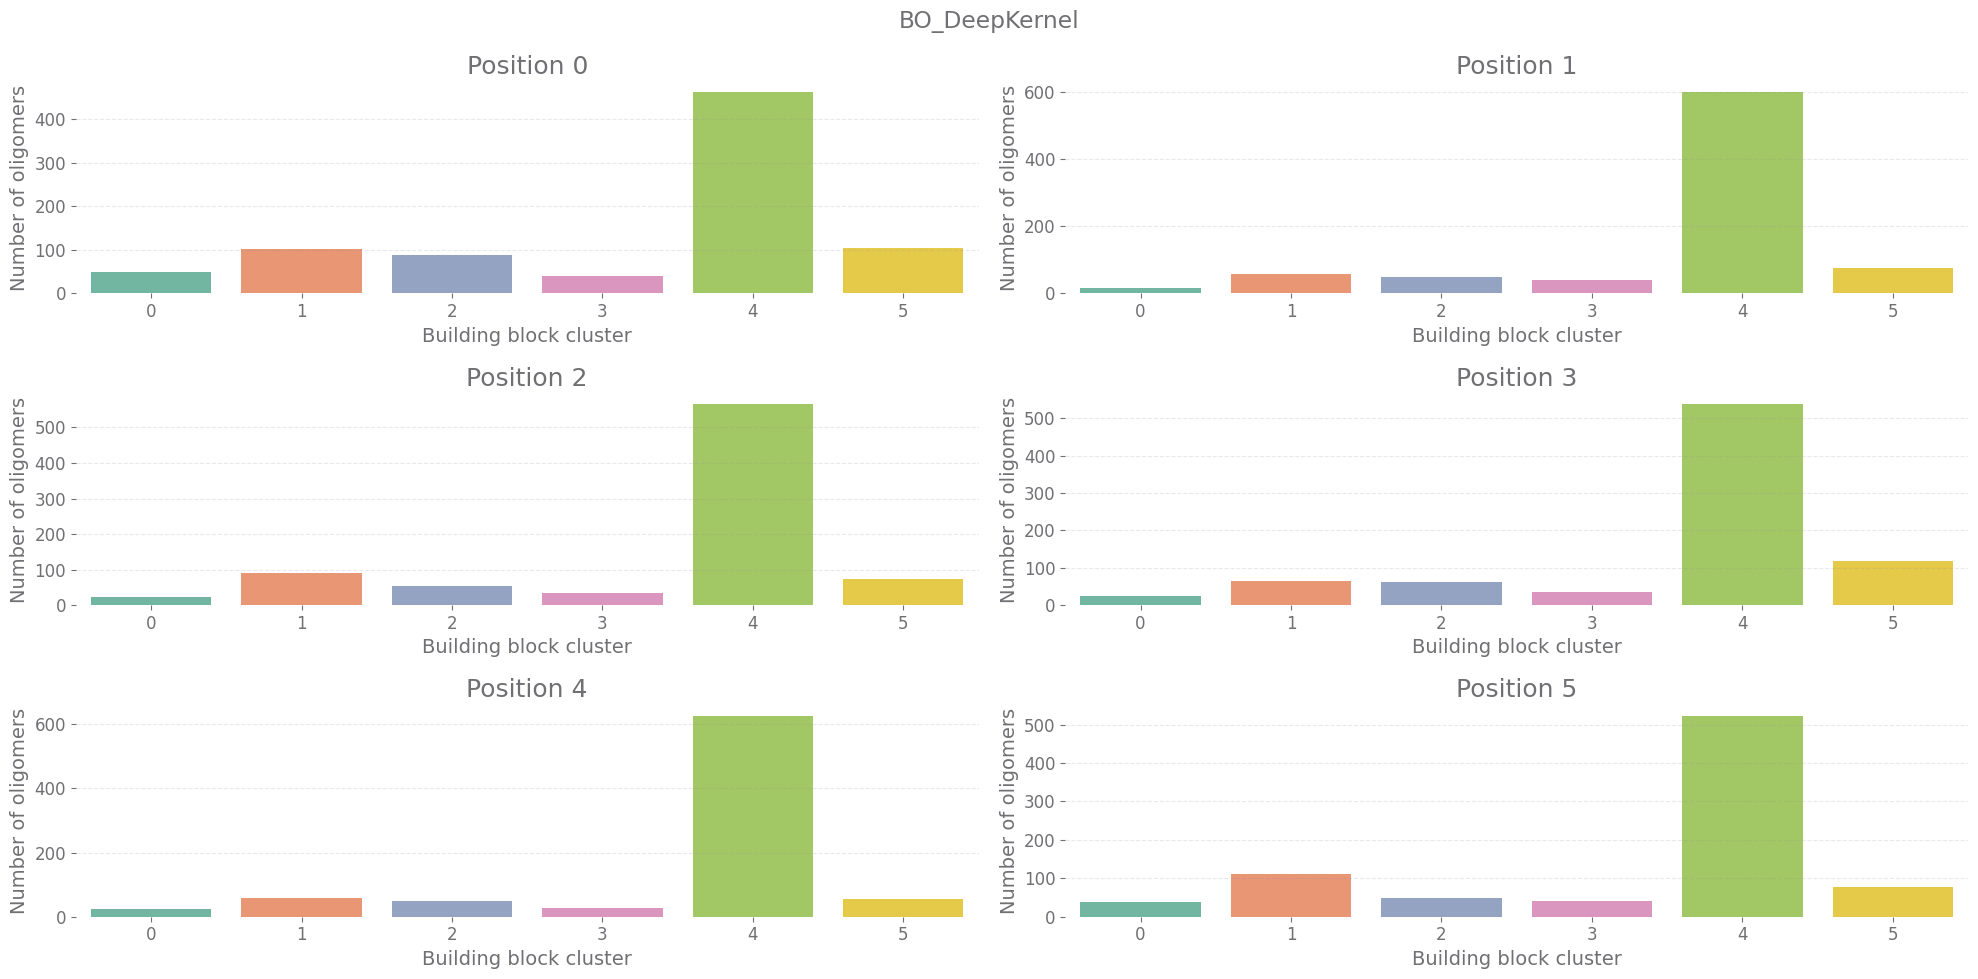

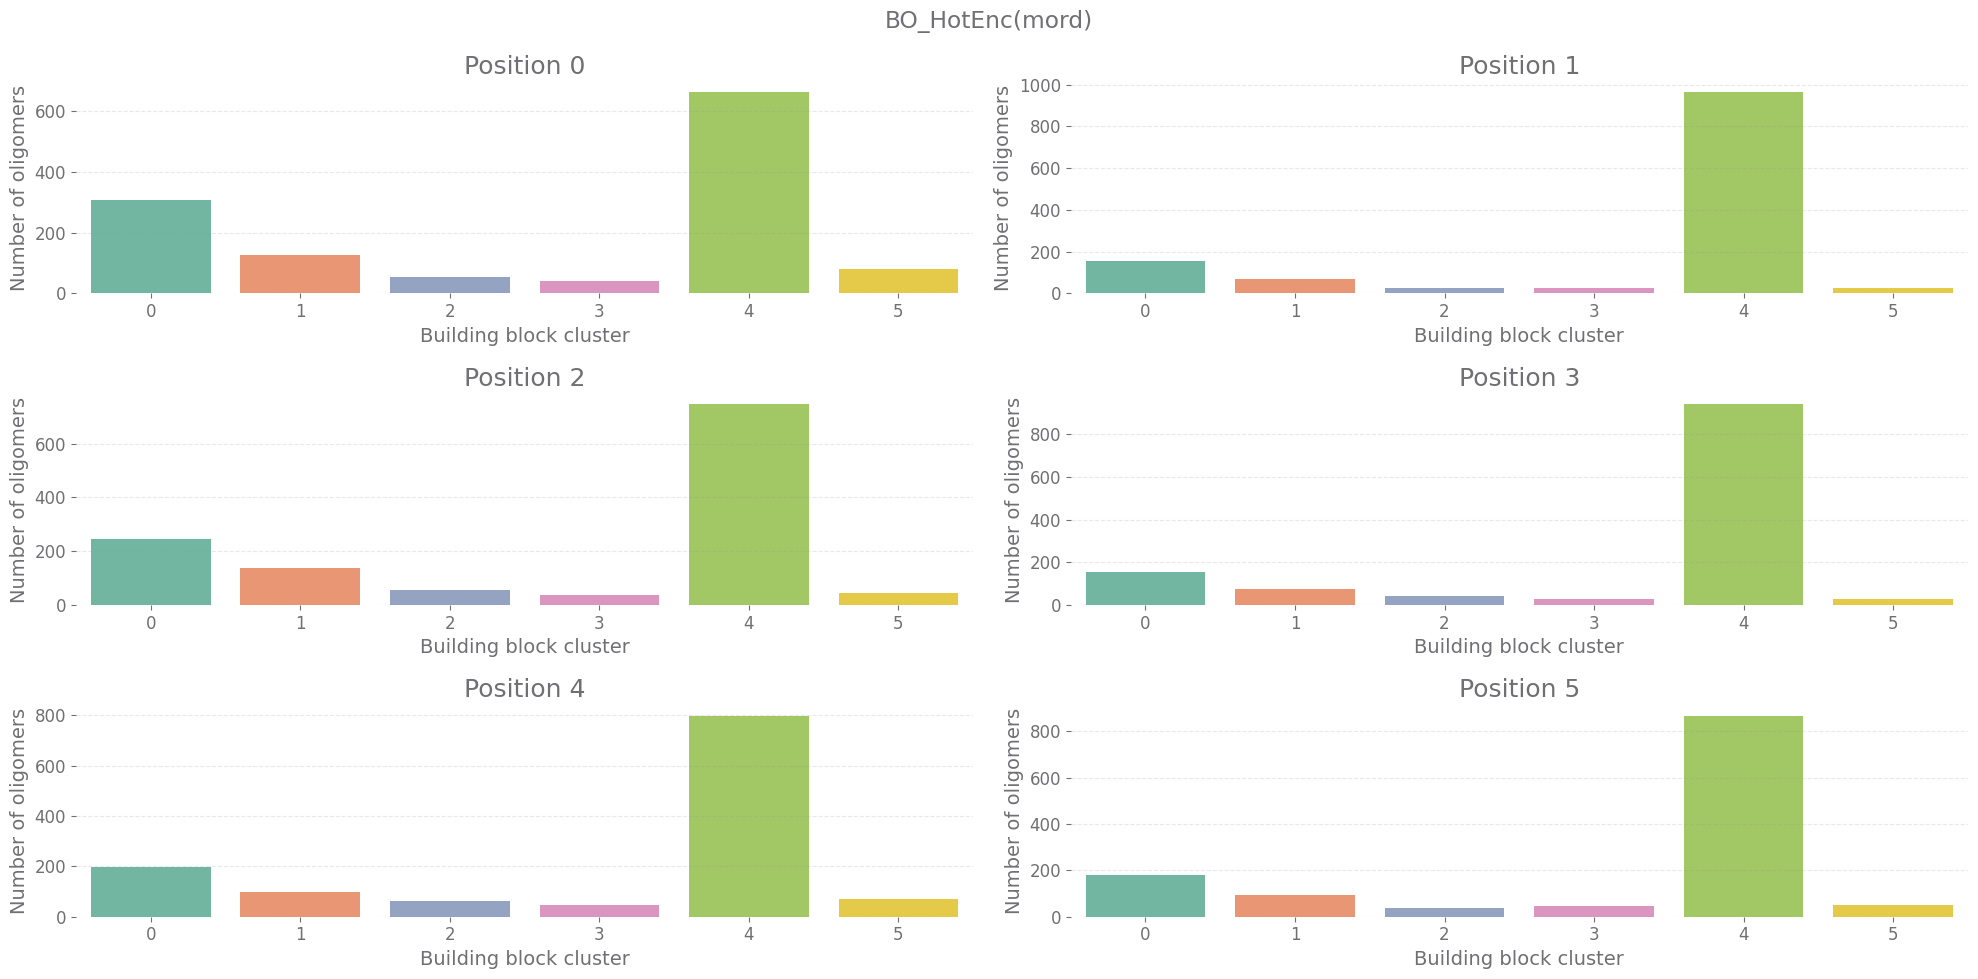

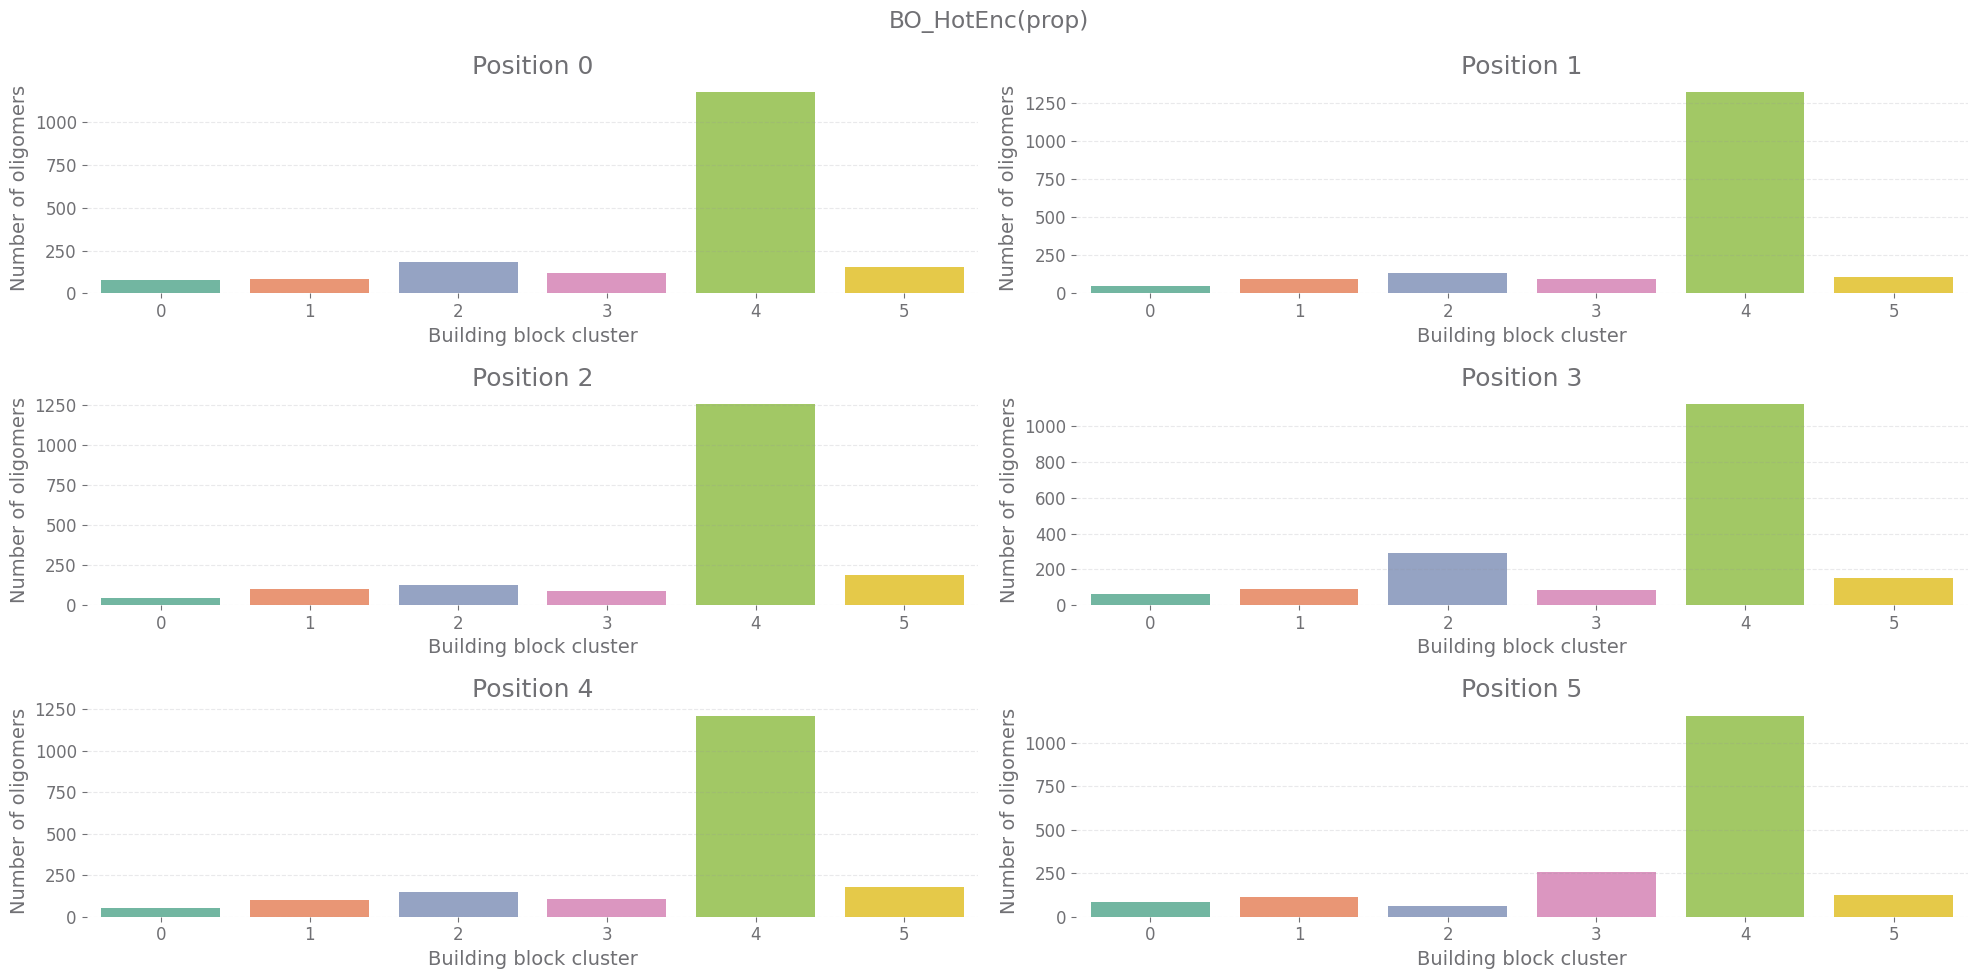

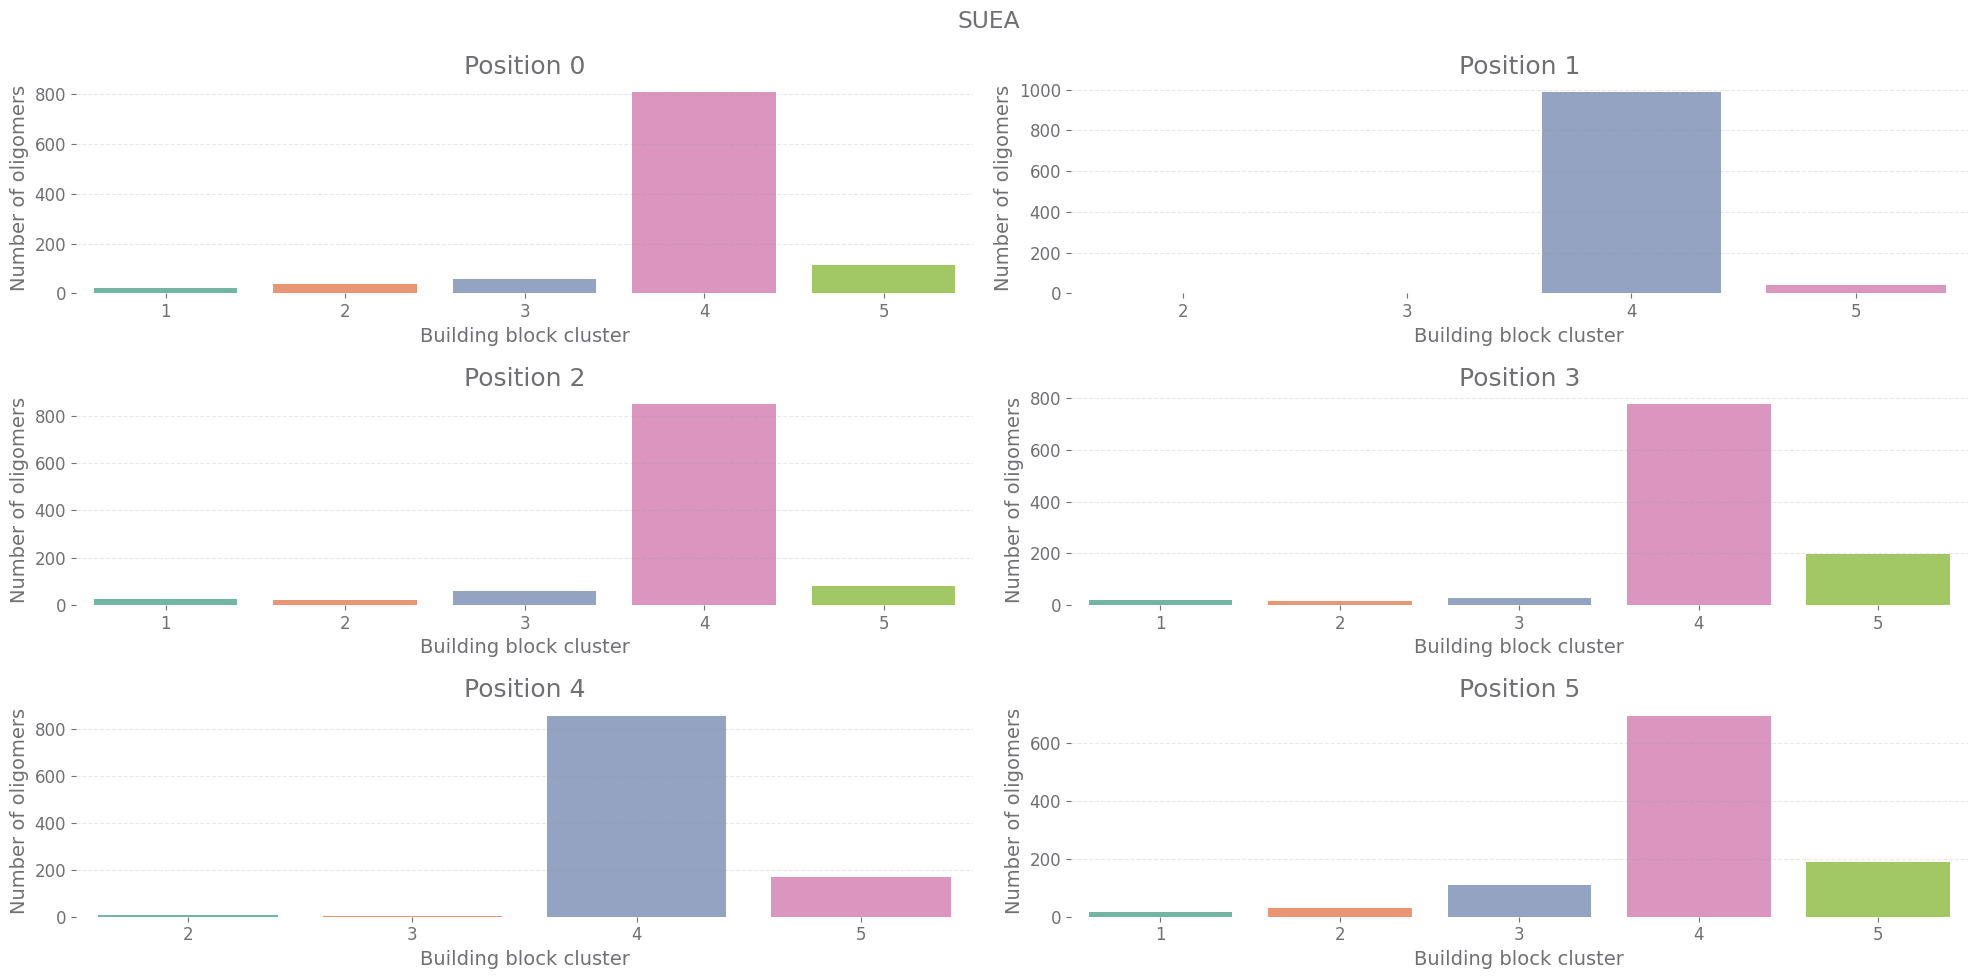

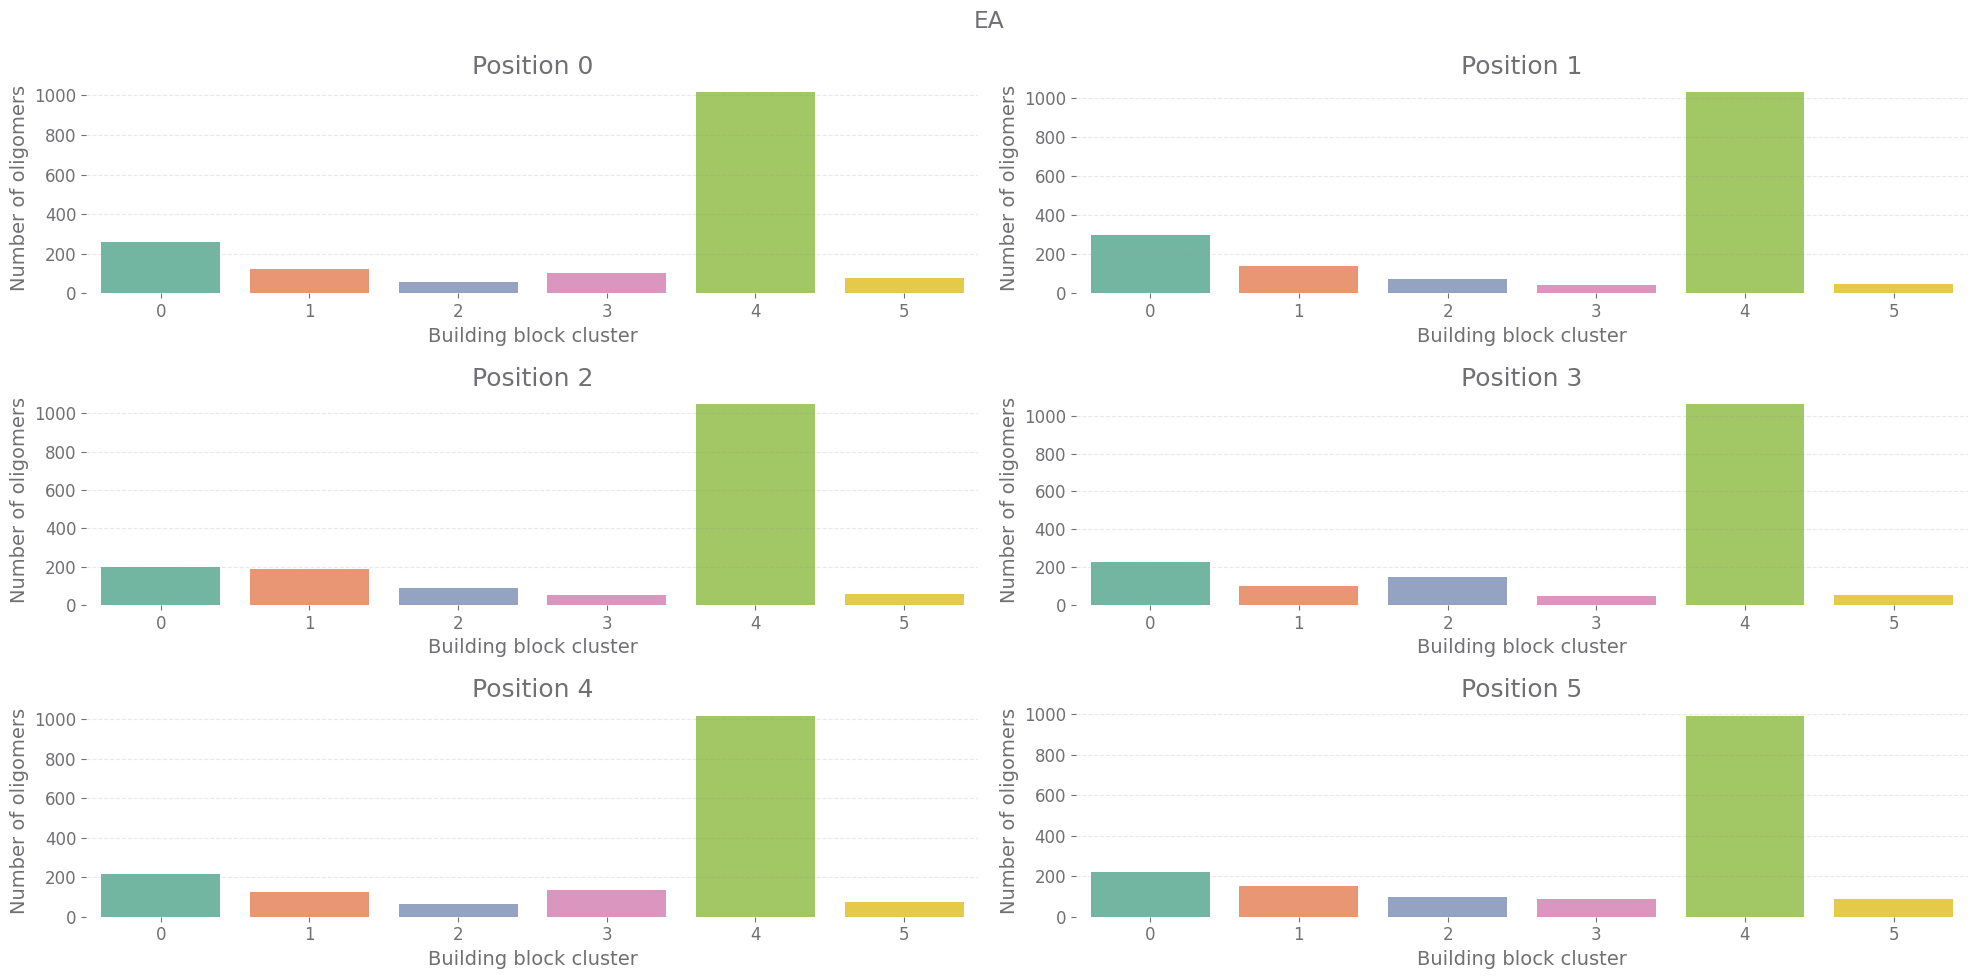

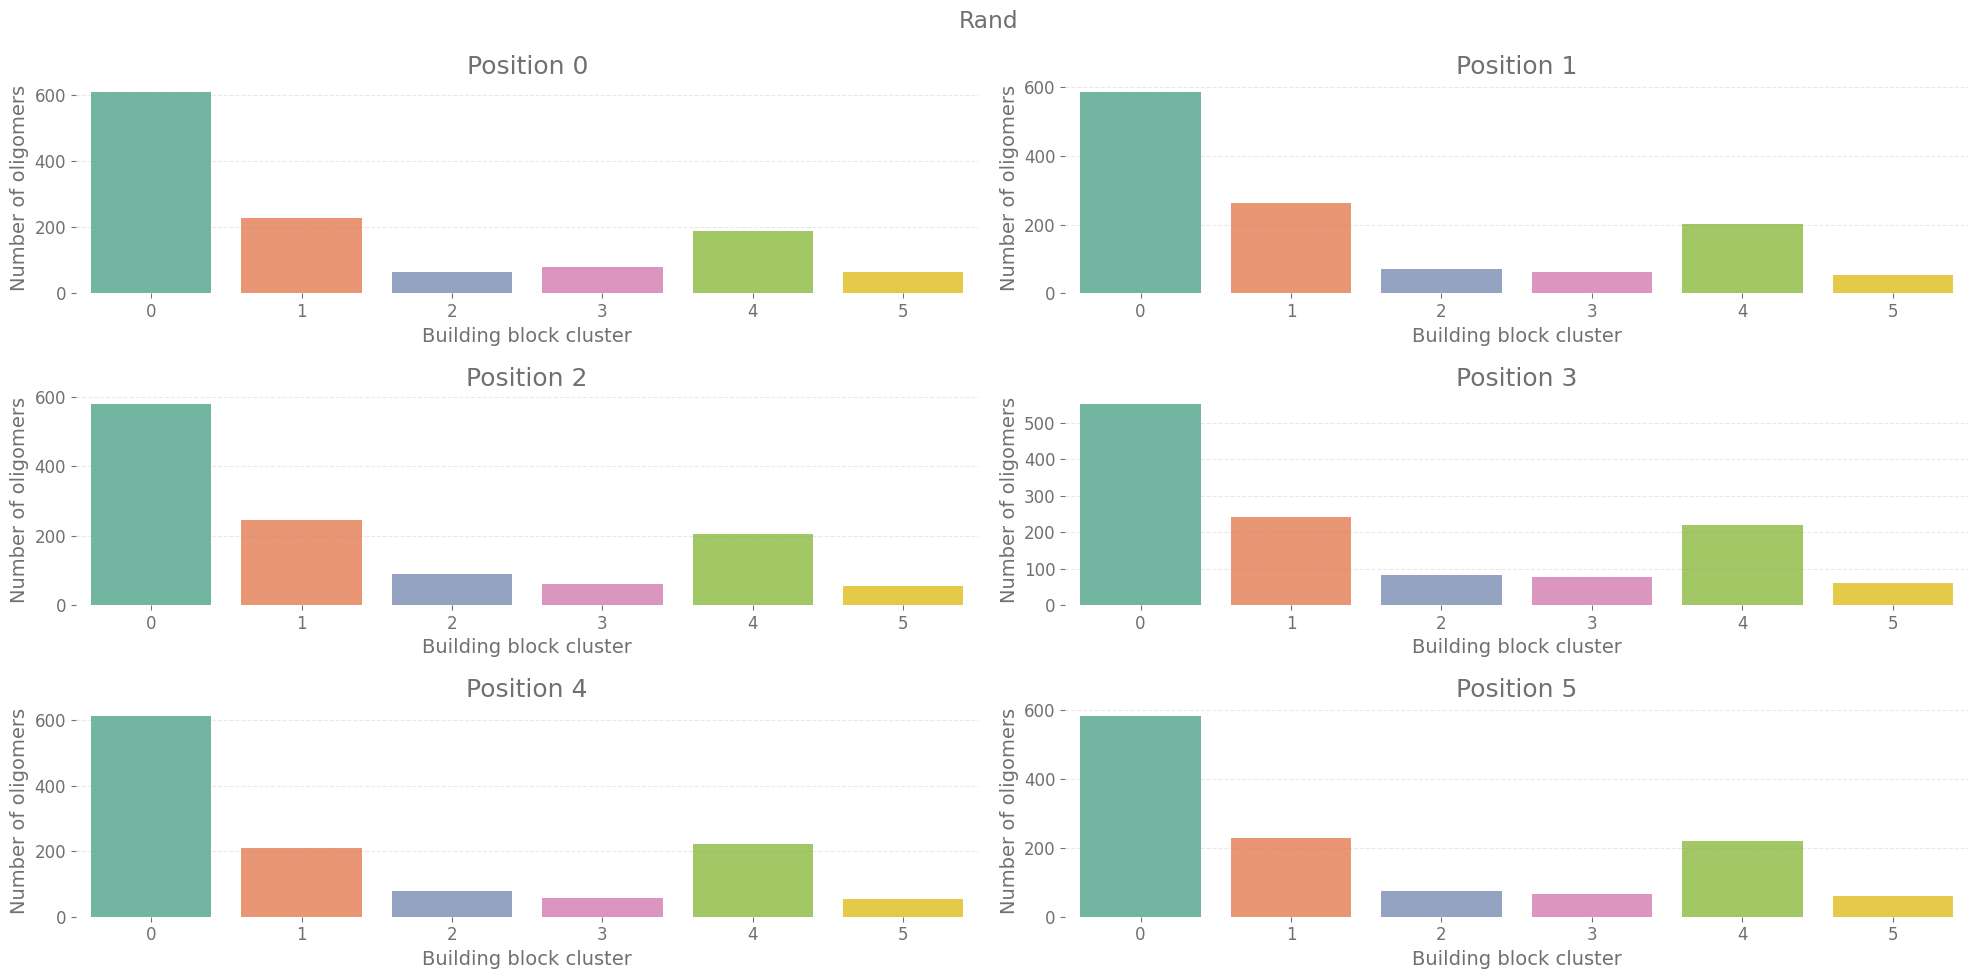

In [45]:
import seaborn as sns
def plot_count_cluster (df,title):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    import seaborn as sns
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.countplot(data=df_plot, x=f'cluster_{i}',ax=_ax,hue=f'cluster_{i}',palette='Set2')
        #_ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Number of oligomers')
    fig.suptitle(title)
    fig.tight_layout()
counter = 0
for key,df in df_results_dict.items():
    plot_count_cluster(df,title = legend_list[counter])
    counter +=1

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  d

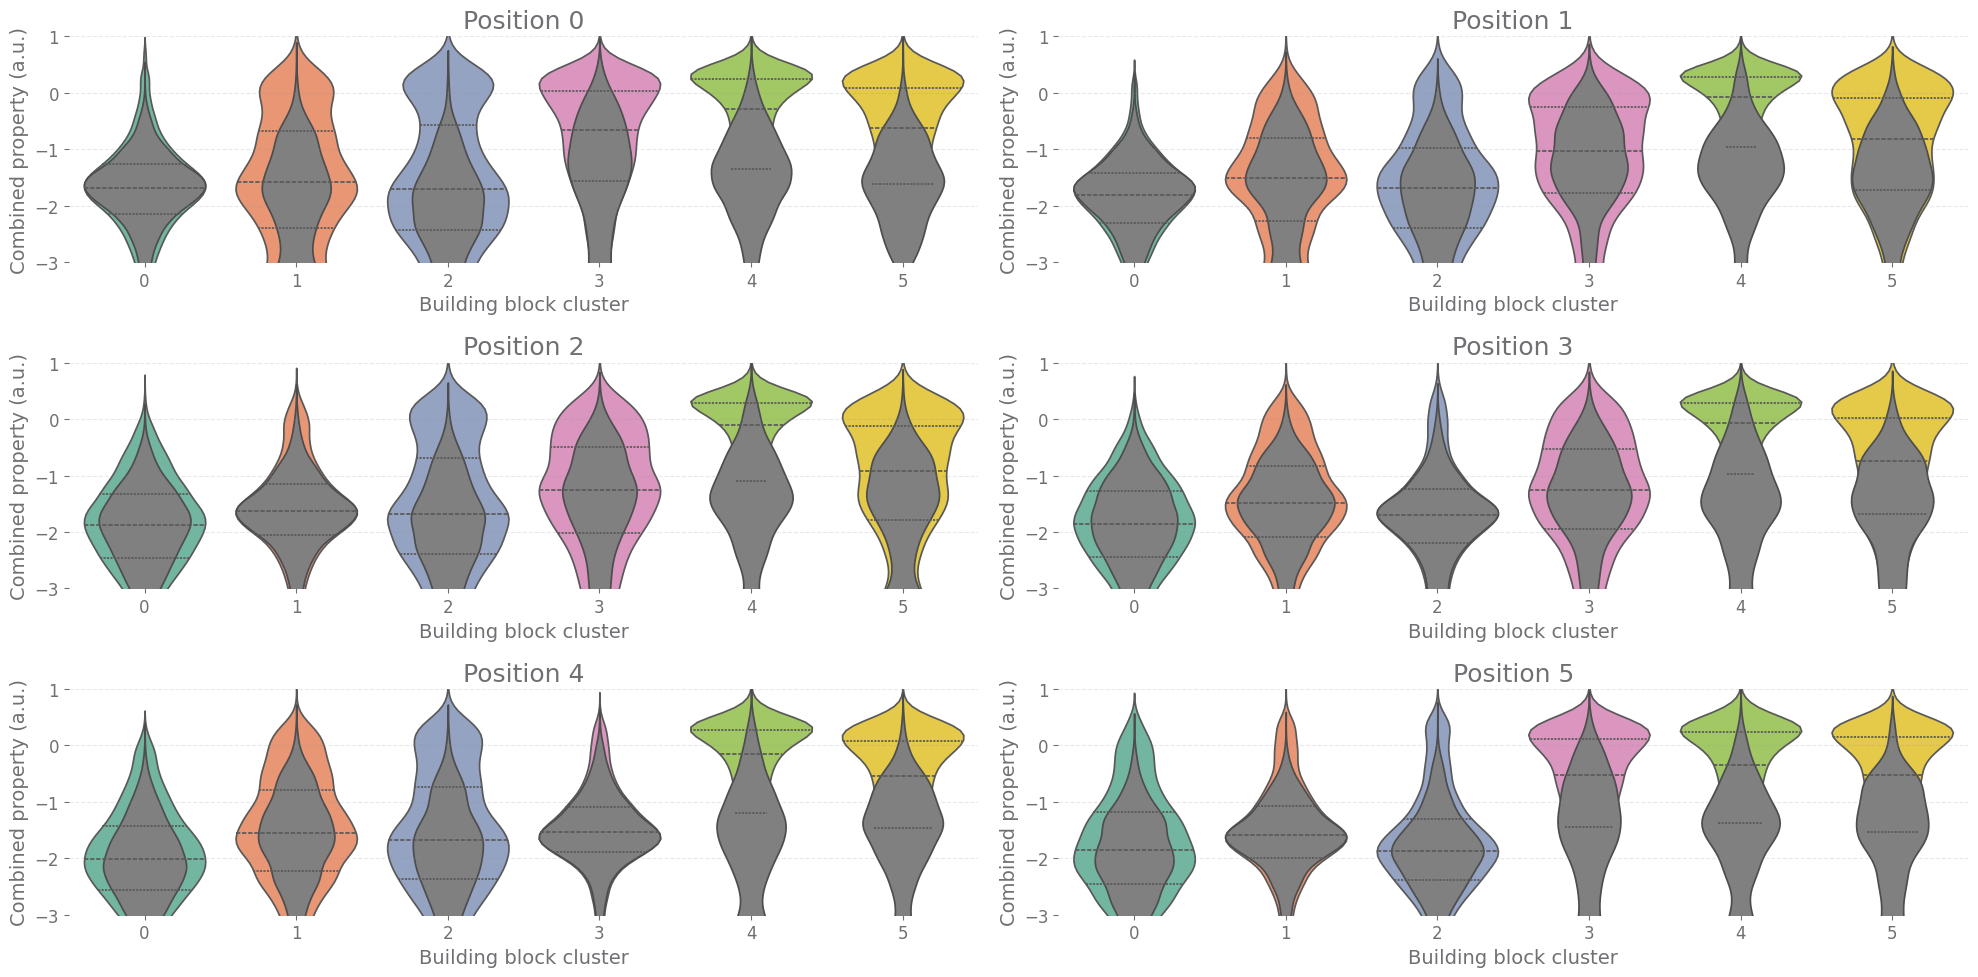

In [27]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
def plot_violin_cluster_compare (df,df2):
    df_plot = df.copy()
    df_plot_2 = df2.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
        df_plot_2['InChIKey_precursor'] = df_plot_2[f'InChIKey_{i}']
        df_plot_2 = df_plot_2.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot_2[f'cluster_{i}'] = df_plot_2['cluster']
        df_plot_2.drop('cluster',axis=1,inplace=True)
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.violinplot(data=df_plot, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        sns.violinplot(data=df_plot_2, x=f'cluster_{i}', y="target", split=False,ax=_ax,color='grey',inner=None)
        _ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Combined property (a.u.)')
    fig.tight_layout()

plot_violin_cluster_compare(df_total_new,df_Benchmark)

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  d

(14445, 28)


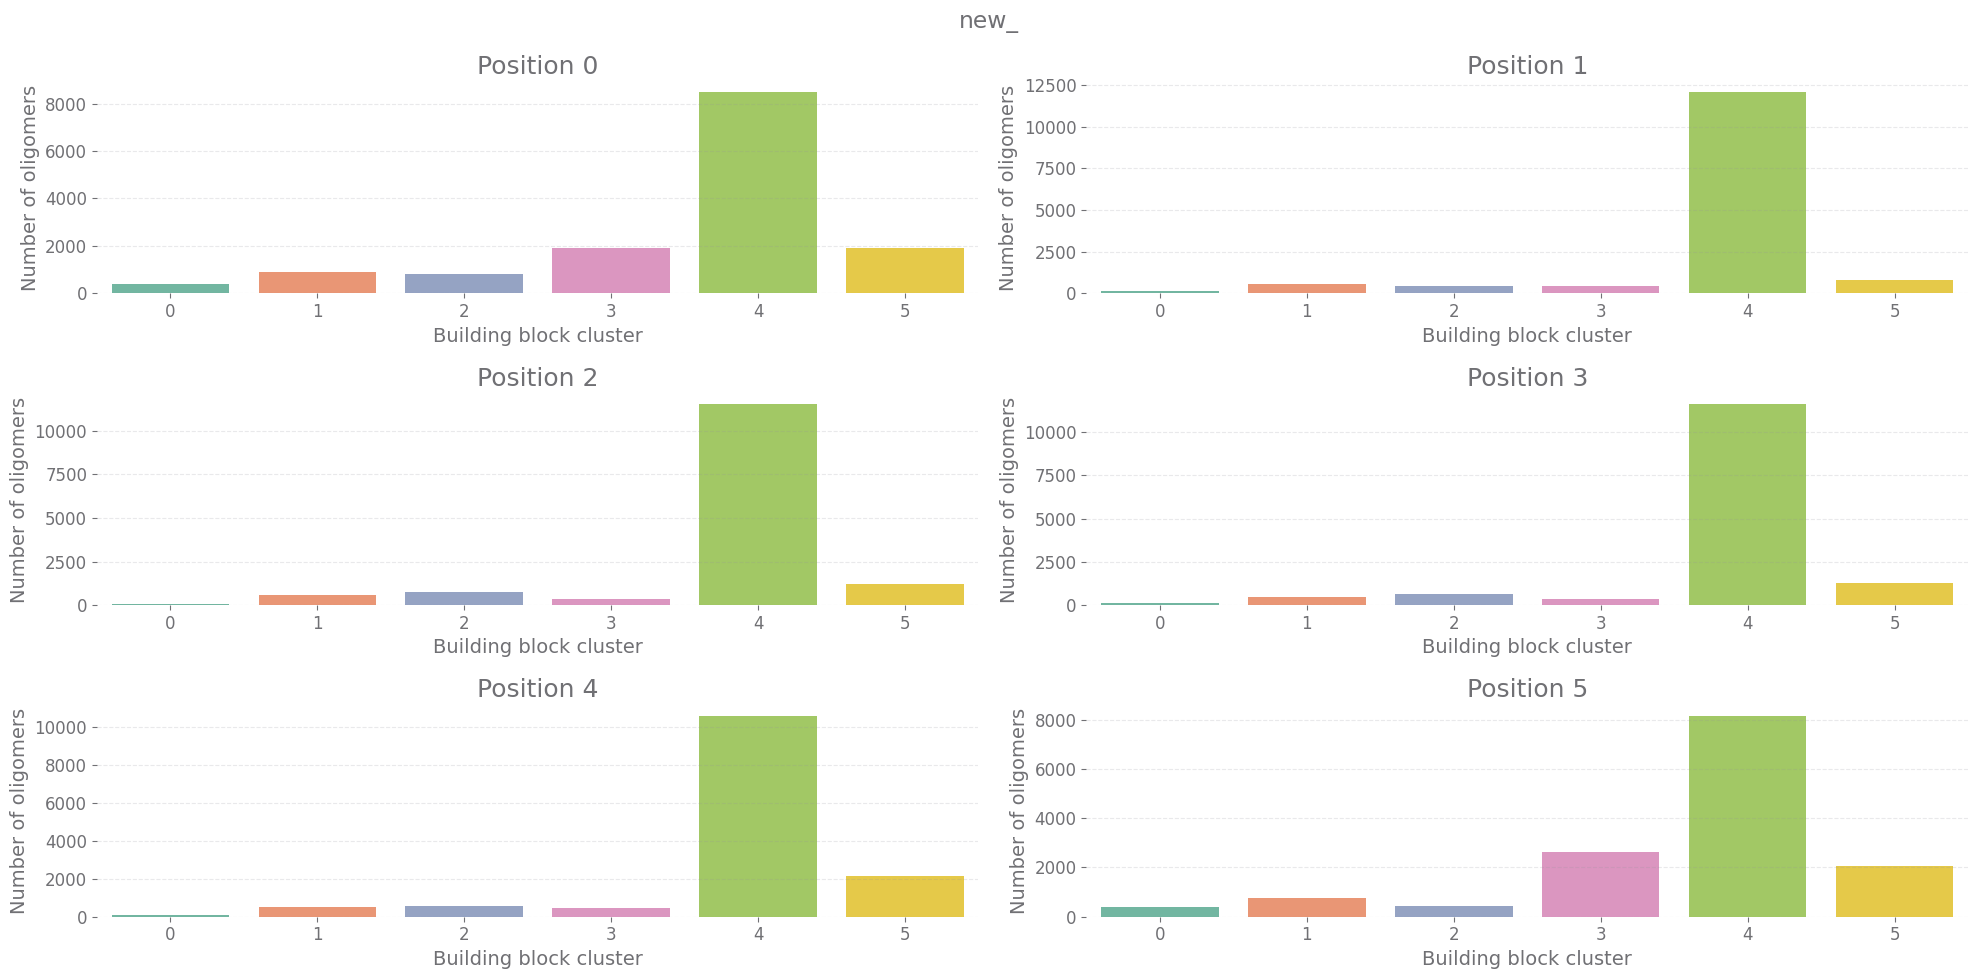

In [28]:
plot_count_cluster(df_total_new[df_total_new[target]>0],title = 'new_')
print(df_total_new[df_total_new[target]>0].shape)

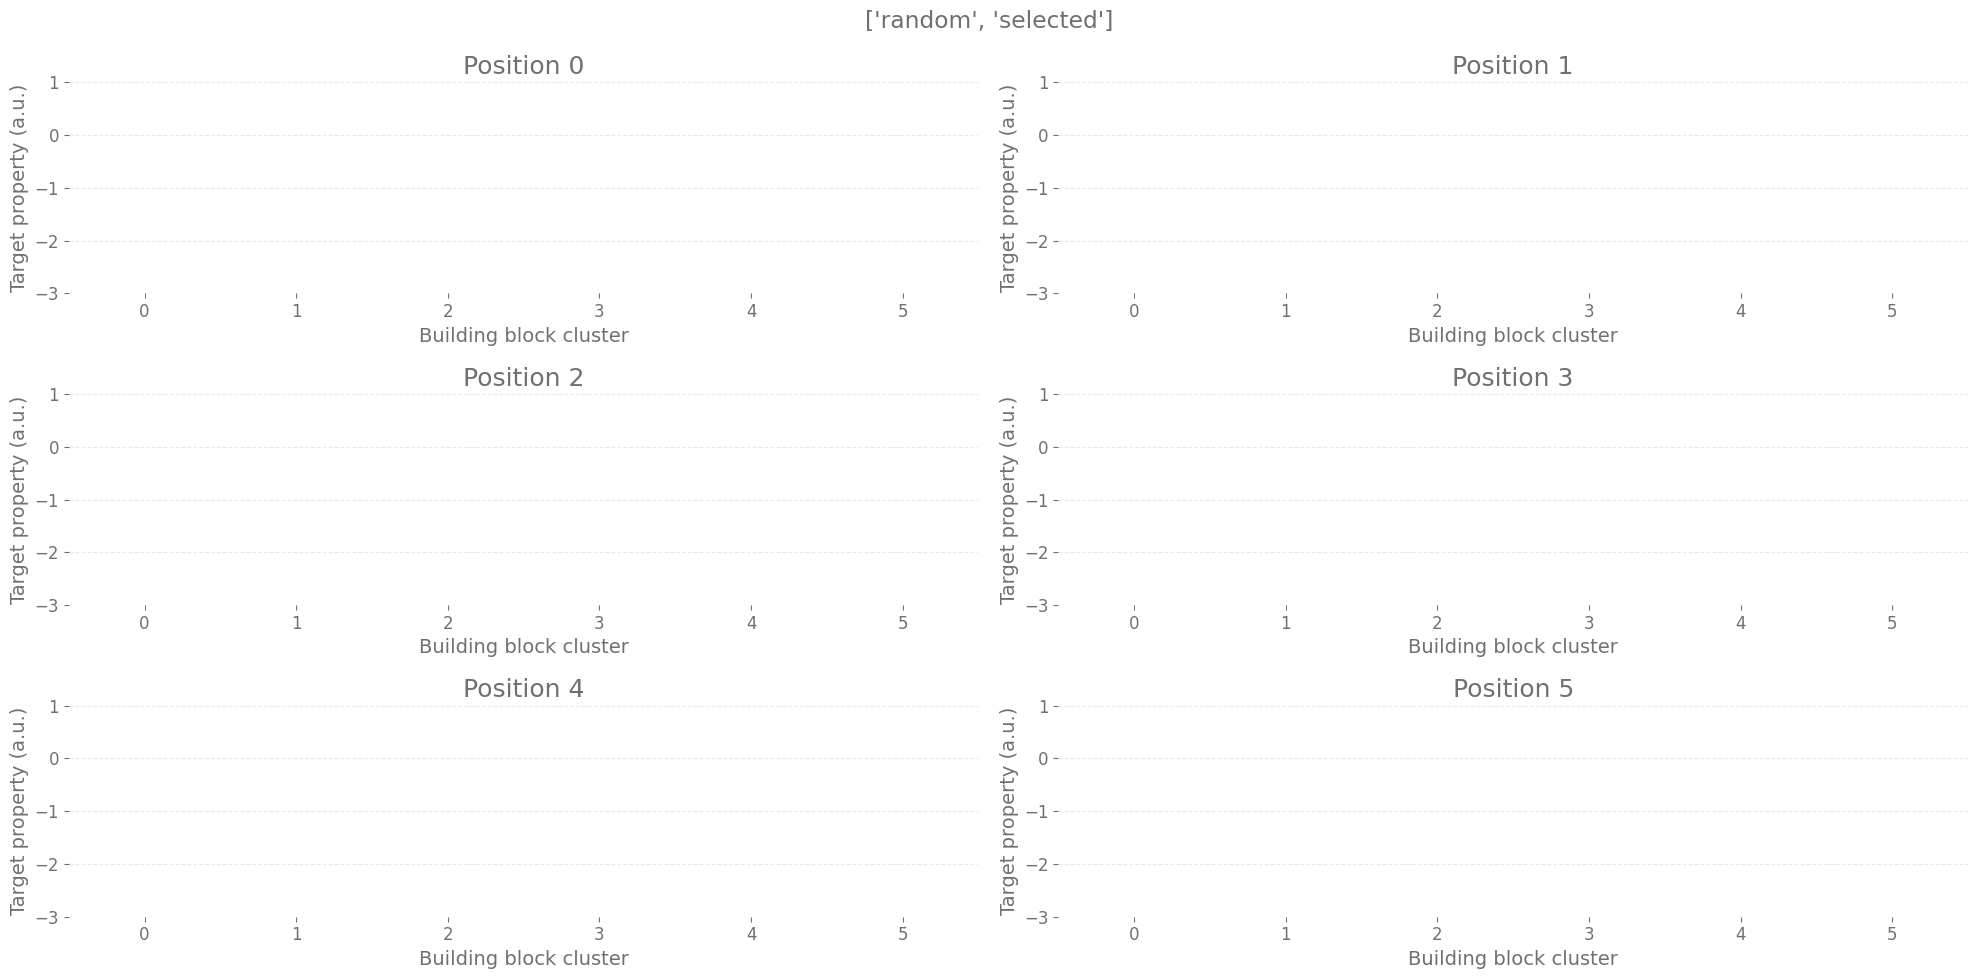

In [29]:
import seaborn as sns
def plot_violin_cluster (df,title,target):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.violinplot(data=df_plot, x=f'cluster_{i}', y=target, split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        _ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Target property (a.u.)')
    fig.suptitle(title)
    fig.tight_layout()
    return fig,ax
fig,ax = plot_violin_cluster(df_total_new[df_total_new[target]>0],title = key.split('*')[:2],target='ionisation potential (eV)')

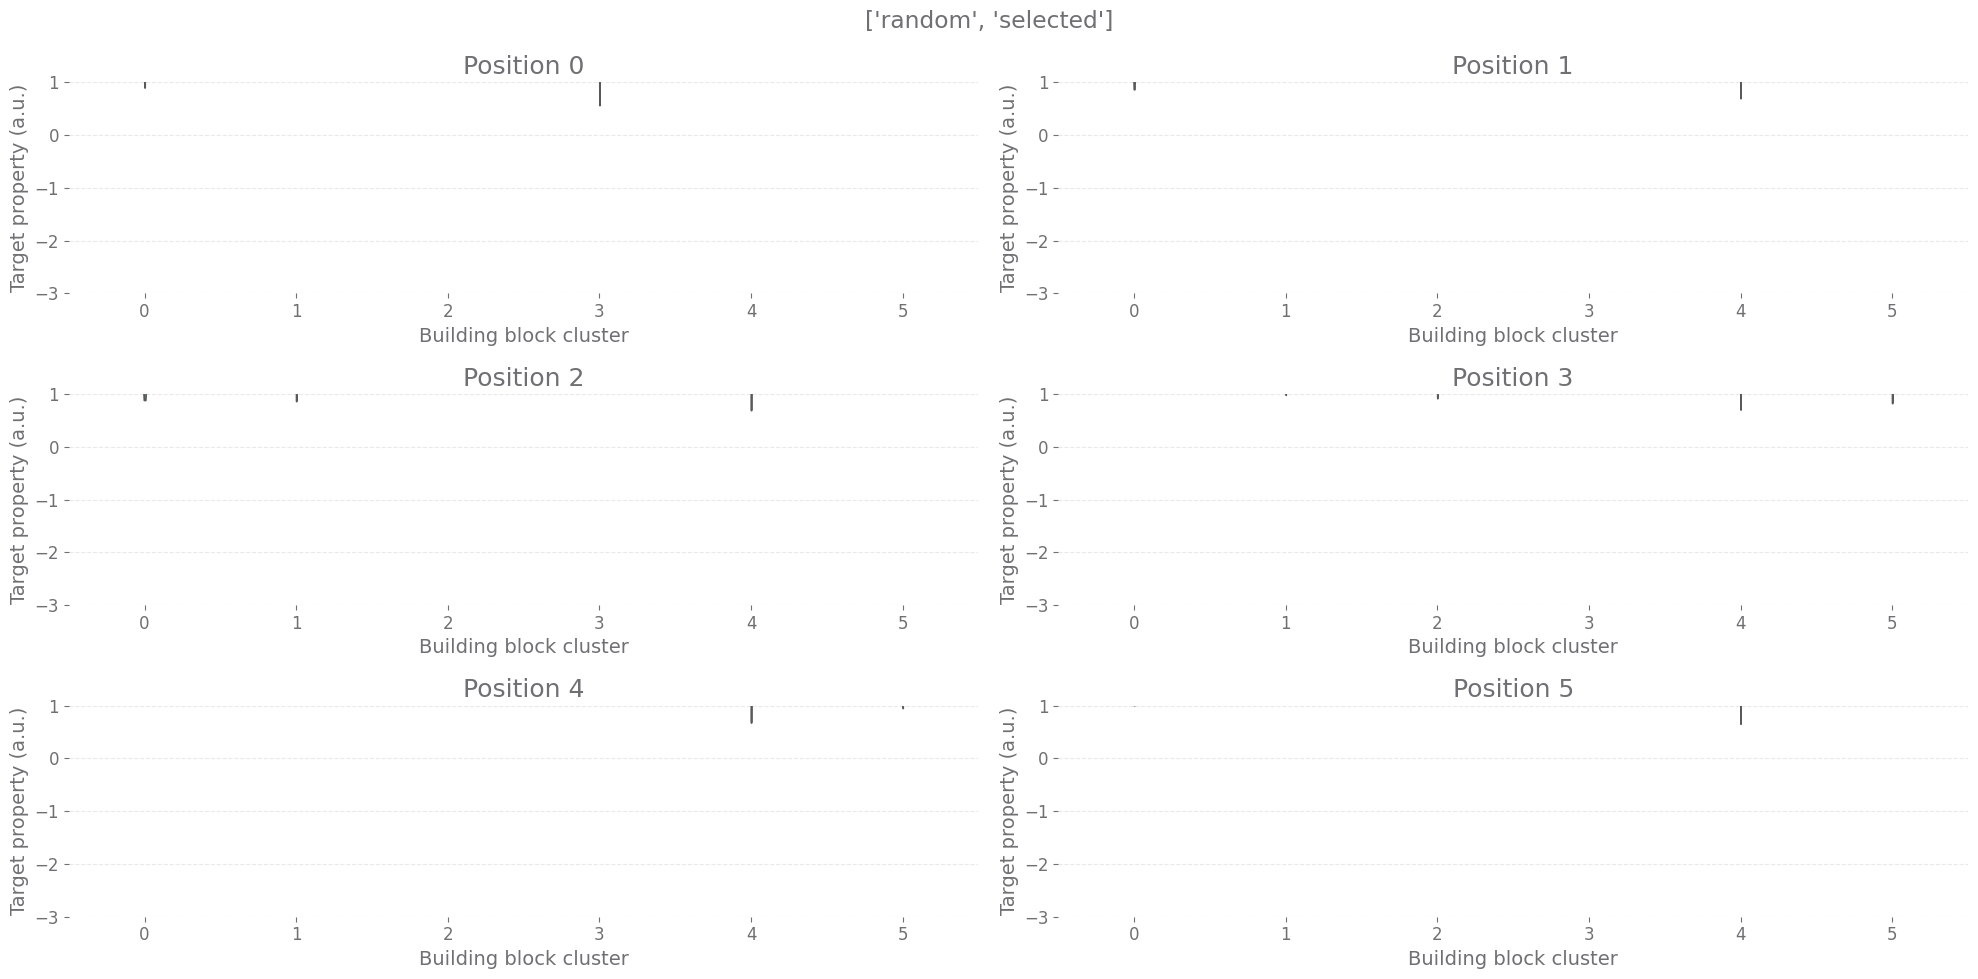

In [30]:

fig,ax = plot_violin_cluster(df_total_new[df_total_new[target]>0],title = key.split('*')[:2],target='fosc1')

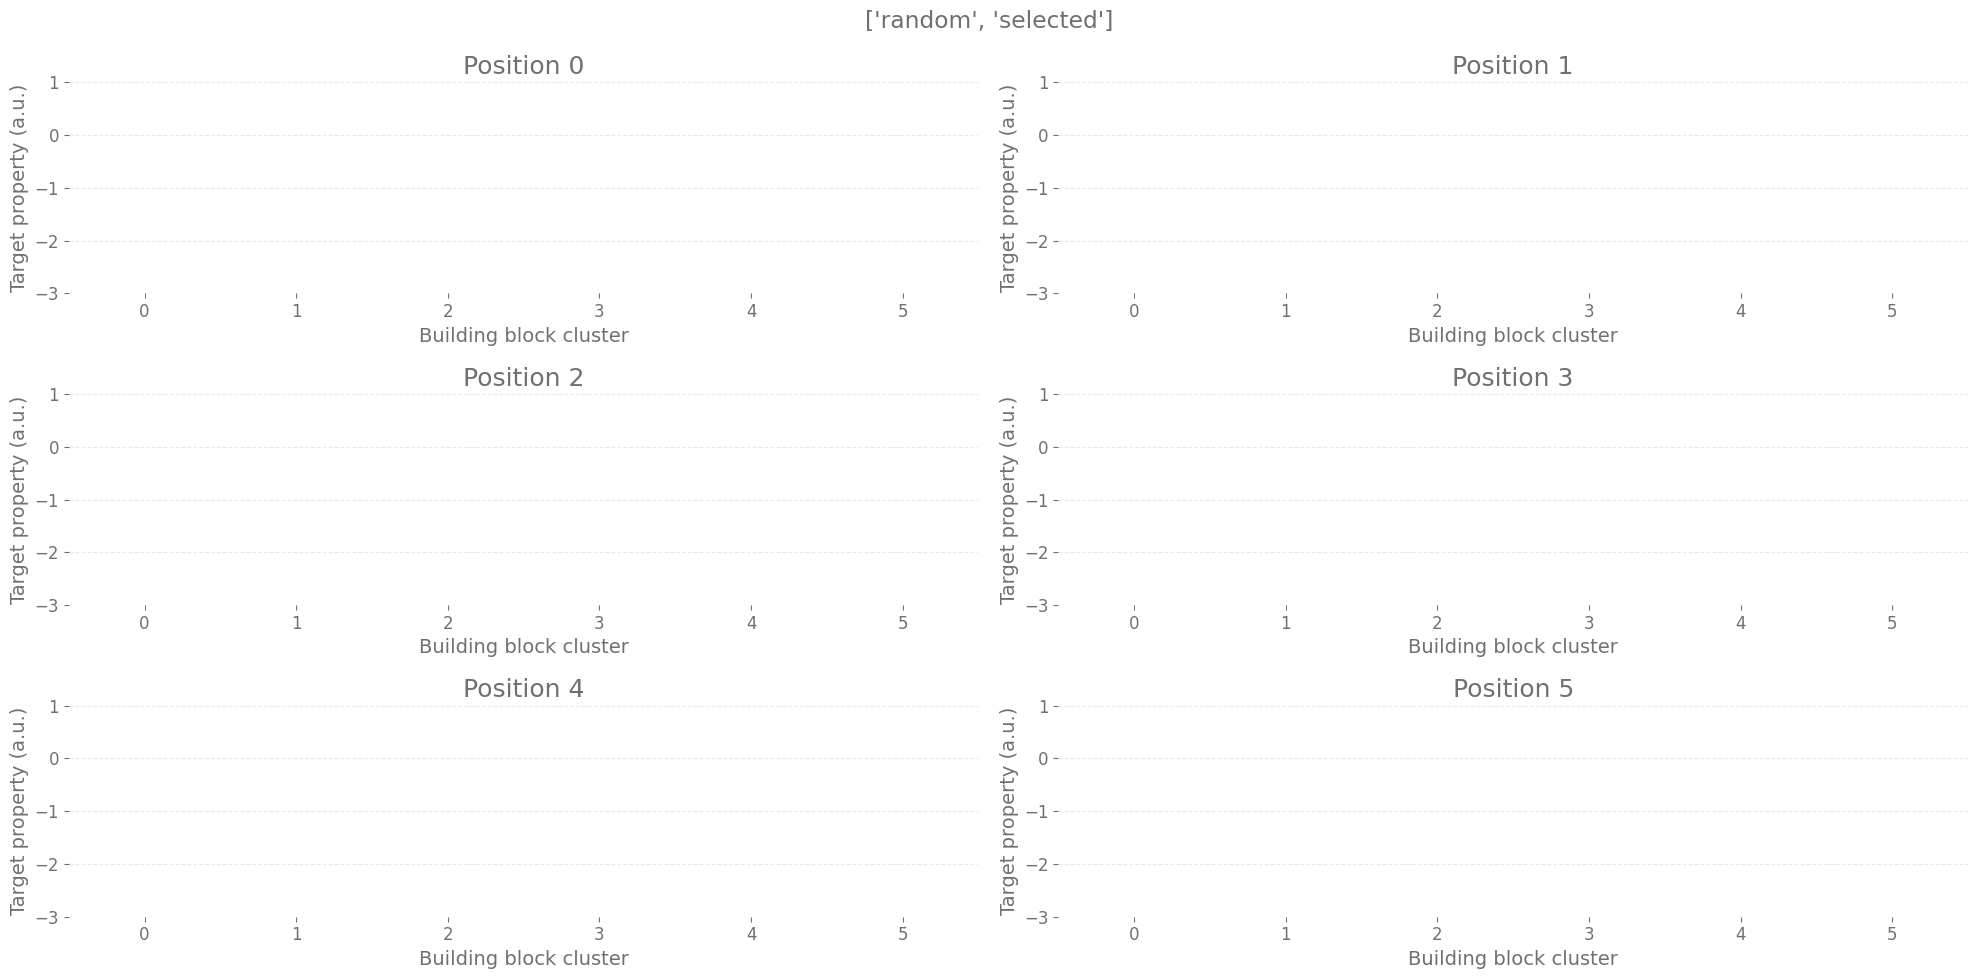

In [31]:

fig,ax = plot_violin_cluster(df_total_new[df_total_new[target]>0],title = key.split('*')[:2],target='ES1')

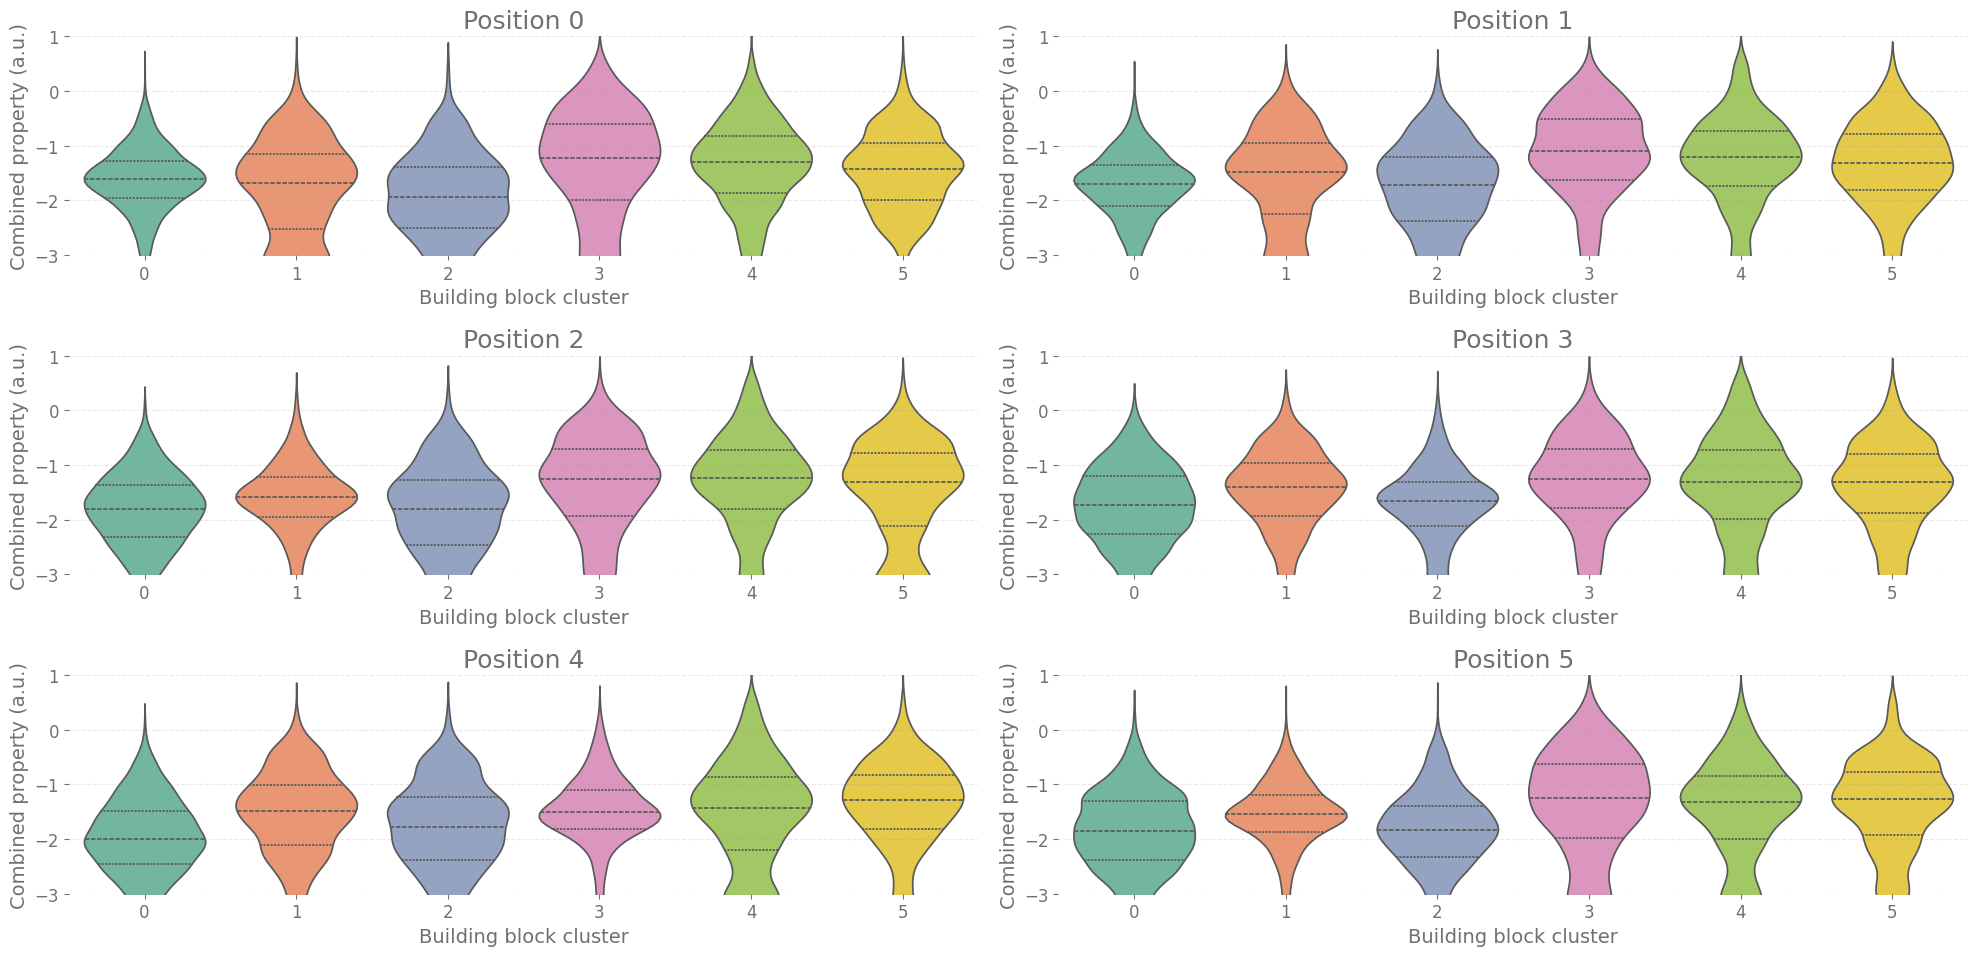

In [54]:
fig,ax = plot_violin_cluster(df_Benchmark,title ='',target='target')
for ax_ in ax:
    ax_.set_ylabel('Combined property (a.u.)')

In [50]:
df["target"] = (
                - np.abs(df["ionisation potential (eV)"].values - 5.5)
                + np.log10(df["fosc1"].values+0)
                - 0.5* np.abs(df["ES1"].values - 3)
            )

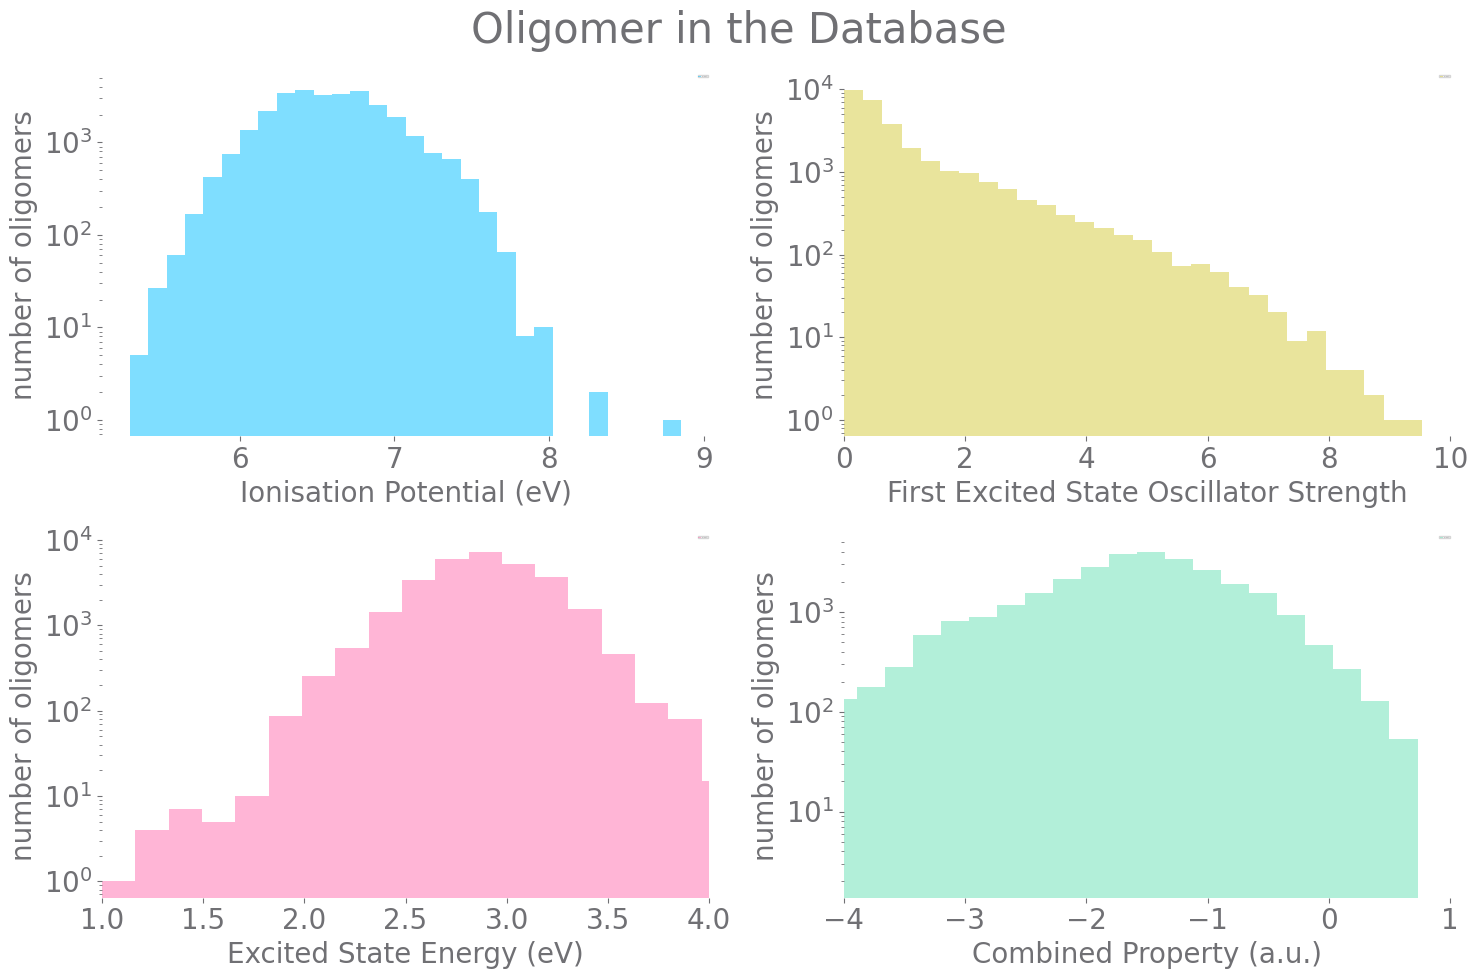

In [52]:
from matplotlib import pyplot as plt
def plot_hist_compare( df_all, df_list, label_list):
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        def plot_hist(df, ax, color, label="all data"):
            df["target"] = (
                 -np.abs(df["ionisation potential (eV)"].values - 5.5)
                + np.log10(df["fosc1"].values+0)
                - 0.5 * np.abs(df["ES1"].values - 3)
            )
            df["ionisation potential (eV)"].hist(
                ax=ax[0, 0], bins=30, density=0, color=color, label=label, alpha=0.5
            )
            df["fosc1"].hist(
                ax=ax[0, 1], bins=30, density=0, color=color, label=label, alpha=0.5
            )
            df["ES1"].hist(
                ax=ax[1, 0], bins=30, density=0, color=color, label=label,  alpha=0.5
            )
            df["target"].hist(
                ax=ax[1, 1], bins=30, density=0, color=color, label=label, alpha=0.5
            )


        plot_hist(df=df_all, ax=ax, color="#21918c")
        # get a color list for the diffetent datasets
        color_list = [
            "#5ec962",
            "#f9c74f",
            "#f3722c",
            "#f94144",
            "#90be6d",
            "#577590",
            "#f8961e",
            "#e63946",
            "#a8dadc",
            "#457b9d",
        ]
        
        # add legend for the figure on top showing the different datasets
        ax[0, 0].set_xlabel("Ionisation Potential (eV)")
        ax[0, 1].set_xlabel("First Excited State Oscillator Strength")
        ax[1, 0].set_xlabel("Excited State Energy (eV)")
        ax[1, 0].set_xlim([1, 4])
        ax[0, 1].set_xlim([0, 10])
        ax[1, 1].set_xlim([-4, 1])
        ax[1, 1].set_xlabel("Combined Property (a.u.)")
        ax[0,0].legend()
        for ax in ax.flatten():
            ax.grid(False)
            ax.set_ylabel("number of oligomers")
            ax.set_yticks([])
            #ax.legend()
        plt.tight_layout()
        return fig,ax
fig,ax = plot_hist_compare(df_Benchmark,df_list,['benchmark'])
fig.suptitle('Oligomer in the Database',fontsize=30)
# change color of histogram
for i in range(len(fig.axes)):
    for j in range(len(fig.axes[i].patches)):
        fig.axes[i].patches[j].set_facecolor(f'C{i}')
# increase the font size of the labels
for ax in fig.axes:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlabel(ax.get_xlabel(),fontsize=20)
    ax.set_ylabel(ax.get_ylabel(),fontsize=20)
    ax.set_title(ax.get_title(),fontsize=20)
    ax.legend(fontsize=0)
    ax.set_yscale('log')
fig.tight_layout()

/var/tmp/pbs.9556003.pbs/ipykernel_860179/3950161246.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x=f'dominant_cluster', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
/var/tmp/pbs.9556003.pbs/ipykernel_860179/3950161246.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x=f'dominant_cluster',ax=ax[1],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pand

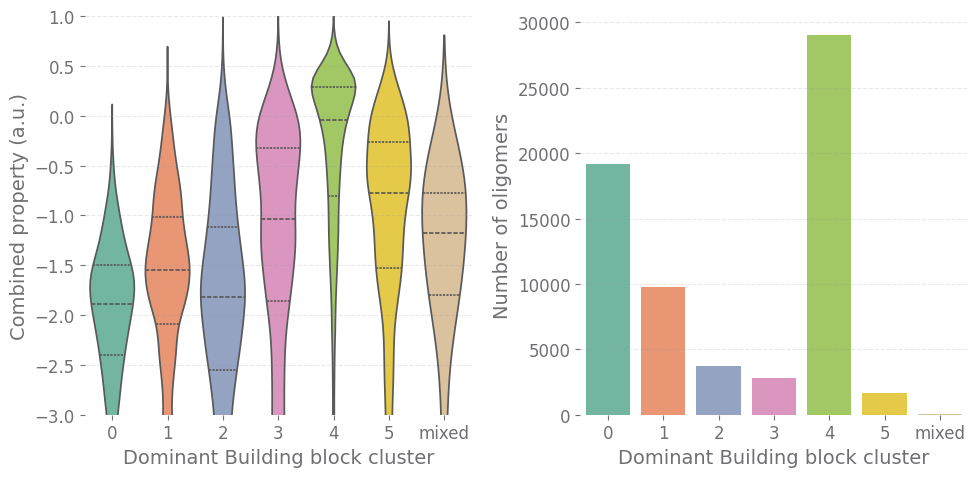

In [21]:
import seaborn as sns
def plot_violin_cluster_unique (df,title,target):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    df_plot['unique_cluster'] = [len(set(x)) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['unique_BB'] = [len(set(x)) for x in df_plot[[f'InChIKey_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] = [np.unique(x, return_counts=True) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: x[0][np.argmax(x[1])] if x[1].max()> 1 else 7)
    
    df_plot.sort_values('dominant_cluster',ascending=True,inplace=True)
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: 'mixed' if x==7 else x)

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    sns.violinplot(data=df_plot, x=f'dominant_cluster', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
    sns.countplot(data=df_plot, x=f'dominant_cluster',ax=ax[1],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
    ax[0].set_ylim(-3,1)
    #ax.legend()#.set_visible(False)
    #ax.set_title(f'Position {i}')
    ax[0].set_xlabel(f'Dominant Building block cluster')
    ax[0].set_ylabel(f'Combined property (a.u.)')
    ax[1].set_xlabel(f'Dominant Building block cluster')
    ax[1].set_ylabel(f'Number of oligomers')
    #fig.suptitle(title)
    fig.tight_layout()
    return df_plot
df_plot = plot_violin_cluster_unique(df_total_new,title = key.split('*')[:2],target='target')

/var/tmp/pbs.9556003.pbs/ipykernel_860179/3950161246.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x=f'dominant_cluster', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
/var/tmp/pbs.9556003.pbs/ipykernel_860179/3950161246.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x=f'dominant_cluster',ax=ax[1],palette='Set2')#,hue=f'dominant_cluster',palette='Set2')
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pand

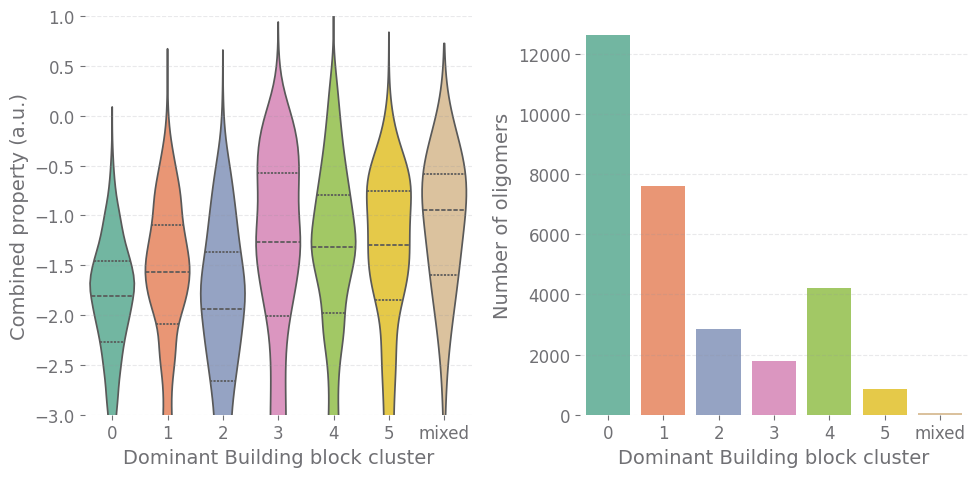

In [22]:
df_plot = plot_violin_cluster_unique(df_Benchmark,title = key.split('*')[:2],target='target')

In [26]:
df_Benchmark[df_Benchmark['target']>max(df_Benchmark['target'])-0.4]

InChIKey                   InChIKey_0  \
10502  BOKWVLIBYJWCOR-UJIRSWQMSA-N  NMTVJRGZIBKXSL-AOOOYVTPSA-N   
10827  HQEMSKMFCYMHJR-UHFFFAOYSA-N  QALUKDGRSRNSMX-UHFFFAOYSA-N   
10911  FSIKZTMIUMSJEC-UHFFFAOYSA-N  KEPNBEPTGHROGD-UHFFFAOYSA-N   
11082  ZMKORSVZSZPWEE-UHFFFAOYSA-N  HDLQYWLFGNHWIY-UHFFFAOYSA-N   
11172  TVZSBJHASUGVRI-UHFFFAOYSA-N  VYBPDQFBRPIADM-UHFFFAOYSA-N   
...                            ...                          ...   
29967  WCHCAXMQILMOJE-UHFFFAOYSA-N  WZTRBPPIJBTTOH-UHFFFAOYSA-N   
29973  KYCASMUYFXIOQT-MULCNKJOSA-N  RTHCZUJRUPXMTF-WCIBSUBMSA-N   
29975  NIAANILFDRYELG-UHFFFAOYSA-N  FLKJKBPMEVYPMI-UHFFFAOYSA-N   
29992  AYXMXELBTDPFGJ-UHFFFAOYSA-N  ZYFAZQDJDGUYES-UHFFFAOYSA-N   
29994  CDNDIFNBKPHUSQ-UHFFFAOYSA-N  SWJPEBQEEAHIGZ-UHFFFAOYSA-N   

                        InChIKey_1                   InChIKey_2  \
10502  NMTVJRGZIBKXSL-AOOOYVTPSA-N  NMTVJRGZIBKXSL-AOOOYVTPSA-N   
10827  DOXWISNBDAHQBD-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   
10911  KEPNBEPTGHROGD-UHFFFAOYSA-N  XJDUSLLTQXVMPI-UHFFFAOYSA-N   
11082  HZYBLPHGWLNIQV-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   
11172  WDPBIWAFLWMYEV-UHFFFAOYSA-N  SXRSYJAHJIIXFM-UHFFFAOYSA-N   
...                            ...                          ...   
29967  KEPNBEPTGHROGD-UHFFFAOYSA-N  ZQUFQULVODWNAL-UHFFFAOYSA-N   
29973  KEPNBEPTGHROGD-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   
29975  AZYPAMWLUNRZKI-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   
29992  GZBJRMVGNVDUCO-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   
29994  VEGYYSITGMCNND-UHFFFAOYSA-N  VEGYYSITGMCNND-UHFFFAOYSA-N   

                        InChIKey_3                   InChIKey_4  \
10502  NMTVJRGZIBKXSL-AOOOYVTPSA-N  NMTVJRGZIBKXSL-AOOOYVTPSA-N   
10827  VEGYYSITGMCNND-UHFFFAOYSA-N  DOXWISNBDAHQBD-UHFFFAOYSA-N   
10911  XJDUSLLTQXVMPI-UHFFFAOYSA-N  KEPNBEPTGHROGD-UHFFFAOYSA-N   
11082  VEGYYSITGMCNND-UHFFFAOYSA-N  HZYBLPHGWLNIQV-UHFFFAOYSA-N   
11172  SXRSYJAHJIIXFM-UHFFFAOYSA-N  WDPBIWAFLWMYEV-UHFFFAOYSA-N   
...                            ...                          ...   
29967  KEPNBEPTGHROGD-UHFFFAOYSA-N  BIUZIQOHJOYRIT-UHFFFAOYSA-N   
29973  VEGYYSITGMCNND-UHFFFAOYSA-N  KEPNBEPTGHROGD-UHFFFAOYSA-N   
29975  KEPNBEPTGHROGD-UHFFFAOYSA-N  XJTOYLFEOFRICX-UHFFFAOYSA-N   
29992  VEGYYSITGMCNND-UHFFFAOYSA-N  KEPNBEPTGHROGD-UHFFFAOYSA-N   
29994  VEGYYSITGMCNND-UHFFFAOYSA-N  APDAUBNBDJUQGW-UHFFFAOYSA-N   

                        InChIKey_5  num_BB                     _id_x  \
10502  NMTVJRGZIBKXSL-AOOOYVTPSA-N     6.0  64e22f4254f281add06cc027   
10827  QALUKDGRSRNSMX-UHFFFAOYSA-N     6.0  64fa3467b253f4d1f4f72000   
10911  KEPNBEPTGHROGD-UHFFFAOYSA-N     6.0  64fa3c13b253f4d1f4f9139b   
11082  HDLQYWLFGNHWIY-UHFFFAOYSA-N     6.0  64fa487bb253f4d1f4fd0a8d   
11172  VYBPDQFBRPIADM-UHFFFAOYSA-N     6.0  64fa4ed7b253f4d1f4ff7156   
...                            ...     ...                       ...   
29967  KEPNBEPTGHROGD-UHFFFAOYSA-N     NaN  660d89d71474e31c4da6376c   
29973  ZYFAZQDJDGUYES-UHFFFAOYSA-N     NaN  66024b461474e31c4d7767ec   
29975  KEPNBEPTGHROGD-UHFFFAOYSA-N     NaN  660d485e1474e31c4d1bddc2   
29992  NXRINMCDJWZTNV-UHFFFAOYSA-N     NaN  6604d74c1474e31c4d9b8454   
29994  DOXWISNBDAHQBD-UHFFFAOYSA-N     NaN  662fec86817a259a192a3949   

      Host IP_x  ...     pca5_5     pca6_5    pca7_5    pca8_5    pca9_5  \
10502       cx1  ...  -2.872661   3.321196 -5.922311  3.241183  3.568546   
10827       cx1  ...  19.624462  -2.028607 -0.778707 -4.237340 -0.044846   
10911       cx1  ...   3.307750  11.933818  6.558954  3.173410 -3.375855   
11082       cx1  ...  -0.999634  -1.925667 -3.880645  0.635094  1.596241   
11172       cx1  ...   8.656914  11.177905 -0.418431 -4.547657  1.534500   
...         ...  ...        ...        ...       ...       ...       ...   
29967       cx1  ...   3.307750  11.933818  6.558954  3.173410 -3.375855   
29973       cx1  ...   3.732816  -4.425013 -3.560609 -0.803479  0.129196   
29975       cx1  ...   3.307750  11.933818  6.558954  3.173410

In [127]:
df_prec_cluster = df_precursors[['InChIKey','cluster','mol_org_smile']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)


/var/tmp/pbs.9470919.pbs/ipykernel_3518115/62623789.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x=f'main_fragment', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'unique_BB'
/var/tmp/pbs.9470919.pbs/ipykernel_3518115/62623789.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x=f'main_fragment',ax=ax[1],palette='Set2')
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_sub

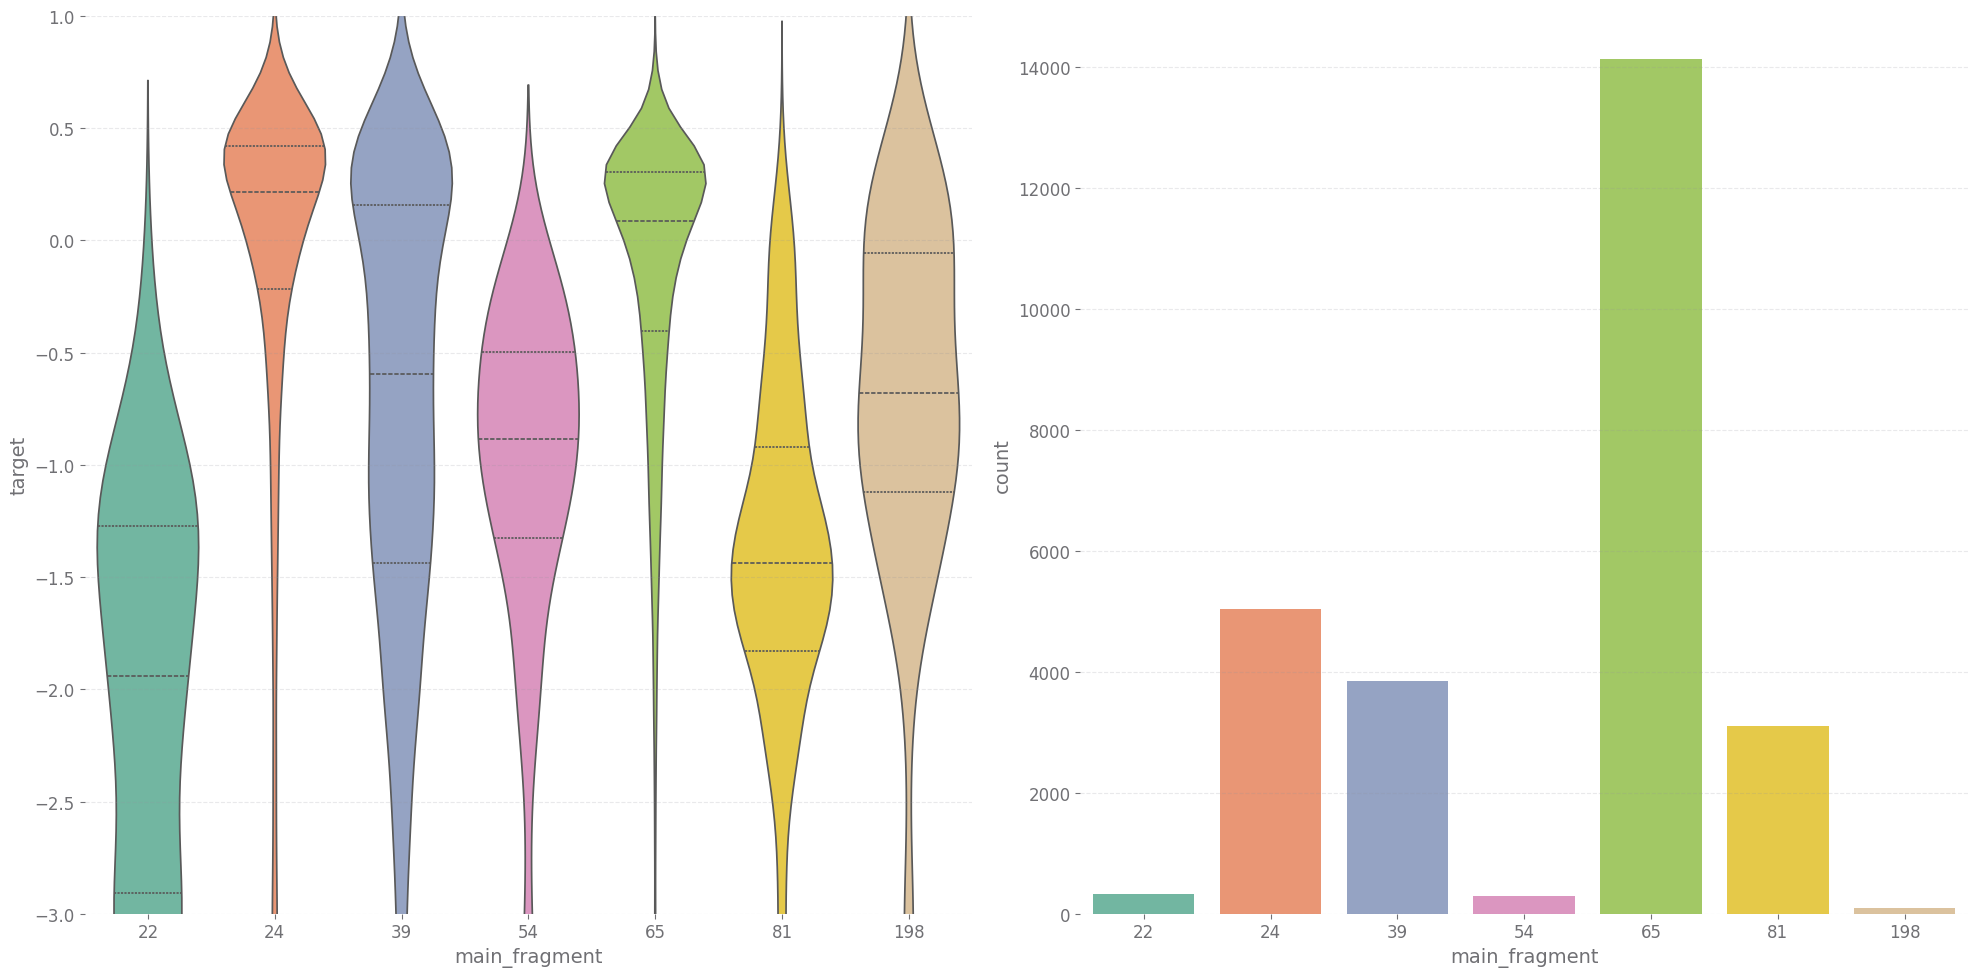

In [173]:
import seaborn as sns
def plot_violin_cluster_unique (df,title,target,cluster=1):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']

        df_plot[f'mol_org_smile_{i}'] = df_plot['mol_org_smile']
        df_plot.drop('cluster',axis=1,inplace=True)
        df_plot.drop('mol_org_smile',axis=1,inplace=True)
    df_plot['unique_cluster'] = [len(set(x)) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['unique_BB'] = [len(set(x)) for x in df_plot[[f'InChIKey_{i}' for i in range(6)]].to_numpy()]
    df_plot['unique_smile'] = [len(set(x)) for x in df_plot[[f'mol_org_smile_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] = [np.unique(x, return_counts=True) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: x[0][np.argmax(x[1])] if x[1].max()> 1 else 7)
    df_plot.sort_values('dominant_cluster',ascending=True,inplace=True)
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: 'mixed' if x==7 else x)
    df_plot['main_building_block'] = [np.unique(x, return_counts=True) for x in df_plot[[f'InChIKey_{i}' for i in range(6)]].to_numpy()]
    df_plot['main_building_block'] =df_plot['main_building_block'].apply(lambda x: x[0][np.argmax(x[1])] if x[1].max()>1 else 'mixed')
    df_plot['main_fragment'] = [np.unique(x, return_counts=True) for x in df_plot[[f'mol_org_smile_{i}' for i in range(6)]].to_numpy()]
    df_plot['main_fragment'] =df_plot['main_fragment'].apply(lambda x: x[0][np.argmax(x[1])] if x[1].max()>1 else 'mixed')
    df_plot = df_plot[df_plot['main_fragment'].isin(df_precursors[df_precursors['cluster']==cluster]['mol_org_smile'])].copy()
    df_plot['main_fragment'] = df_plot['main_fragment'].apply(lambda x: df_precursors[df_precursors['mol_org_smile'].isin([x])]['orgcluster'].iloc[0])
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    sns.violinplot(data=df_plot, x=f'main_fragment', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'unique_BB'
    sns.countplot(data=df_plot, x=f'main_fragment',ax=ax[1],palette='Set2')
    ax[0].set_ylim(-3,1)
    #ax.legend()#.set_visible(False)
    #ax.set_title(f'Position {i}')
    #ax.set_xlabel(f'Building block cluster')
    #ax.set_ylabel(f'Target property (a.u.)')
    fig.tight_layout()
    return df_plot
df_plot = plot_violin_cluster_unique(df_total_new,title = key.split('*')[:2],target='target',cluster =4)

/var/tmp/pbs.9470919.pbs/ipykernel_3518115/4152213129.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x=f'main_fragment', y=target, split=False, inner="quart",ax=ax[0],palette='Set2')#,hue=f'unique_BB'
/var/tmp/pbs.9470919.pbs/ipykernel_3518115/4152213129.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x=f'main_fragment',ax=ax[1],palette='Set2')
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

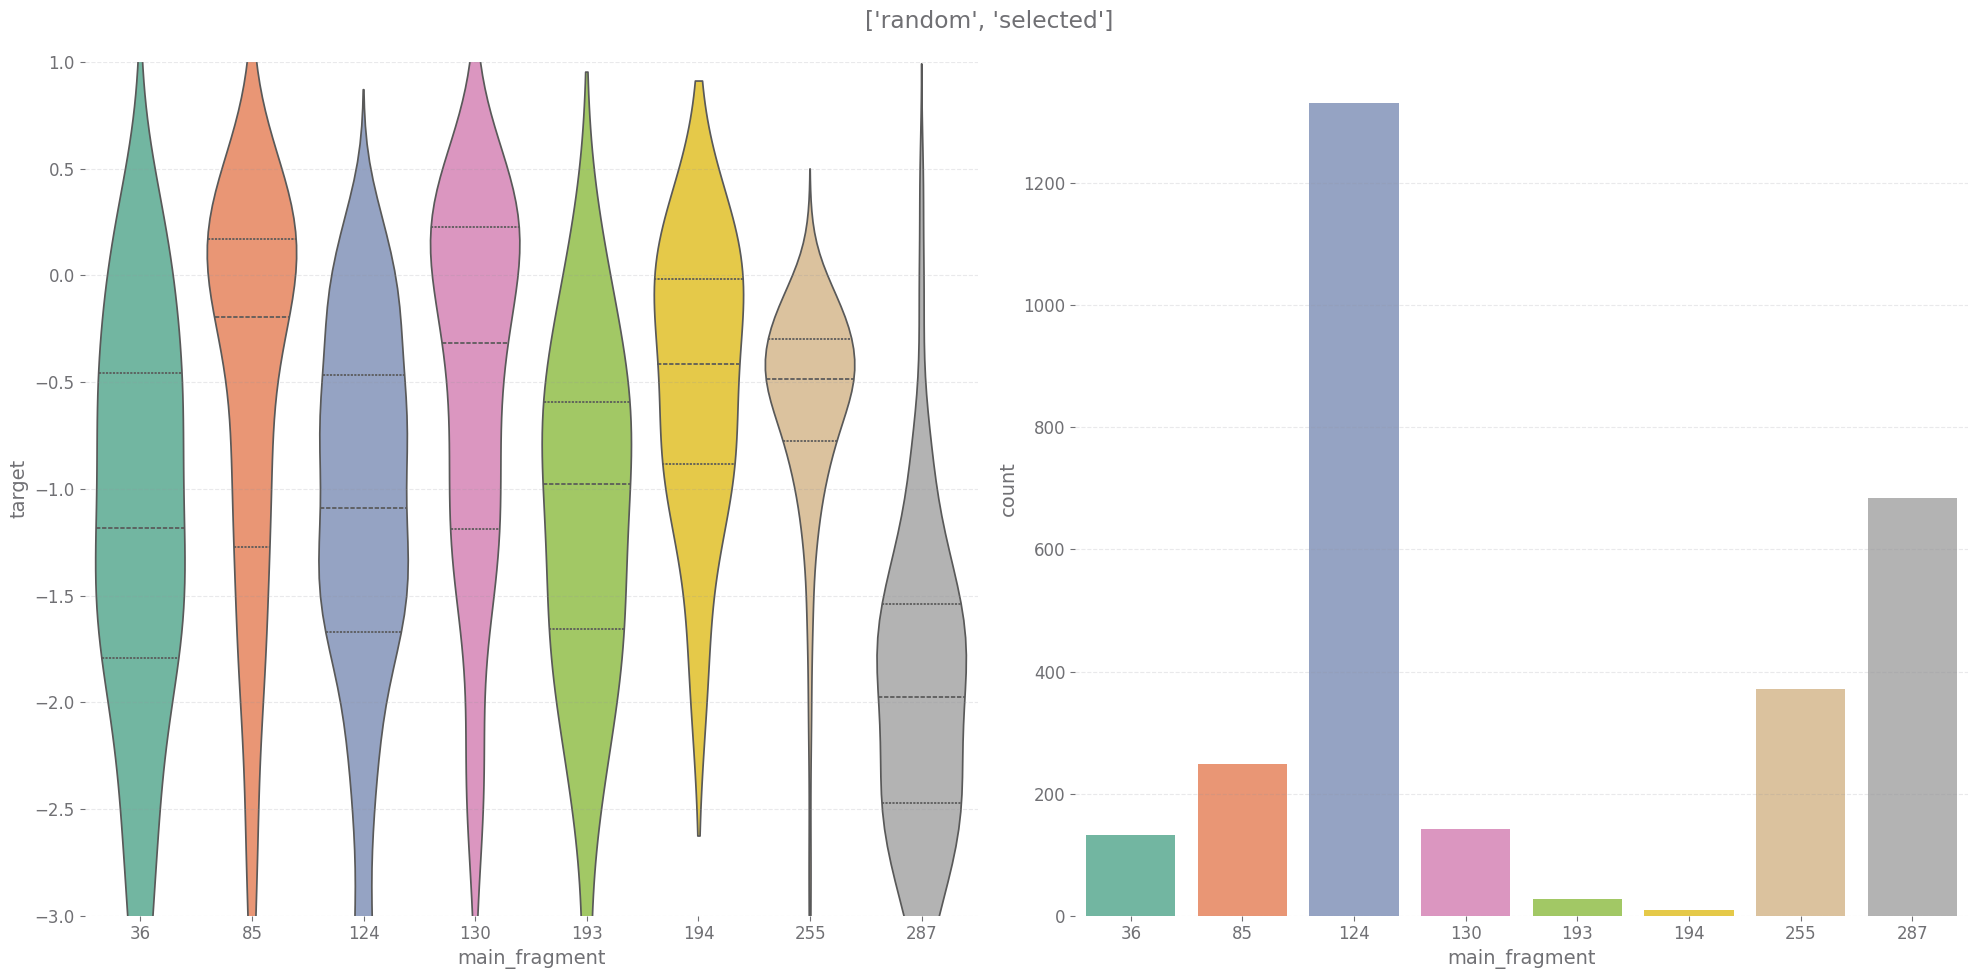

In [172]:
df_plot = plot_violin_cluster_unique(df_total_new,title = key.split('*')[:2],target='target',cluster =5)

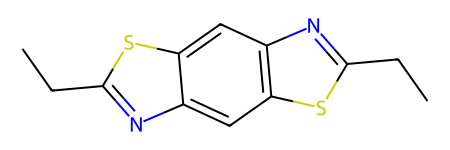

In [177]:
df_precursors.loc[df_precursors['orgcluster']==198,:]['mol_org'].values[0]

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  d

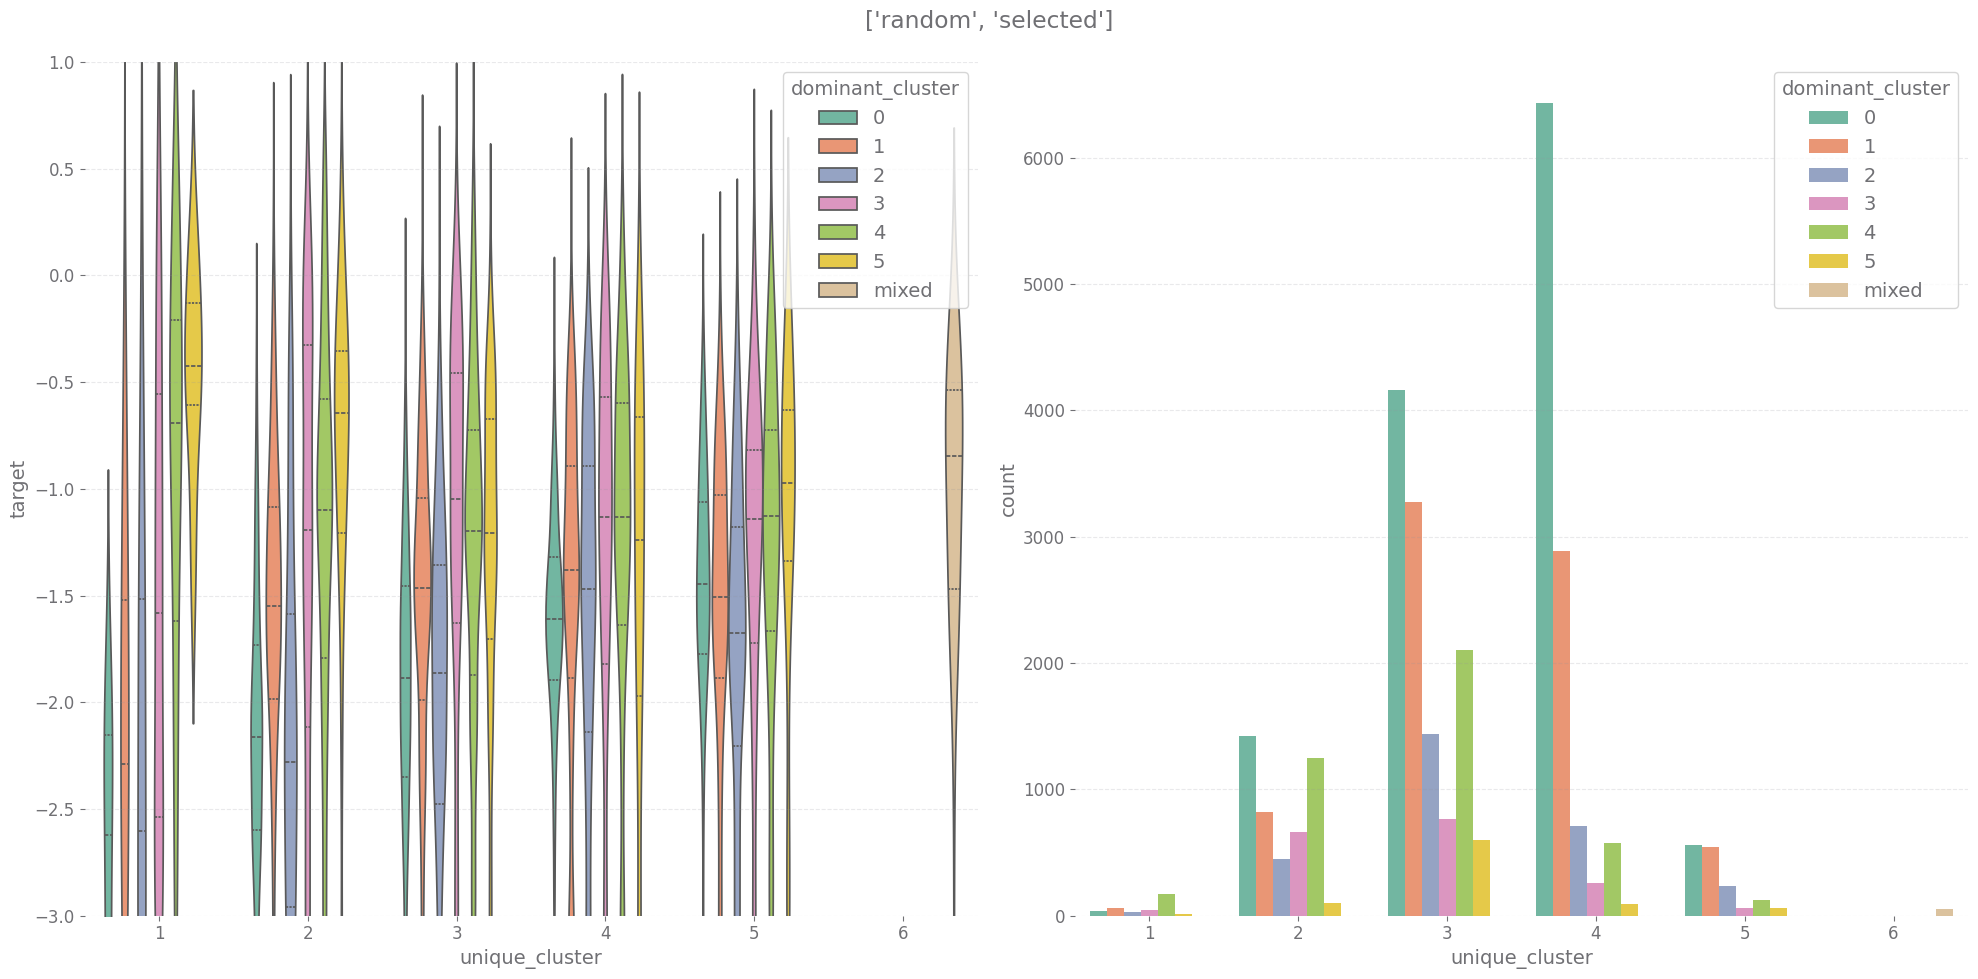

In [57]:
import seaborn as sns
def plot_violin_cluster_unique (df,title,target):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    df_plot['unique_cluster'] = [len(set(x)) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['unique_BB'] = [len(set(x)) for x in df_plot[[f'InChIKey_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] = [np.unique(x, return_counts=True) for x in df_plot[[f'cluster_{i}' for i in range(6)]].to_numpy()]
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: x[0][np.argmax(x[1])] if x[1].max()> 1 else 7)
    df_plot.sort_values('dominant_cluster',ascending=True,inplace=True)
    df_plot['dominant_cluster'] =df_plot['dominant_cluster'].apply(lambda x: 'mixed' if x==7 else x)
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    sns.violinplot(data=df_plot, x=f'unique_cluster', y=target, split=False, inner="quart",ax=ax[0],hue=f'dominant_cluster',palette='Set2')
    sns.countplot(data=df_plot, x=f'unique_cluster',ax=ax[1],hue=f'dominant_cluster',palette='Set2')
    ax[0].set_ylim(-3,1)
    #ax.legend()#.set_visible(False)
    #ax.set_title(f'Position {i}')
    #ax.set_xlabel(f'Building block cluster')
    #ax.set_ylabel(f'Target property (a.u.)')
    fig.suptitle(title)
    fig.tight_layout()
    return df_plot
df_plot = plot_violin_cluster_unique(df_Benchmark,title = key.split('*')[:2],target='target')

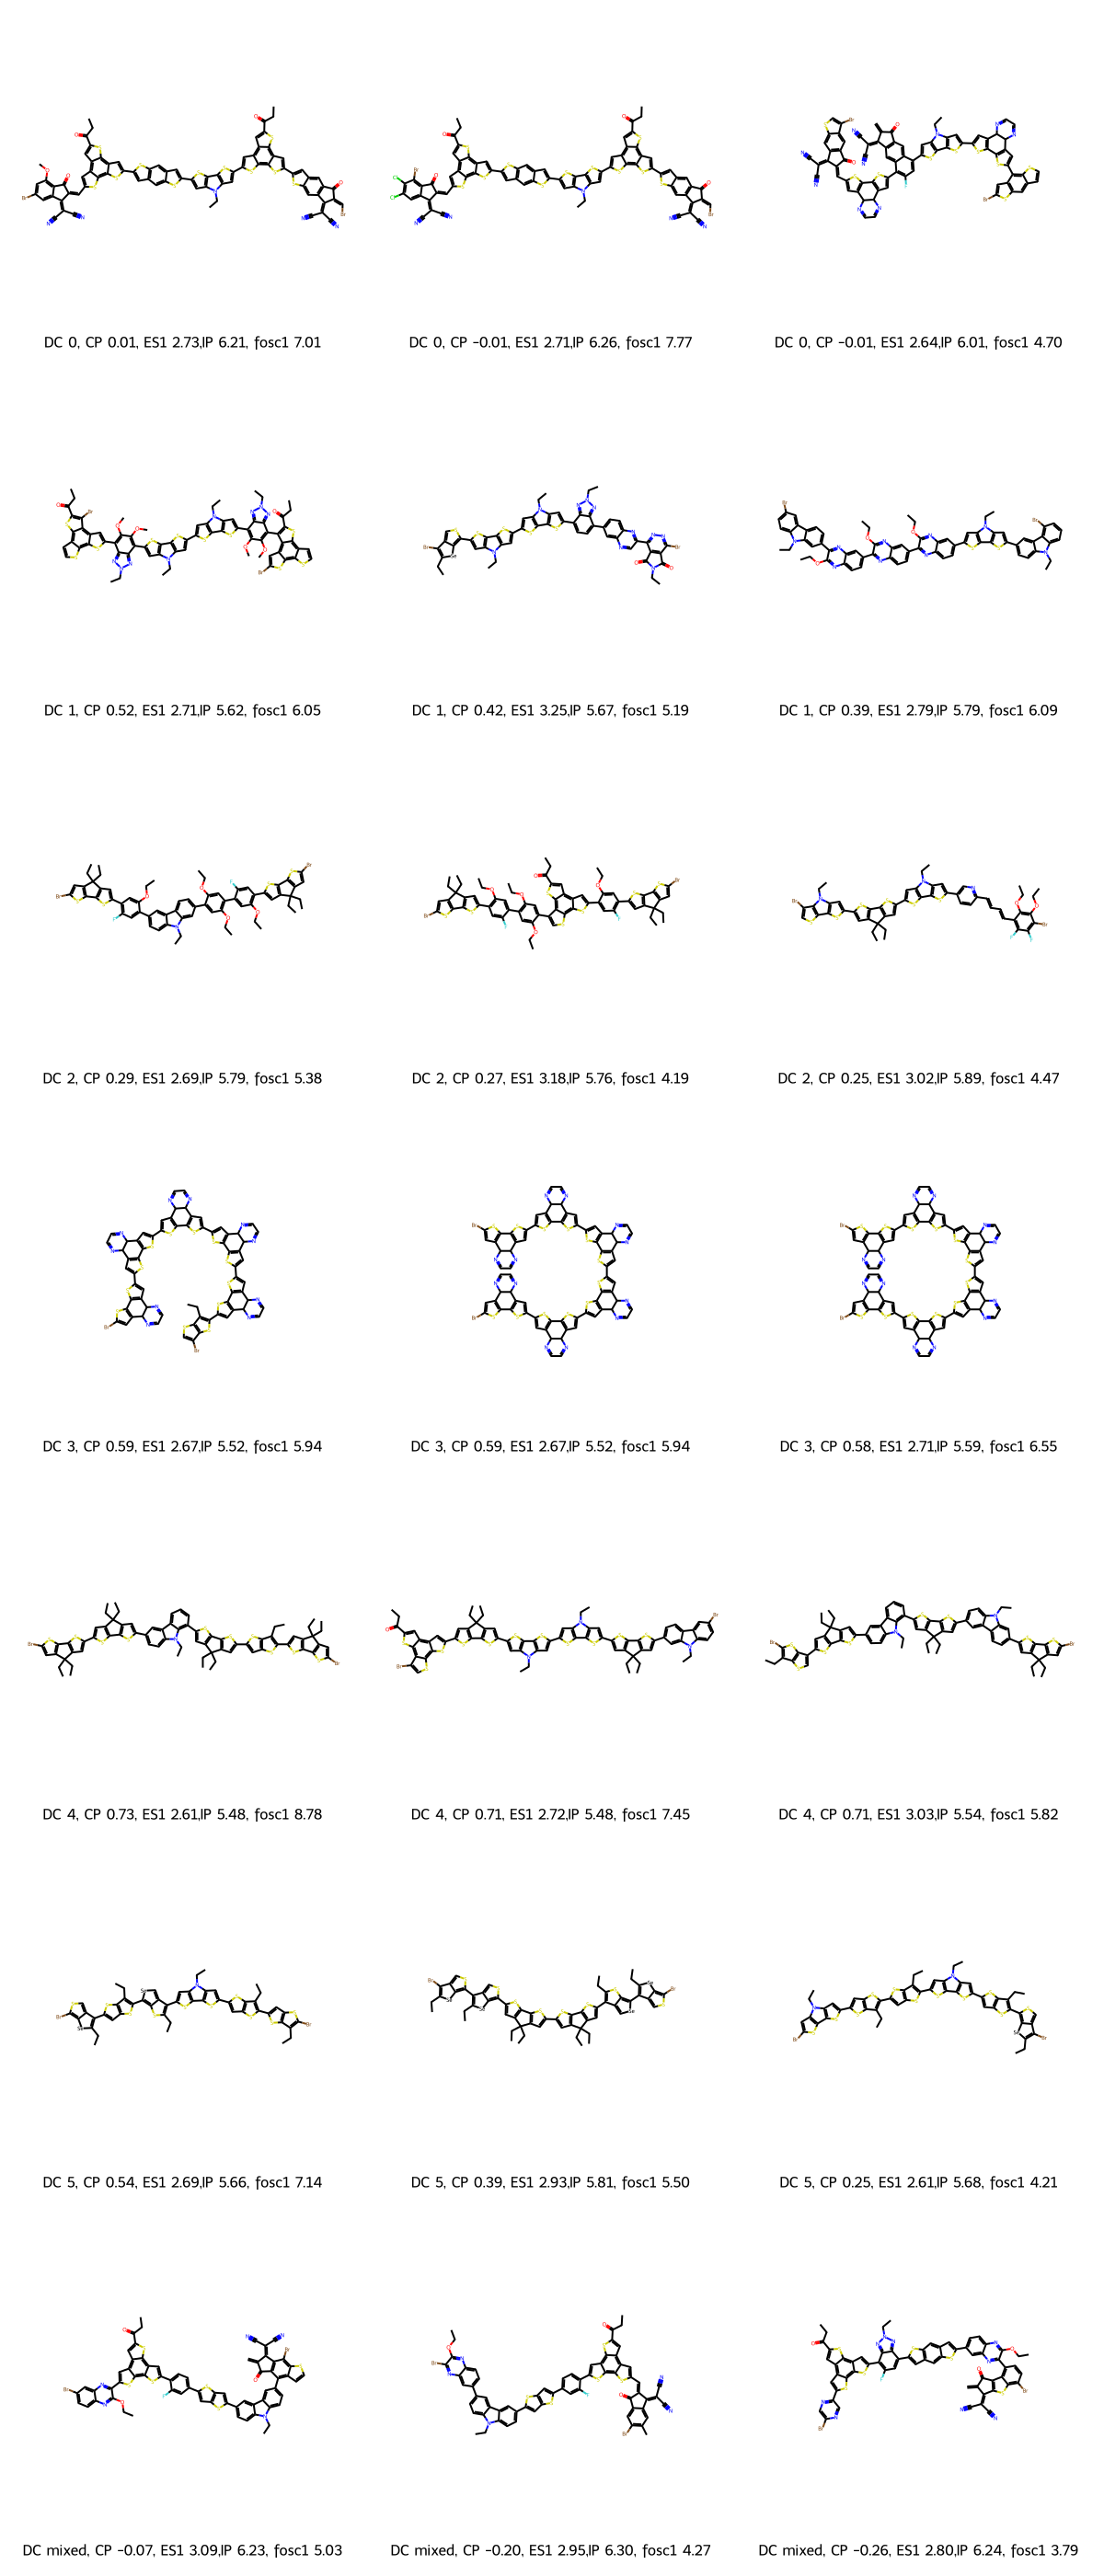

In [60]:
from stk_search.utils import tanimoto_similarity_utils
import importlib
importlib.reload(tanimoto_similarity_utils)
from rdkit.Chem import Draw
from rdkit import Chem  
%matplotlib inline

def plot_best_oligomer(df_all,mol_per_cluster =3):
    legends = []
    mols_all = []
    for cluster in df_all['dominant_cluster'].unique():
        df = df_all[df_all['dominant_cluster']==cluster].copy()
        df.sort_values(by='target',inplace=True,ascending=False)
        mols = tanimoto_similarity_utils.get_mol_from_df(df[:mol_per_cluster], mol_per_cluster)
        mols_2d =[Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols]
        mols.extend(mols_2d)
        mols_all.extend(mols_2d)
        legends.extend([f"DC {cluster}, CP {x['target']:.2f}, ES1 {x['ES1']:.2f},IP {x['ionisation potential (eV)']:.2f}, fosc1 {x['fosc1']:.2f} " for _,x in df[:mol_per_cluster].iterrows()] )
    img=Draw.MolsToGridImage(mols_all,molsPerRow=3,subImgSize=(400,400),returnPNG=False,legends=legends)
    return img 
plot_best_oligomer(df_plot,mol_per_cluster =3)

In [56]:
from stk_search.utils import tanimoto_similarity_utils
import importlib
importlib.reload(tanimoto_similarity_utils)
from rdkit.Chem import Draw
from rdkit import Chem  
%matplotlib inline

def plot_best_oligomer(df_all,mol_per_cluster =3):
    legends = []
    mols_all = []
    for cluster in df_all['dominant_cluster'].unique():
        df = df_all[df_all['dominant_cluster']==cluster].copy()
        df.sort_values(by='target',inplace=True,ascending=False)
        mols = tanimoto_similarity_utils.get_mol_from_df(df[:mol_per_cluster], mol_per_cluster)
        mols_2d =[Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols]
        mols.extend(mols_2d)
        mols_all.extend(mols_2d)
        legends.extend([f"Nu BB {cluster}, CP {x['target']:.2f}, ES1 {x['ES1']:.2f},IP {x['ionisation potential (eV)']:.2f}, fosc1 {x['fosc1']:.2f} " for _,x in df[:mol_per_cluster].iterrows()] )
    img=Draw.MolsToGridImage(mols_all,molsPerRow=4,subImgSize=(400,400),returnPNG=False,legends=legends)
    return img 
plot_best_oligomer(df_total_new,mol_per_cluster =4)

KeyError: 'dominant_cluster'